<img src="report_material/feup_logo_old.png" width="30%" align="center"/>

<h1 style="text-align:center">Neural Networks for the Prediction of Anuran Species (E3.)</h1>
<h3 style="text-align:center">Final Delivery</h3>
<br/><br/>
<p style="text-align:center">Artificial Intelligence (IART)</p>
<p style="text-align:center">3<sup>rd</sup> year in Master in Informatics and Computing Engineering</p>

### Authors

* Miguel Ramalho    - 201403027 - [m.ramalho@fe.up.pt](mailto:up201403027@fe.up.pt)
* Rostyslav Khoptiy - 201506219 - [up201506219@fe.up.pt](mailto:up201506219@fe.up.pt)

<!--spellchecking: https://stackoverflow.com/a/48710561/6196010 -->

<div style="text-align:right"><i>April 8<sup>th</sup>, 2018</i></div>
<br/><br/>

---

# Code

## Initialization

### Import modules

In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np
import io # to pass data as StringIO object
import time # to set the random seed for train and test sampling
import matplotlib.pyplot as plt # to display plots
from sklearn.model_selection import KFold, StratifiedKFold # for cross-validation, needs scipy
np.seterr(divide='ignore', invalid='ignore'); # avoid unnecessary messages

### Initialize constants

In [0]:
DATASET_PATH = "dataset/frogs.csv" # the path to the dataset file
N_FEATURES   = 22 # the number of features in the dataset
LABEL_INDEX  = 24 # the index in the dataset where the label to predict is
BATCH_SIZE   = 100 # batch size for the train, evaluation and prediction
NUM_CLASSES  = 10 # last layer, num classifications
NUM_ITEMS    = 7195 #Num items in dataset
CROSS_VALIDATION_FUNCTION = StratifiedKFold # use KFold to ignore class representation
ACTIVATION_FUNCTION = tf.nn.sigmoid # default is tf.nn.relu

## Helper Functions

In this section we include functions that are directed at helping the visualisation of the project, the manipulation of data and the creation, training and evaluation of models. Here functions that start with an underscore (_) are purely 'private' helper functions and shouldn't be used or even considered for the evaluation of the report

### Chart Drawing and Visualization functions

In [0]:
from IPython.core.display import display_html, HTML
# function to print string into visual HTML
def html(s, html_tag=None):
    if html_tag:
        s = tag(html_tag, s)
    display_html(HTML(s))
def tag(tag, s):
    return "<%s>%s</%s>" % (tag, s, tag)

In [0]:
from IPython.display import display
# receives paddings and a list @layer_sizes with the number of nodes to draw
def _draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    # https://gist.github.com/craffel/2d727968c3aaebd10359
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(max(len(layer_sizes) - 1, 1))
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)
# helper function to draw a neural network
def drawNN(hidden_layers, figsize=(12, 12), name=None):
    #plt.ioff() #plt.ion()
    plt.tight_layout()
    fig = plt.figure(figsize=figsize);
    ax = fig.gca()
    ax.axis('off')
    _draw_neural_net(ax, .1, .9, .1, .9, [N_FEATURES] + hidden_layers + [NUM_CLASSES])
    display(fig);
    plt.close();

In [0]:
# create an abstract histogram
def _draw_label_distribution(label_column, title_text):
    label_count = pd.Series.value_counts(label_column, normalize=True, sort=False)
    label_count = label_count.sort_index()
    label_count.plot(kind='barh', title=title_text, stacked=True, fontsize=15, figsize=(8,8), color="darkblue" )

# create a histogram with the distribution of species
def draw_species_distribution_chart(df, title_text="Species Dataset Distribution"):
    species_column = df['Species']
    _draw_label_distribution(species_column, title_text)

### Creating Deep Neural Network Models 
 * `my_feature_columns`        - the features that the model should receive as input
 * `inner_layers_architecture` - a list of N hidden layers where N[i] is the number of nodes of the layer i

In [0]:
def create_DNN(my_feature_columns, inner_layers_architecture, save_folder_path=None, num_classes=NUM_CLASSES):
    # Build a DNN (Deep Neural Network) with 1 hidden layer with 10 nodes
    classifier = tf.estimator.DNNClassifier(
            feature_columns = my_feature_columns,
            hidden_units = inner_layers_architecture, # 1:-1 removes the first and last elements of the architecture
            n_classes = num_classes, # num nodes of final layer
            model_dir = save_folder_path, # value None means it will be saved in temp
            activation_fn = ACTIVATION_FUNCTION, # activation function to use
    )
    
    return classifier

### Training Models

In [0]:
SHUFFLE_PARAM = NUM_ITEMS * 10 #df.shape[0] * 10
# helper function to yield a part of the training data to be used by TF's classifier.train method
def _train_input_fn(features, labels):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    
    # Shuffle, repeat, and batch the examples. The shuffle argument should be larger than the number of examples
    return dataset.shuffle(SHUFFLE_PARAM).repeat().batch(BATCH_SIZE)

In [0]:
# Train a model, given the train data and the number of steps
def train_model(classifier, train_x, numeric_train_y, num_steps=1000):
    classifier.train(input_fn=lambda:_train_input_fn(train_x, numeric_train_y), steps=num_steps)

### Evaluating Models

In [0]:
# helper function for the classifier.evaluate method
def _eval_input_fn(features, labels=None):
    inputs = features if labels is None else (features, labels)
    
    # Convert inputs to a tf.dataset object. Batch the examples.
    dataset = tf.data.Dataset.from_tensor_slices(inputs).batch(BATCH_SIZE)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()

In [0]:
# Evaluate a model - returns a tuple (eval_results, global_step)
def evaluate_model(classifier, test_x, numeric_test_y):
    return classifier.evaluate(input_fn=lambda:_eval_input_fn(dict(test_x), numeric_test_y))

In [0]:
# predict from a trained model - returns a list of the predictions
def predict_model(classifier, predict_x):
    predictions = list(classifier.predict(input_fn=lambda:_eval_input_fn(dict(predict_x))))
    return [el["class_ids"][0] for el in predictions]

### Dataset Splitting

In [0]:
# converts a list of strings into a list of IDs (numerical values) used for the classifier
def _convert_labels_to_number(labels):
    unique_labels = list(set(labels)) # list of unique values
    return [unique_labels.index(l) for l in labels]

In [0]:
def _format_TF_data(train, test):
    # split dataframes into X (features) and y (classes) - use species as label
    train_x, train_y = train.iloc[:,:N_FEATURES], train.iloc[:,LABEL_INDEX:LABEL_INDEX+1]
    test_x, test_y = test.iloc[:,:N_FEATURES], test.iloc[:,LABEL_INDEX:LABEL_INDEX+1]
    
    # for the 10 species, get a numerical mapping of the text name of that species (needed for DNN)
    numeric_train_y = _convert_labels_to_number(train_y.iloc[:,0])
    numeric_test_y  = _convert_labels_to_number(test_y.iloc[:,0])
    
    return (train_x, numeric_train_y, test_x, numeric_test_y)

In [0]:
# Convert the features MFCCs_1 to MFCCs_22 into Tensorflow feature columns
def get_TF_feature_columns(df):
    data_df = df.iloc[:,:N_FEATURES]
    return [tf.feature_column.numeric_column(key=key) for key in list(data_df)]

#### Simple data splitting into Train and Test data

In [0]:
# returns a single iteration
def simple_data_split_generator(df, labels, train_fraction):
    train=df.sample(frac=train_fraction, random_state=int(time.time()))
    test=df.drop(train.index)
    yield _format_TF_data(train, test) # in a for loop gives one single loop

#### Cross Validation splitting into Train and Test data

In [0]:
def _split_data_by_indices(train_indices, test_indices):
    train = df.iloc[train_indices]
    test = df.iloc[test_indices]
    return _format_TF_data(train, test)

In [0]:
def _get_k_fold_CV_split_indices(df, labels, num_folds = 3):
    k_fold = CROSS_VALIDATION_FUNCTION(n_splits = num_folds, shuffle=True)
    return k_fold.split(df, labels)

In [0]:
def kFoldCV_tf_data_generator(df, labels, train_fraction):
    num_folds = int(1.0 / (1.0 - train_fraction))
    for train_indices, test_indices in _get_k_fold_CV_split_indices(df, labels, num_folds):
        yield(_split_data_by_indices(train_indices, test_indices))

### Hyper-Parameter Tuning
Given a dataset, the respective labels, a function to split the data and another to calculate the number of steps, this function iterates over all the defined architectures in **INNER_LAYERS** and over all the **NUM_STEPS** and over all the  **TRAIN_FRACTIONS** and does the following:
 * Split the data accordingly
 * Train the model
 * Evaluate the model
 * Report the results
 
This can be used for quick comparison of multiple combinations of architectures, number of steps and train fractions, essentially tuning **hyper-parameters**. More can hyper-parameters can be added if needed.

In [0]:
def run_model_iterations(df, labels, data_generator):
    evaluations = []
    for inner_architecture in INNER_LAYERS:
        #drawNN([N_FEATURES] + inner_architecture + [NUM_CLASSES])
        for num_steps in NUM_STEPS:
            for train_fraction in TRAIN_FRACTIONS:
                my_feature_columns = get_TF_feature_columns(df) # seems to need to generate one for each estimator
                classifier = create_DNN(my_feature_columns, inner_architecture)
                (train_x, numeric_train_y, test_x, numeric_test_y) = next(data_generator(df, labels, train_fraction))
                train_model(classifier, train_x, numeric_train_y, num_steps)
                eval_result = evaluate_model(classifier, test_x, numeric_test_y)
                predictions = predict_model(classifier, test_x)
                # evaluation results, only the results of the last evaluation and prediction done on estimator
                evaluations.append({"config": (inner_architecture, train_fraction, num_steps), "eval_result" : eval_result, "prediction": (np.array(predictions), np.array(numeric_test_y))})
    html("Model iterations complete", "h1")
    return evaluations # evaluations can have duplicate 'keys' if k-fold is used

## Evaluation Metrics Used

From the confusion matrix, we derive the number of **true positives** (`TP`), **false positives** (`FP`), **true negatives** (`TN`) and **false negatives** (`FN`).

<img src="report_material/images/multiclass_confusion.png" width="300px" />
<p style="text-align:center">Image of a confusion matrix for a multiclass classification problem</p>

$ precision = \frac{ TP}{TP + FP} $

$ recall  = \frac{TP}{TP + FN} $

$ accuracy = \frac{TP + TN}{TP + FP + FN + TN} $

$ F1-score = 2 \cdot \frac{precision\cdot recall}{precision+ recall} $

Further metrics such as **specificity**, **negative predictive value**, **false positive rate**, **false negative rate** and **false discovery rate** were also calculated, but were not considered when making model decisions

In [0]:
# calculate metrics based on confusion matrix -> precision, recall, f1, ...
def print_metrics(prediction, confusion_matrix):
    predicted, actual = prediction
    
    # get values from confusion matrix for each class
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix) # false positives
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix) # false negatives
    TP = np.diag(confusion_matrix)  # true positives
    TN = confusion_matrix.sum() - (FP + FN + TP) # true negatives

    # calculate metrics
    TPR = TP/(TP+FN) # Recall, sensitivity, hit rate, or true positive rate
    TNR = TN/(TN+FP) # Specificity or true negative rate
    PPV = TP/(TP+FP) # Precision or positive predictive value
    NPV = TN/(TN+FN) # Negative predictive value
    FPR = FP/(FP+TN) # Fall out or false positive rate
    FNR = FN/(TP+FN) # False negative rate
    FDR = FP/(TP+FP) # False discovery rate
    F1  =  2 * ((PPV * TPR) / (PPV + TPR)) # f1-score
    ACC = (TP+TN)/(TP+FP+FN+TN) # accuracy
    
    #overall values in percentage
    metrics = tuple(map(lambda v: np.nanmean(v) * 100, [ACC, PPV, TPR, F1]))
    
    # create the table with the statistics
    header = tag("tr", "<th>Species</th><th>Accuracy</th> <th>Precision</th> <th>Recall</th> <th>F1-score</th>")
    body = ""
    footer = tag("tr", "<th>Average</th><th>%.2f%%</th> <th>%.2f%%</th> <th>%.2f%%</th> <th>%.2f%%</th>" % metrics)
    for i in range(len(TP)):
        body += tag("tr", "<td>%s</td><td>%.2f%%</td> <td>%.2f%%</td> <td>%.2f%%</td> <td>%.2f%%</td>" % (i, ACC[i] * 100, PPV[i] * 100, TPR[i] * 100, F1[i] * 100))
        
    table = "<table style='font-size:16px;margin-left:auto;margin-right:auto;'>%s%s%s</table>" % (header, body, footer)
    html(table)
    return metrics

In [0]:
# print a confusion matrix after a prediction
def get_confusion_matrix(prediction):
    predicted, actual = prediction
    con_mat = tf.confusion_matrix(actual, predicted, num_classes=NUM_CLASSES)
    with tf.Session():
        return tf.Tensor.eval(con_mat,feed_dict=None, session=None)

### Functions to display and describe the output of a model

In [0]:
def print_configs(configs):
    header = tag("tr", "<th>Hidden Layers</th><th>Training Fraction</th> <th>Number of Steps</th>")
    body = tag("tr", "<th>%s</th><th>%.0f%%</th><th>%s</th>" % (configs[0], configs[1] * 100, configs[2]))
    table = "<table style='font-size:16px;margin-left:auto;margin-right:auto;text-align=center'>%s%s</table>" % (header, body)
    html(table)

In [0]:
def display_model_results(evaluations):
    # show results, statistics
    print('Num Results: %d' % len(evaluations))
    chart_data = [] # data to create charts later
    for i, e in enumerate(evaluations):
        confusion_matrix = get_confusion_matrix(e["prediction"])
        html("<h2 style='text-align:center'>Iteration %d</h2>" % (i+1))
        
        print_configs(e["config"])
        drawNN(e["config"][0], (7,7))
        
        html("Confusion Matrix:", "h4")
        html("<br/>")
        print(confusion_matrix)
        
        metrics = print_metrics(e["prediction"], confusion_matrix)
        
        html("<hr>")
        
        chart_data.append((e["config"], metrics)) # config, [ACC, PPV, TPR, F1]
    display_model_comparison(chart_data)

In [0]:
# compare different architectures, train ratios and number of steps
def display_model_comparison(chart_data):
#     print(chart_data)
#     plt.rcParams.update({'font.size': 16})
    for percentage in TRAIN_FRACTIONS:
        plt.figure(figsize=(20,10));
        for layers in INNER_LAYERS:
            x, y = [], []
            for data in chart_data:
                if data[0][0] == layers and data[0][1] == percentage:
                    x.append(data[0][2])
                    y.append(data[1][0])
            plt.plot(x, y, '-', label="%s layers" % layers)


        for steps in NUM_STEPS:
            y = []
            for data in chart_data:
                if data[0][2] == steps and data[0][1] == percentage:
                    y.append(data[1][0])
            plt.plot([steps] * len(y), y, 'x', label="%4d steps"%steps, markersize=16)

        plt.title('Evolution of Accuracy for a training fraction of %.f%%' % (percentage * 100))
        plt.legend(loc='best')
        plt.show()

# Main

### Loading Data

In [25]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
 
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1FgfTiJIKbkHLg3xtajFrNTK4ef5m0VuT'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()[100:1000]))

Downloaded content "FCCs_12,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
1,0.152936298220384,-0.105585902844019,0.200721914808566,0.317201062343259,0.260763853131077,0.100944640810053,-0.150062604917616,-0.17112763198601,0.124676436148438,0.188654145822323,-0.0756217229244772,-0.156435925226375,0.0822451152835443,0.135752042383891,-0.0240166450287792,-0.108351107221198,-0.0776225214037558,-0.00956780151914234,0.0576839754007957,0.118680135068692,0.0140384456733697,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,0.171534257314109,-0.0989747371205295,0.268425220827017,0.338671862995453,0.268353099863332,0.0608350871920449,-0.222474640379244,-0.207692670568256,0.170882873543032,0.27095827998887,-0.0950039445276873,-0.254341468381362,0.0227862345814336,0.163320101050209,0.0120222808645159,-0.0909740108032878,-0.0565095219192882,-0.035303356"


In [26]:
# from csv to pandas Dataframe
# df = pd.read_csv(DATASET_PATH)
df = pd.read_csv(io.StringIO(downloaded.GetContentString()))
df.columns = df.columns.str.replace(" ", "") # remove whitespace, needed for TF

print("Got %d examples from the .csv" % df.shape[0])
df.head()

Got 7195 examples from the .csv


MFCCs_1   MFCCs_2   MFCCs_3   MFCCs_4   MFCCs_5   MFCCs_6   MFCCs_7  \
0      1.0  0.152936 -0.105586  0.200722  0.317201  0.260764  0.100945   
1      1.0  0.171534 -0.098975  0.268425  0.338672  0.268353  0.060835   
2      1.0  0.152317 -0.082973  0.287128  0.276014  0.189867  0.008714   
3      1.0  0.224392  0.118985  0.329432  0.372088  0.361005  0.015501   
4      1.0  0.087817 -0.068345  0.306967  0.330923  0.249144  0.006884   

    MFCCs_8   MFCCs_9  MFCCs_10    ...     MFCCs_17  MFCCs_18  MFCCs_19  \
0 -0.150063 -0.171128  0.124676    ...    -0.108351 -0.077623 -0.009568   
1 -0.222475 -0.207693  0.170883    ...    -0.090974 -0.056510 -0.035303   
2 -0.242234 -0.219153  0.232538    ...    -0.050691 -0.023590 -0.066722   
3 -0.194347 -0.098181  0.270375    ...    -0.136009 -0.177037 -0.130498   
4 -0.265423 -0.172700  0.266434    ...    -0.048885 -0.053074 -0.088550   

   MFCCs_20  MFCCs_21  MFCCs_22           Family      Genus         Species  \
0  0.057684  0.118680  0.014038  Leptodactylidae  Adenomera  AdenomeraAndre   
1  0.020140  0.082263  0.029056  Leptodactylidae  Adenomera  AdenomeraAndre   
2 -0.025083  0.099108  0.077162  Leptodactylidae  Adenomera  AdenomeraAndre   
3 -0.054766 -0.018691  0.023954  Leptodactylidae  Adenomera  AdenomeraAndre   
4 -0.031346  0.108610  0.079244  Leptodactylidae  Adenomera  AdenomeraAndre   

   RecordID  
0         1  
1         1  
2         1  
3         1  
4         1  

[5 rows x 26 columns]

In [0]:
# get a mapping of all the labels in the Dataset into its integer values (required for Stratified Cross Validation)
labels = _convert_labels_to_number(df.iloc[:,LABEL_INDEX:LABEL_INDEX+1].iloc[:,0])

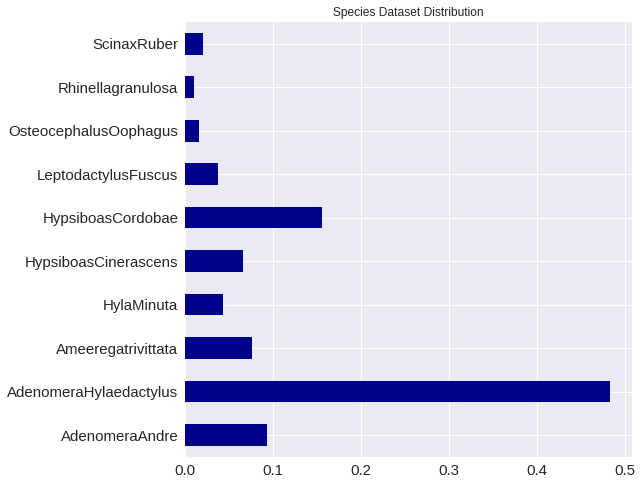

In [28]:
# draw dataset distribution
draw_species_distribution_chart(df)

### Running iterations

In [0]:
### Iterations

# modify here to set model configurations
INNER_LAYERS = [
    [10],
    [100],
    [10, 10],
    [100, 100],
    [10, 10, 10],
    [100, 100, 100],
    [100, 50, 25],
    [25, 50, 100]
]

TRAIN_FRACTIONS = [
    0.8,
    0.5,
]

NUM_STEPS = [
    100, 
    200,
    500,
    1000,
    1500,
    2000
]

### Initial approach to dataset splitting
Random split into train and test

**Warning:** Depending on the complexity of the architecture and the number of steps in the training, this operation may take some time

In [30]:
# this may take a while
evaluations = run_model_iterations(df, labels, simple_data_split_generator)    

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpp353wifr', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f929f974048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpp353wifr/model.ckpt.
INFO:tensorflow:loss = 247.0772, step = 0
INFO:tensorfl

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp1w3_t52k/model.ckpt.
INFO:tensorflow:loss = 247.57137, step = 0
INFO:tensorflow:global_step/sec: 145.758
INFO:tensorflow:loss = 111.34531, step = 100 (0.689 sec)
INFO:tensorflow:global_step/sec: 166.759
INFO:tensorflow:loss = 85.64936, step = 200 (0.601 sec)
INFO:tensorflow:global_step/sec: 161.253
INFO:tensorflow:loss = 65.67024, step = 300 (0.621 sec)
INFO:tensorflow:global_step/sec: 160.44
INFO:tensorflow:loss = 57.534122, step = 400 (0.627 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmp1w3_t52k/model.ckpt.
INFO:tensorflow:Loss for final step: 72.960075.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-07:46:54

INFO:tensorflow:Starting evaluation at 2018-05-18-07:47:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbf0rne8n/model.ckpt-1500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-07:47:24
INFO:tensorflow:Saving dict for global step 1500: accuracy = 0.904795, average_loss = 0.36909676, global_step = 1500, loss = 35.408684
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbf0rne8n/model.ckpt-1500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp08ipcg53', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_check

INFO:tensorflow:global_step/sec: 161.722
INFO:tensorflow:loss = 54.92585, step = 1100 (0.621 sec)
INFO:tensorflow:global_step/sec: 161.228
INFO:tensorflow:loss = 53.234756, step = 1200 (0.619 sec)
INFO:tensorflow:global_step/sec: 159.694
INFO:tensorflow:loss = 38.710438, step = 1300 (0.621 sec)
INFO:tensorflow:global_step/sec: 174.689
INFO:tensorflow:loss = 38.38475, step = 1400 (0.576 sec)
INFO:tensorflow:global_step/sec: 165.463
INFO:tensorflow:loss = 31.923935, step = 1500 (0.607 sec)
INFO:tensorflow:global_step/sec: 159.566
INFO:tensorflow:loss = 46.59041, step = 1600 (0.623 sec)
INFO:tensorflow:global_step/sec: 158.503
INFO:tensorflow:loss = 34.95738, step = 1700 (0.630 sec)
INFO:tensorflow:global_step/sec: 162.207
INFO:tensorflow:loss = 45.800613, step = 1800 (0.620 sec)
INFO:tensorflow:global_step/sec: 173.896
INFO:tensorflow:loss = 22.838737, step = 1900 (0.575 sec)
INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp5zl5jlfl/model.ckpt.
INFO:tensorflow:Loss for final step

INFO:tensorflow:loss = 217.08409, step = 0
INFO:tensorflow:global_step/sec: 154.666
INFO:tensorflow:loss = 58.03808, step = 100 (0.650 sec)
INFO:tensorflow:global_step/sec: 157.8
INFO:tensorflow:loss = 63.691936, step = 200 (0.638 sec)
INFO:tensorflow:global_step/sec: 158.033
INFO:tensorflow:loss = 46.86837, step = 300 (0.628 sec)
INFO:tensorflow:global_step/sec: 167.72
INFO:tensorflow:loss = 32.638584, step = 400 (0.596 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmpu_lgdwv5/model.ckpt.
INFO:tensorflow:Loss for final step: 22.133795.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-07:48:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpu_lgdwv5/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-07:48:28
INFO:tensorflow:Saving dict for global step 500: accuracy = 

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp7rd9_ckf/model.ckpt.
INFO:tensorflow:loss = 283.57095, step = 0
INFO:tensorflow:global_step/sec: 158.821
INFO:tensorflow:loss = 58.51046, step = 100 (0.636 sec)
INFO:tensorflow:global_step/sec: 161.395
INFO:tensorflow:loss = 45.905514, step = 200 (0.617 sec)
INFO:tensorflow:global_step/sec: 158.828
INFO:tensorflow:loss = 40.859802, step = 300 (0.630 sec)
INFO:tensorflow:global_step/sec: 177.96
INFO:tensorflow:loss = 34.185795, step = 400 (0.563 sec)
INFO:tensorflow:global_step/sec: 160.619
INFO:tensorflow:loss = 25.949455, step = 500 (0.620 sec)
INFO:tensorflow:global_step/sec: 164.369
INFO:tensorflow:loss = 29.455902, step = 600 (0.613 sec)
INFO:tensorflow:global_step/sec: 159.748
INFO:tensorflow:loss = 43.655804, step = 700 (0.624 sec)
INFO:tensorflow:global_step/sec: 175.789
INFO:tensorflow:loss = 20.169292, step = 800 (0.567 sec)
INFO:tensorflow:global_step/sec: 161.833
INFO:tensorflow

INFO:tensorflow:global_step/sec: 152.574
INFO:tensorflow:loss = 46.203068, step = 100 (0.659 sec)
INFO:tensorflow:global_step/sec: 162.261
INFO:tensorflow:loss = 37.25142, step = 200 (0.617 sec)
INFO:tensorflow:global_step/sec: 160.338
INFO:tensorflow:loss = 39.973602, step = 300 (0.621 sec)
INFO:tensorflow:global_step/sec: 162.675
INFO:tensorflow:loss = 30.744858, step = 400 (0.619 sec)
INFO:tensorflow:global_step/sec: 170.34
INFO:tensorflow:loss = 35.703655, step = 500 (0.583 sec)
INFO:tensorflow:global_step/sec: 163.99
INFO:tensorflow:loss = 17.847652, step = 600 (0.610 sec)
INFO:tensorflow:global_step/sec: 162.617
INFO:tensorflow:loss = 33.380535, step = 700 (0.617 sec)
INFO:tensorflow:global_step/sec: 162.952
INFO:tensorflow:loss = 22.456171, step = 800 (0.615 sec)
INFO:tensorflow:global_step/sec: 165.76
INFO:tensorflow:loss = 34.68019, step = 900 (0.603 sec)
INFO:tensorflow:global_step/sec: 169.265
INFO:tensorflow:loss = 23.171873, step = 1000 (0.586 sec)
INFO:tensorflow:global_s

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpa747cxsz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f929d86c898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpa747cxsz/model.ckpt.
INFO:tensorflow:loss = 252.62103, step = 0
INFO:tensorflow:global_step/sec: 154.279
INFO:tens

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpym28v0mt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f92979e26d8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /

INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp6qyz3yz1/model.ckpt.
INFO:tensorflow:Loss for final step: 40.981285.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-07:51:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6qyz3yz1/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-07:51:16
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.89089644, average_loss = 0.3843036, global_step = 2000, loss = 36.867527
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6qyz3yz1/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '

INFO:tensorflow:Finished evaluation at 2018-05-18-07:51:44
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.82140374, average_loss = 0.5391379, global_step = 200, loss = 51.721294
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp1fqjjxi8/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpsh79v60h', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9277cafe80>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp_jma06ya/model.ckpt.
INFO:tensorflow:loss = 312.91937, step = 0
INFO:tensorflow:global_step/sec: 144.317
INFO:tensorflow:loss = 66.15027, step = 100 (0.699 sec)
INFO:tensorflow:global_step/sec: 160.075
INFO:tensorflow:loss = 49.733727, step = 200 (0.626 sec)
INFO:tensorflow:global_step/sec: 156.028
INFO:tensorflow:loss = 42.492344, step = 300 (0.640 sec)
INFO:tensorflow:global_step/sec: 161.654
INFO:tensorflow:loss = 16.0805, step = 400 (0.617 sec)
INFO:tensorflow:global_step/sec: 164.266
INFO:tensorflow:loss = 29.011562, step = 500 (0.609 sec)
INFO:tensorflow:global_step/sec: 155.107
INFO:tensorflow:loss = 26.886116, step = 600 (0.645 sec)
INFO:tensorflow:global_step/sec: 157.439
INFO:tensorflow:loss = 17.633083, step = 700 (0.631 s

INFO:tensorflow:global_step/sec: 160.438
INFO:tensorflow:loss = 22.999502, step = 700 (0.618 sec)
INFO:tensorflow:global_step/sec: 170.156
INFO:tensorflow:loss = 16.225925, step = 800 (0.591 sec)
INFO:tensorflow:global_step/sec: 154.905
INFO:tensorflow:loss = 18.170786, step = 900 (0.643 sec)
INFO:tensorflow:global_step/sec: 156.817
INFO:tensorflow:loss = 15.663661, step = 1000 (0.640 sec)
INFO:tensorflow:global_step/sec: 157.704
INFO:tensorflow:loss = 34.255474, step = 1100 (0.634 sec)
INFO:tensorflow:global_step/sec: 170.395
INFO:tensorflow:loss = 7.3171916, step = 1200 (0.592 sec)
INFO:tensorflow:global_step/sec: 155.089
INFO:tensorflow:loss = 19.425558, step = 1300 (0.645 sec)
INFO:tensorflow:global_step/sec: 155.892
INFO:tensorflow:loss = 12.827536, step = 1400 (0.632 sec)
INFO:tensorflow:global_step/sec: 148.211
INFO:tensorflow:loss = 17.925587, step = 1500 (0.678 sec)
INFO:tensorflow:global_step/sec: 157.83
INFO:tensorflow:loss = 11.7814245, step = 1600 (0.633 sec)
INFO:tensorfl

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp_2wn3z21/model.ckpt.
INFO:tensorflow:loss = 240.15126, step = 0
INFO:tensorflow:global_step/sec: 144.986
INFO:tensorflow:loss = 146.22229, step = 100 (0.693 sec)
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmp_2wn3z21/model.ckpt.
INFO:tensorflow:Loss for final step: 106.152756.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-07:53:30
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_2wn3z21/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-07:53:30
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.6198749, average_loss = 1.0815451, global_step = 200, loss = 103.756226
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph 

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp1qcueerm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f929d7f8048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /

INFO:tensorflow:loss = 105.10098, step = 200 (0.649 sec)
INFO:tensorflow:global_step/sec: 155.791
INFO:tensorflow:loss = 103.29015, step = 300 (0.641 sec)
INFO:tensorflow:global_step/sec: 164.712
INFO:tensorflow:loss = 100.7067, step = 400 (0.606 sec)
INFO:tensorflow:global_step/sec: 153.051
INFO:tensorflow:loss = 109.91402, step = 500 (0.655 sec)
INFO:tensorflow:global_step/sec: 153.386
INFO:tensorflow:loss = 86.13789, step = 600 (0.652 sec)
INFO:tensorflow:global_step/sec: 144.74
INFO:tensorflow:loss = 94.93558, step = 700 (0.687 sec)
INFO:tensorflow:global_step/sec: 165.525
INFO:tensorflow:loss = 87.17477, step = 800 (0.604 sec)
INFO:tensorflow:global_step/sec: 155.093
INFO:tensorflow:loss = 73.26537, step = 900 (0.649 sec)
INFO:tensorflow:global_step/sec: 155.318
INFO:tensorflow:loss = 89.18939, step = 1000 (0.643 sec)
INFO:tensorflow:global_step/sec: 155.453
INFO:tensorflow:loss = 92.90901, step = 1100 (0.646 sec)
INFO:tensorflow:global_step/sec: 157.241
INFO:tensorflow:loss = 78.

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmprauaavyo/model.ckpt.
INFO:tensorflow:loss = 286.20056, step = 0
INFO:tensorflow:global_step/sec: 136.889
INFO:tensorflow:loss = 110.66916, step = 100 (0.738 sec)
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmprauaavyo/model.ckpt.
INFO:tensorflow:Loss for final step: 79.07521.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-07:55:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmprauaavyo/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-07:55:19
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.80055594, average_loss = 0.73450685, global_step 

INFO:tensorflow:Restoring parameters from /tmp/tmprirqtl4t/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-07:55:47
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.92494786, average_loss = 0.2708742, global_step = 1000, loss = 25.985865
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmprirqtl4t/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpib2qftvx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <

INFO:tensorflow:Saving dict for global step 1500: accuracy = 0.9332777, average_loss = 0.24075754, global_step = 1500, loss = 24.05569
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpgkyxb7o2/model.ckpt-1500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpg2u63nph', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f929d6a2b38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_repli

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbdse8vy1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f929788a828>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpbdse8vy1/model.ckpt.
INFO:tensor

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplilwdkql/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpxb6s7_4f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9278a209e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:G

INFO:tensorflow:loss = 65.125854, step = 500 (0.616 sec)
INFO:tensorflow:global_step/sec: 154.972
INFO:tensorflow:loss = 49.989105, step = 600 (0.648 sec)
INFO:tensorflow:global_step/sec: 153.258
INFO:tensorflow:loss = 37.925095, step = 700 (0.655 sec)
INFO:tensorflow:global_step/sec: 154.555
INFO:tensorflow:loss = 38.50304, step = 800 (0.641 sec)
INFO:tensorflow:global_step/sec: 155.368
INFO:tensorflow:loss = 41.404896, step = 900 (0.648 sec)
INFO:tensorflow:global_step/sec: 121.394
INFO:tensorflow:loss = 32.738075, step = 1000 (0.818 sec)
INFO:tensorflow:global_step/sec: 152.087
INFO:tensorflow:loss = 28.635012, step = 1100 (0.657 sec)
INFO:tensorflow:global_step/sec: 150.724
INFO:tensorflow:loss = 34.330555, step = 1200 (0.664 sec)
INFO:tensorflow:global_step/sec: 148.595
INFO:tensorflow:loss = 20.304129, step = 1300 (0.673 sec)
INFO:tensorflow:global_step/sec: 159.699
INFO:tensorflow:loss = 24.520195, step = 1400 (0.626 sec)
INFO:tensorflow:Saving checkpoints for 1500 into /tmp/tmp

INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpso0kilvz/model.ckpt.
INFO:tensorflow:Loss for final step: 116.81276.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-07:58:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpso0kilvz/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-07:58:51
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.73384297, average_loss = 0.9737118, global_step = 100, loss = 93.411415
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpso0kilvz/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/

INFO:tensorflow:Restoring parameters from /tmp/tmp_e496wyq/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-07:59:18
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.85098696, average_loss = 0.47395888, global_step = 500, loss = 47.35639
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_e496wyq/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpucc6sgts', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tens

INFO:tensorflow:loss = 211.27332, step = 0
INFO:tensorflow:global_step/sec: 141.782
INFO:tensorflow:loss = 103.76655, step = 100 (0.712 sec)
INFO:tensorflow:global_step/sec: 154.11
INFO:tensorflow:loss = 81.2459, step = 200 (0.648 sec)
INFO:tensorflow:global_step/sec: 154.11
INFO:tensorflow:loss = 63.378975, step = 300 (0.648 sec)
INFO:tensorflow:global_step/sec: 152.977
INFO:tensorflow:loss = 63.383793, step = 400 (0.652 sec)
INFO:tensorflow:global_step/sec: 161.258
INFO:tensorflow:loss = 36.185505, step = 500 (0.622 sec)
INFO:tensorflow:global_step/sec: 152.397
INFO:tensorflow:loss = 33.93677, step = 600 (0.656 sec)
INFO:tensorflow:global_step/sec: 152.435
INFO:tensorflow:loss = 44.517548, step = 700 (0.653 sec)
INFO:tensorflow:global_step/sec: 153.218
INFO:tensorflow:loss = 43.6636, step = 800 (0.656 sec)
INFO:tensorflow:global_step/sec: 151.286
INFO:tensorflow:loss = 25.810497, step = 900 (0.660 sec)
INFO:tensorflow:global_step/sec: 162.266
INFO:tensorflow:loss = 20.255184, step = 

Model iterations complete

Num Results: 96


Iteration 1

Hidden Layers Training Fraction Number of Steps [10] 80% 100

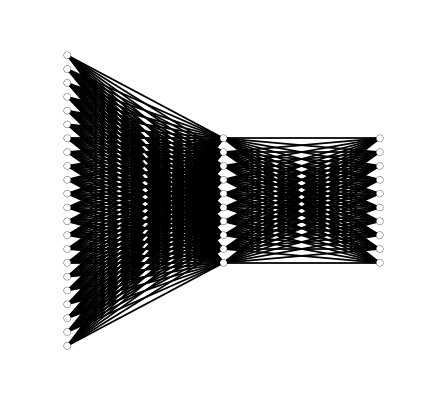

Confusion Matrix:

[[  0   0  28   8   0   0   0   0   0   0]
 [  0   0   8 106   0   0   0   9   0   0]
 [  0   0 681   1   0   0   0   0   0   0]
 [  0   0 100 125   0   0   0   0   0   0]
 [  0   0   1  16   0   0   0   2   0   0]
 [  0   0  20  40   0  25   0   1   0   0]
 [  0   0   1  21   0   0   0   1   0   0]
 [  0   0   6  42   0   0   0  82   0   0]
 [  0   0  43   7   0   0   0  11   0   0]
 [  0   0  10  41   0   0   0   3   0   0]]


Species Accuracy Precision Recall F1-score 0 97.50% nan% 0.00% nan% 1 91.45% nan% 0.00% nan% 2 84.85% 75.84% 99.85% 86.20% 3 73.45% 30.71% 55.56% 39.56% 4 98.68% nan% 0.00% nan% 5 95.76% 100.00% 29.07% 45.05% 6 98.40% nan% 0.00% nan% 7 94.79% 75.23% 63.08% 68.62% 8 95.76% nan% 0.00% nan% 9 96.25% nan% 0.00% nan% Average 92.69% 70.44% 24.76% 59.86%

Iteration 2

Hidden Layers Training Fraction Number of Steps [10] 50% 100

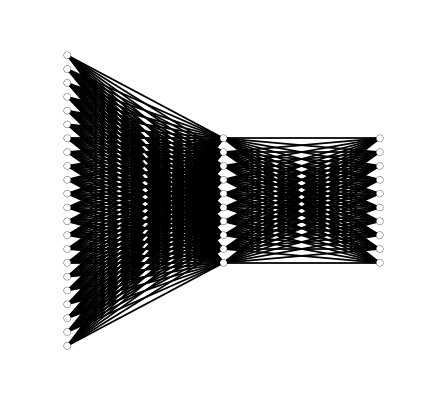

Confusion Matrix:

[[   0    0   60   17    0    0    0    0    0    0]
 [   0  115   42  113    0    0    0    0    0    0]
 [   0    0 1730    1    0    0    0    0    0    0]
 [   0    0  320  246    0    0    0    0    0    0]
 [   0    0    3   30    0    0    0    0    0    0]
 [   0    0  156   74    0   13    0    0    0    0]
 [   0    0    5   37    0    1    0    0    0    0]
 [   0   83    8  261    0    0    0    0    0    0]
 [   0   38   89   26    0    0    0    0    0    0]
 [   0    0    9  120    0    0    0    0    0    0]]


Species Accuracy Precision Recall F1-score 0 97.86% nan% 0.00% nan% 1 92.33% 48.73% 42.59% 45.45% 2 80.73% 71.43% 99.94% 83.31% 3 72.23% 26.59% 43.46% 33.00% 4 99.08% nan% 0.00% nan% 5 93.58% 92.86% 5.35% 10.12% 6 98.80% nan% 0.00% nan% 7 90.21% nan% 0.00% nan% 8 95.75% nan% 0.00% nan% 9 96.41% nan% 0.00% nan% Average 91.70% 59.90% 19.13% 42.97%

Iteration 3

Hidden Layers Training Fraction Number of Steps [10] 80% 200

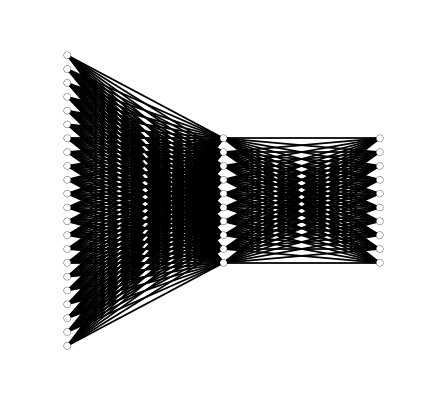

Confusion Matrix:

[[  0   0  14   8   0   1   0   0   0   0]
 [  0  14   0  39   0   0   0  59   0   0]
 [  0   0 710   1   0   0   0   0   0   0]
 [  0   0   3 218   0   0   0   0   0   0]
 [  0   0   0  11   0   0   0   0   0   0]
 [  0   0   0  19   0  71   0   3   0   0]
 [  0   0   0  19   0   1   0   1   0   0]
 [  0   1   0   3   0   0   0 134   0   0]
 [  0   2  31  10   0   0   0  18   0   0]
 [  0   0   0  47   0   0   0   1   0   0]]


Species Accuracy Precision Recall F1-score 0 98.40% nan% 0.00% nan% 1 92.98% 82.35% 12.50% 21.71% 2 96.59% 93.67% 99.86% 96.66% 3 88.88% 58.13% 98.64% 73.15% 4 99.24% nan% 0.00% nan% 5 98.33% 97.26% 76.34% 85.54% 6 98.54% nan% 0.00% nan% 7 94.02% 62.04% 97.10% 75.71% 8 95.76% nan% 0.00% nan% 9 96.66% nan% 0.00% nan% Average 95.94% 78.69% 38.44% 70.55%

Iteration 4

Hidden Layers Training Fraction Number of Steps [10] 50% 200

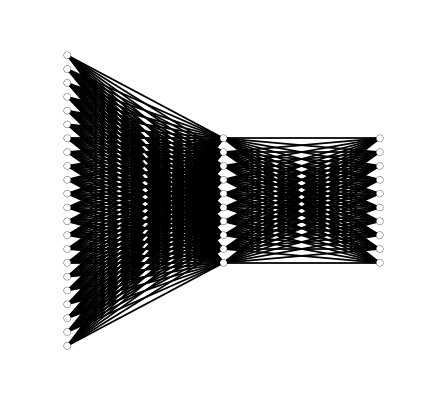

Confusion Matrix:

[[   0    0   46   22    0    0    0    2    0    0]
 [   0  105    0   39    0    0    0  121    0    0]
 [   0    0 1721    4    0    1    0    0    0    0]
 [   0    0   24  537    0    0    0    1    0    0]
 [   0    0    0   32    0    0    0    2    0    0]
 [   0    0   38   80    0  119    0   22    0    0]
 [   0    0    0   37    0    9    0    3    0    0]
 [   0   12    0   12    0    0    0  308    0    0]
 [   0   11   72   26    0    0    0   44    0    0]
 [   0    0    3  141    0    0    0    3    0    0]]


Species Accuracy Precision Recall F1-score 0 98.05% nan% 0.00% nan% 1 94.91% 82.03% 39.62% 53.44% 2 94.77% 90.39% 99.71% 94.82% 3 88.38% 57.74% 95.55% 71.98% 4 99.05% nan% 0.00% nan% 5 95.83% 92.25% 45.95% 61.34% 6 98.64% nan% 0.00% nan% 7 93.83% 60.87% 92.77% 73.51% 8 95.75% nan% 0.00% nan% 9 95.91% nan% 0.00% nan% Average 95.51% 76.66% 37.36% 71.02%

Iteration 5

Hidden Layers Training Fraction Number of Steps [10] 80% 500

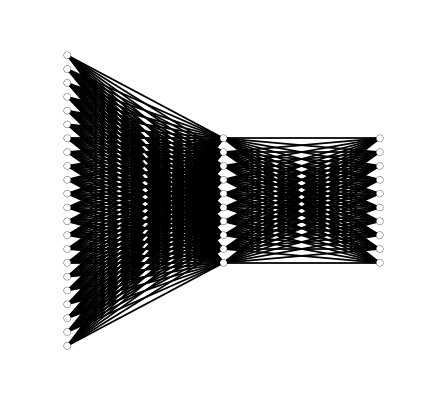

Confusion Matrix:

[[  0   3  12  18   0   0   0   1   0   0]
 [  0  87   0   2   0   0   0  29   0   0]
 [  0   0 673   1   0   0   0   0   0   0]
 [  0   0   0 229   0   0   0   0   0   0]
 [  0   0   0   8   0   0   0   5   0   0]
 [  0   0   0  12   0  80   0   2   0   0]
 [  0   0   0  16   0   4   0   0   0   0]
 [  0   5   0   4   0   0   0 146   0   0]
 [  0  20  23   2   0   0   0  10   7   0]
 [  0   1   0  36   0   0   0   0   0   3]]


Species Accuracy Precision Recall F1-score 0 97.64% nan% 0.00% nan% 1 95.83% 75.00% 73.73% 74.36% 2 97.50% 95.06% 99.85% 97.40% 3 93.12% 69.82% 100.00% 82.23% 4 99.10% nan% 0.00% nan% 5 98.75% 95.24% 85.11% 89.89% 6 98.61% nan% 0.00% nan% 7 96.11% 75.65% 94.19% 83.91% 8 96.18% 100.00% 11.29% 20.29% 9 97.43% 100.00% 7.50% 13.95% Average 97.03% 87.25% 47.17% 66.00%

Iteration 6

Hidden Layers Training Fraction Number of Steps [10] 50% 500

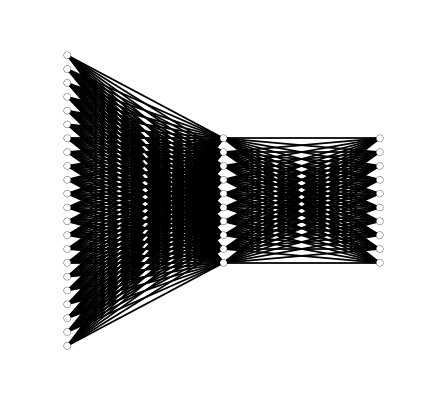

Confusion Matrix:

[[   0    6   40   26    0    5    0    0    0    0]
 [   0  195    0    9    0    0    0   54    0    0]
 [   0    0 1758    2    0    1    0    0    0    0]
 [   0    0    5  523    0    5    0    1    0    0]
 [   0    0    0   24    0    1    0    5    0    0]
 [   0    0    0   16    0  233    0    1    0    0]
 [   0    0    0   45    0   14    0    2    0    0]
 [   0   15    0    3    0    1    0  317    0    0]
 [   0   35   44   10    0    0    0   35   33    0]
 [   0    1    1  124    0    0    0    6    1    0]]


Species Accuracy Precision Recall F1-score 0 97.86% nan% 0.00% nan% 1 96.66% 77.38% 75.58% 76.47% 2 97.41% 95.13% 99.83% 97.42% 3 92.49% 66.88% 97.94% 79.48% 4 99.17% nan% 0.00% nan% 5 98.78% 89.62% 93.20% 91.37% 6 98.30% nan% 0.00% nan% 7 96.58% 75.30% 94.35% 83.75% 8 96.52% 97.06% 21.02% 34.55% 9 96.30% nan% 0.00% nan% Average 97.01% 83.56% 48.19% 77.18%

Iteration 7

Hidden Layers Training Fraction Number of Steps [10] 80% 1000

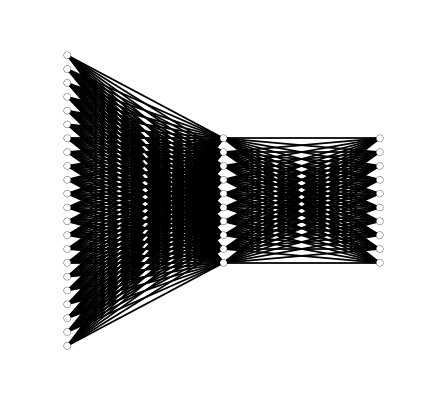

Confusion Matrix:

[[  0   4  19  12   0   1   0   1   0   0]
 [  0  96   0   5   0   0   0  20   0   0]
 [  0   0 669   0   0   0   0   0   0   0]
 [  0   0   1 226   0   2   0   0   0   2]
 [  0   0   0  13   0   0   0   3   0   0]
 [  0   0   0   2   0  98   0   1   0   0]
 [  0   0   0  16   0   3   0   0   0   0]
 [  0   7   0   1   0   3   0 122   0   0]
 [  0  10  13   1   0   0   0  10  20   0]
 [  0   0   0  25   0   0   0   5   2  26]]


Species Accuracy Precision Recall F1-score 0 97.43% nan% 0.00% nan% 1 96.80% 82.05% 79.34% 80.67% 2 97.71% 95.30% 100.00% 97.59% 3 94.44% 75.08% 97.84% 84.96% 4 98.89% nan% 0.00% nan% 5 99.17% 91.59% 97.03% 94.23% 6 98.68% nan% 0.00% nan% 7 96.46% 75.31% 91.73% 82.71% 8 97.50% 90.91% 37.04% 52.63% 9 97.64% 92.86% 44.83% 60.47% Average 97.47% 86.16% 54.78% 79.04%

Iteration 8

Hidden Layers Training Fraction Number of Steps [10] 50% 1000

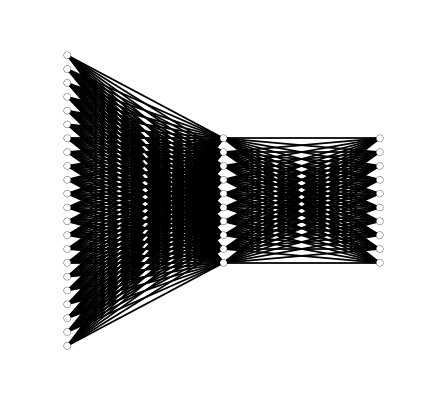

Confusion Matrix:

[[   0    0   28   35    0    6    0    2    3    0]
 [   0  241    0    6    0    0    0   33    0    0]
 [   0    1 1725    1    0    1    0    0    0    0]
 [   0    0    6  557    0    2    0    0    0    4]
 [   0   21    0    8    0    0    0    6    0    1]
 [   0    0    0    8    0  219    0    7    0    5]
 [   0    0    0   39    0    9    0    2    0    3]
 [   0   20    0    5    0    3    0  306    0    1]
 [   0   30   36    6    0    0    0   29   49    0]
 [   0    0    1   27    0    0    0    3    1  101]]


Species Accuracy Precision Recall F1-score 0 97.94% nan% 0.00% nan% 1 96.91% 77.00% 86.07% 81.28% 2 97.94% 96.05% 99.83% 97.90% 3 95.91% 80.49% 97.89% 88.34% 4 99.00% nan% 0.00% nan% 5 98.86% 91.25% 91.63% 91.44% 6 98.53% nan% 0.00% nan% 7 96.91% 78.87% 91.34% 84.65% 8 97.08% 92.45% 32.67% 48.28% 9 98.72% 87.83% 75.94% 81.45% Average 97.78% 86.28% 57.54% 81.91%

Iteration 9

Hidden Layers Training Fraction Number of Steps [10] 80% 1500

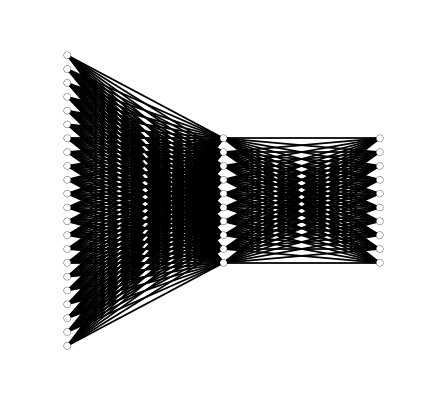

Confusion Matrix:

[[  1   4  10   7   0   1   0   0   0   0]
 [  0  85   0   0   0   0   0   9   0   0]
 [  0   0 691   1   0   1   0   0   0   0]
 [  0   0   0 227   0   1   0   0   0   4]
 [  0  13   0   4   0   0   0   1   0   1]
 [  0   0   0   0   0 104   0   0   0   3]
 [  0   0   0  11   0   5   0   0   0   3]
 [  0  12   0   0   0   0   0 122   0   0]
 [  0   9  15   0   0   0   0  16  23   0]
 [  0   0   1   3   0   1   0   0   1  49]]


Species Accuracy Precision Recall F1-score 0 98.47% 100.00% 4.35% 8.33% 1 96.73% 69.11% 90.43% 78.34% 2 98.05% 96.37% 99.71% 98.01% 3 97.85% 89.72% 97.84% 93.61% 4 98.68% nan% 0.00% nan% 5 99.17% 92.04% 97.20% 94.55% 6 98.68% nan% 0.00% nan% 7 97.36% 82.43% 91.04% 86.52% 8 97.15% 95.83% 36.51% 52.87% 9 98.82% 81.67% 89.09% 85.22% Average 98.10% 88.40% 60.62% 74.68%

Iteration 10

Hidden Layers Training Fraction Number of Steps [10] 50% 1500

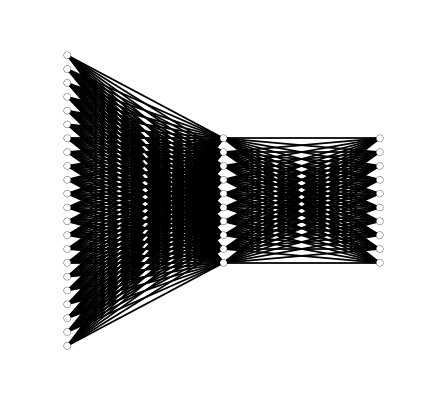

Confusion Matrix:

[[   6    9   25   30    0    7    0    1    1    0]
 [   0  270    0    2    0    0    0   10    8    0]
 [   0    0 1712    3    0    2    0    0    1    0]
 [   0    0    4  546    0    3    0    0    1    6]
 [   0   11    0   17    0    2    0    5    0    2]
 [   0    0    0    6    0  226    0    0    0    8]
 [   0    0    0   42    0   18    0    0    0    1]
 [   0   24    0    4    0    1    0  293    0    0]
 [   0   36   27    5    0    0    0   23   60    0]
 [   0    0    2   20    0    0    0    4    2  111]]


Species Accuracy Precision Recall F1-score 0 97.97% 100.00% 7.59% 14.12% 1 97.22% 77.14% 93.10% 84.38% 2 98.22% 96.72% 99.65% 98.17% 3 96.02% 80.89% 97.50% 88.42% 4 98.97% nan% 0.00% nan% 5 98.69% 87.26% 94.17% 90.58% 6 98.30% nan% 0.00% nan% 7 98.00% 87.20% 90.99% 89.06% 8 97.11% 82.19% 39.74% 53.57% 9 98.75% 86.72% 79.86% 83.15% Average 97.93% 87.27% 60.26% 75.18%

Iteration 11

Hidden Layers Training Fraction Number of Steps [10] 80% 2000

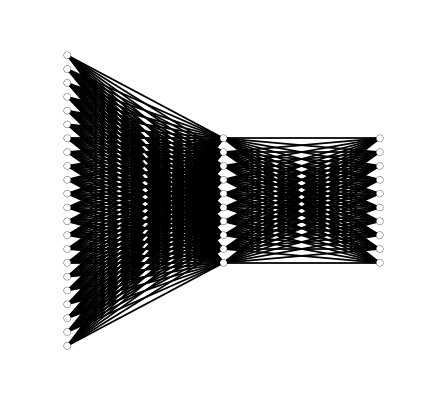

Confusion Matrix:

[[  4   3   6   8   0   4   0   1  10   0]
 [  0  85   0   0   0   0   0   2   1   0]
 [  0   0 704   0   0   1   0   0   1   0]
 [  0   0   1 225   0   0   0   0   0   3]
 [  0  10   0   3   0   0   0   2   0   0]
 [  0   0   0   1   0 100   0   0   0   4]
 [  0   0   0  14   0   4   0   2   0   0]
 [  0   6   0   0   0   3   0 118   0   0]
 [  0  10   5   1   0   0   0  13  27   0]
 [  0   1   0   4   0   1   0   1   1  49]]


Species Accuracy Precision Recall F1-score 0 97.78% 100.00% 11.11% 20.00% 1 97.71% 73.91% 96.59% 83.74% 2 99.03% 98.32% 99.72% 99.02% 3 97.57% 87.89% 98.25% 92.78% 4 98.96% nan% 0.00% nan% 5 98.75% 88.50% 95.24% 91.74% 6 98.61% nan% 0.00% nan% 7 97.92% 84.89% 92.91% 88.72% 8 97.08% 67.50% 48.21% 56.25% 9 98.96% 87.50% 85.96% 86.73% Average 98.23% 86.06% 62.80% 77.37%

Iteration 12

Hidden Layers Training Fraction Number of Steps [10] 50% 2000

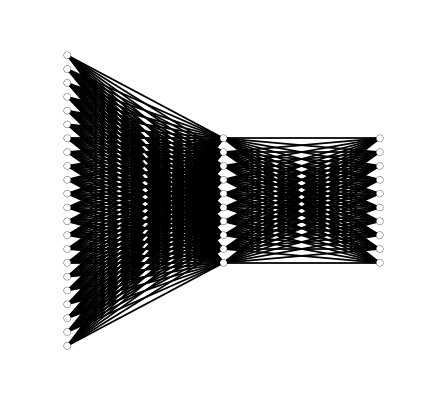

Confusion Matrix:

[[  14   11   14   15    0   17    1    1    5    0]
 [   0  260    0    1    0    0    0    4    8    0]
 [   0    0 1750    0    0    1    0    0    2    0]
 [   0    0    3  527    0    3    1    0    1   16]
 [   0   24    0    4    0    3    0    1    0    1]
 [   0    0    0    5    0  233    3    2    0    6]
 [   0    0    0   34    0   16    3    1    0    1]
 [   0   11    0    3    0    7    0  309    0    0]
 [   0   16   25    3    0    0    0   23   75    0]
 [   0    0    2    9    0    3    0    3    5  111]]


Species Accuracy Precision Recall F1-score 0 98.22% 100.00% 17.95% 30.43% 1 97.91% 80.75% 95.24% 87.39% 2 98.69% 97.55% 99.83% 98.67% 3 97.28% 87.69% 95.64% 91.49% 4 99.08% nan% 0.00% nan% 5 98.17% 82.33% 93.57% 87.59% 6 98.42% 37.50% 5.45% 9.52% 7 98.44% 89.83% 93.64% 91.69% 8 97.55% 78.12% 52.82% 63.03% 9 98.72% 82.22% 83.46% 82.84% Average 98.25% 81.78% 63.76% 71.41%

Iteration 13

Hidden Layers Training Fraction Number of Steps [100] 80% 100

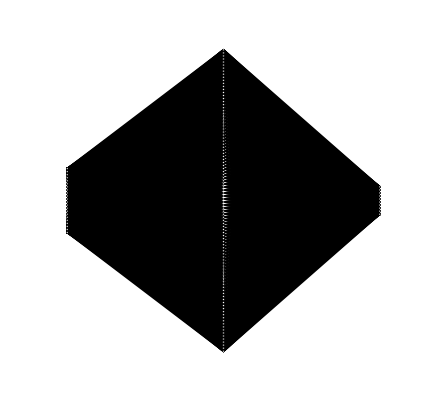

Confusion Matrix:

[[  0   0   6  27   0   0   0   0   0   0]
 [  0  79   0  13   0   0   0  19   0   0]
 [  0   0 660   3   0   0   0   0   0   0]
 [  0   0   2 225   0   0   0   0   0   0]
 [  0   0   0  19   0   1   0   3   0   0]
 [  0   0   0  13   0  79   0   4   0   0]
 [  0   0   0  21   0   3   0   0   0   0]
 [  0   8   0   2   0   0   0 133   0   0]
 [  0  16  25  16   0   0   0   3   0   0]
 [  0   0   1  56   0   0   0   2   0   0]]


Species Accuracy Precision Recall F1-score 0 97.71% nan% 0.00% nan% 1 96.11% 76.70% 71.17% 73.83% 2 97.43% 95.10% 99.55% 97.27% 3 88.05% 56.96% 99.12% 72.35% 4 98.40% nan% 0.00% nan% 5 98.54% 95.18% 82.29% 88.27% 6 98.33% nan% 0.00% nan% 7 97.15% 81.10% 93.01% 86.64% 8 95.83% nan% 0.00% nan% 9 95.90% nan% 0.00% nan% Average 96.34% 81.01% 44.51% 83.67%

Iteration 14

Hidden Layers Training Fraction Number of Steps [100] 50% 100

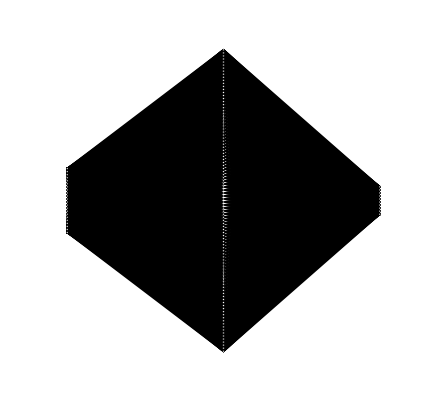

Confusion Matrix:

[[   0    0   30   43    0    2    0    2    0    0]
 [   0  104    0   27    0    0    0  118    0    0]
 [   0    0 1761    4    0    0    0    2    0    0]
 [   0    0    3  563    0    0    0    3    0    0]
 [   0    0    0    9    0    0    0   28    0    0]
 [   0    0    0   23    0  209    0   13    0    0]
 [   0    0    0   23    0    9    0   16    0    0]
 [   0    7    0    3    0    0    0  311    0    0]
 [   0   16   47   14    0    0    0   47   30    0]
 [   0    1    1  111    0    0    0   10    1    6]]


Species Accuracy Precision Recall F1-score 0 97.86% nan% 0.00% nan% 1 95.30% 81.25% 41.77% 55.17% 2 97.58% 95.60% 99.66% 97.59% 3 92.69% 68.66% 98.95% 81.07% 4 98.97% nan% 0.00% nan% 5 98.69% 95.00% 85.31% 89.89% 6 98.67% nan% 0.00% nan% 7 93.08% 56.55% 96.88% 71.41% 8 96.52% 96.77% 19.48% 32.43% 9 96.55% 100.00% 4.62% 8.82% Average 96.59% 84.83% 44.67% 62.34%

Iteration 15

Hidden Layers Training Fraction Number of Steps [100] 80% 200

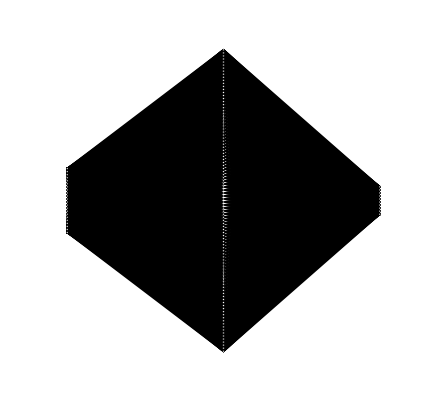

Confusion Matrix:

[[  0   0   7  21   0   1   0   1   2   0]
 [  0  81   0   5   0   0   0  16   0   0]
 [  0   0 732   1   0   0   0   0   0   0]
 [  0   0   1 205   0   2   0   0   0   1]
 [  0   0   0   8   0   1   0   1   0   0]
 [  0   0   0   1   0  87   0   3   0   0]
 [  0   0   0  13   0   4   0   0   0   0]
 [  0   2   0   1   0   1   0 111   0   0]
 [  0   9  16   2   0   0   0  12  24   0]
 [  0   0   0  14   0   0   0   3   3  47]]


Species Accuracy Precision Recall F1-score 0 97.78% nan% 0.00% nan% 1 97.78% 88.04% 79.41% 83.51% 2 98.26% 96.83% 99.86% 98.32% 3 95.14% 75.65% 98.09% 85.42% 4 99.31% nan% 0.00% nan% 5 99.10% 90.62% 95.60% 93.05% 6 98.82% nan% 0.00% nan% 7 97.22% 75.51% 96.52% 84.73% 8 96.94% 82.76% 38.10% 52.17% 9 98.54% 97.92% 70.15% 81.74% Average 97.89% 86.76% 57.77% 82.71%

Iteration 16

Hidden Layers Training Fraction Number of Steps [100] 50% 200

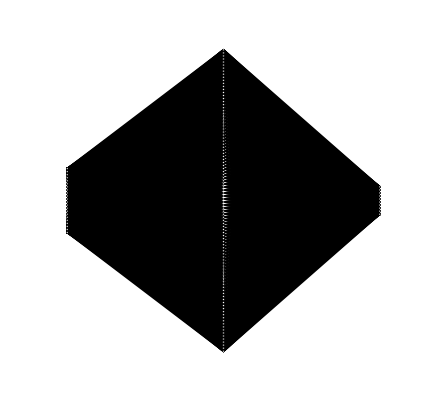

Confusion Matrix:

[[   1    4   15   36    0    4    0    2    0    0]
 [   0  260    0    3    0    0    0   19    0    0]
 [   0    3 1722    3    0    1    0    0    0    0]
 [   0    0    5  543    0    2    0    0    0    4]
 [   0    0    0   36    0    1    0    3    0    0]
 [   0    0    0    7    0  231    0   10    0    1]
 [   0    0    0   49    0    9    0    2    0    0]
 [   0   17    0    2    0    1    0  308    0    0]
 [   0   47   36    8    0    0    0   27   43    0]
 [   0    0    1   35    0    1    0    3    3   89]]


Species Accuracy Precision Recall F1-score 0 98.30% 100.00% 1.61% 3.17% 1 97.41% 78.55% 92.20% 84.83% 2 98.22% 96.80% 99.60% 98.18% 3 94.72% 75.21% 98.01% 85.11% 4 98.89% nan% 0.00% nan% 5 98.97% 92.40% 92.77% 92.59% 6 98.33% nan% 0.00% nan% 7 97.61% 82.35% 93.90% 87.75% 8 96.64% 93.48% 26.71% 41.55% 9 98.67% 94.68% 67.42% 78.76% Average 97.78% 89.18% 57.22% 71.49%

Iteration 17

Hidden Layers Training Fraction Number of Steps [100] 80% 500

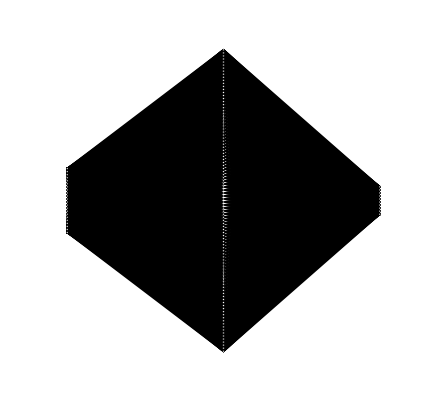

Confusion Matrix:

[[ 21   4   0   4   0   4   0   0   3   0]
 [  0  94   0   1   0   0   0   0   2   0]
 [  0   0 695   0   0   0   0   0   0   0]
 [  0   0   1 221   0   0   0   0   0   3]
 [  0  10   0   5   0   1   0   1   0   0]
 [  0   0   0   2   0  86   1   1   0   1]
 [  0   0   0  15   0  12   3   1   0   0]
 [  0   8   0   0   0   1   1 122   1   0]
 [  1  18   9   0   0   0   0   7  27   0]
 [  0   0   1   1   0   0   0   0   2  48]]


Species Accuracy Precision Recall F1-score 0 98.89% 95.45% 58.33% 72.41% 1 97.01% 70.15% 96.91% 81.39% 2 99.24% 98.44% 100.00% 99.21% 3 97.78% 88.76% 98.22% 93.25% 4 98.82% nan% 0.00% nan% 5 98.40% 82.69% 94.51% 88.21% 6 97.92% 60.00% 9.68% 16.67% 7 98.54% 92.42% 91.73% 92.08% 8 97.01% 77.14% 43.55% 55.67% 9 99.44% 92.31% 92.31% 92.31% Average 98.30% 84.15% 68.52% 76.80%

Iteration 18

Hidden Layers Training Fraction Number of Steps [100] 50% 500

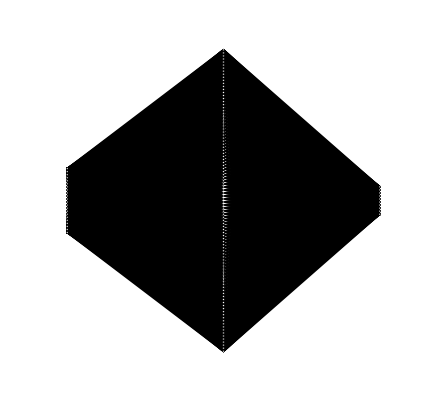

Confusion Matrix:

[[  46    1    2    7    0    6    1    0   12    0]
 [   1  275    0    2    0    0    0    2    7    0]
 [   0    2 1749    2    0    0    0    0    2    0]
 [   0    0    2  544    0    7    0    0    1   10]
 [   1   18    0    9    0    0    0    0    0    2]
 [   0    0    0    5    0  217    0    1    0    1]
 [   0    0    0   43    0    9    2    2    0    0]
 [   0   13    0    1    0    3    0  303    1    0]
 [   1   32   23    4    0    0    0   18   70    0]
 [   0    0    0    8    0    1    0    1    0  127]]


Species Accuracy Precision Recall F1-score 0 99.11% 93.88% 61.33% 74.19% 1 97.83% 80.65% 95.82% 87.58% 2 99.08% 98.48% 99.66% 99.07% 3 97.19% 87.04% 96.45% 91.51% 4 99.17% nan% 0.00% nan% 5 99.08% 89.30% 96.88% 92.93% 6 98.47% 66.67% 3.57% 6.78% 7 98.83% 92.66% 94.39% 93.52% 8 97.19% 75.27% 47.30% 58.09% 9 99.36% 90.71% 92.70% 91.70% Average 98.53% 86.07% 68.81% 77.26%

Iteration 19

Hidden Layers Training Fraction Number of Steps [100] 80% 1000

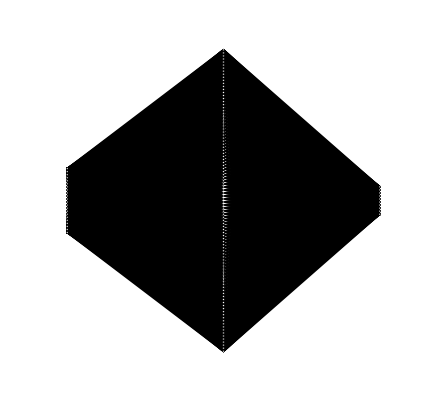

Confusion Matrix:

[[ 27   0   0   2   0   1   0   0   0   0]
 [  0  88   0   0   0   0   0   2   4   0]
 [  0   0 680   0   0   1   0   0   0   0]
 [  0   0   0 218   0   0   1   0   0   2]
 [  1   1   0   1   7   0   0   1   0   0]
 [  0   0   0   1   0  91   3   0   0   2]
 [  0   0   0   8   0   7   6   0   0   0]
 [  0   8   0   0   0   0   3 132   0   0]
 [  1   5  12   4   0   0   0  10  42   0]
 [  0   0   1   1   0   1   0   0   5  59]]


Species Accuracy Precision Recall F1-score 0 99.65% 93.10% 90.00% 91.53% 1 98.61% 86.27% 93.62% 89.80% 2 99.03% 98.12% 99.85% 98.98% 3 98.61% 92.77% 98.64% 95.61% 4 99.72% 100.00% 63.64% 77.78% 5 98.89% 90.10% 93.81% 91.92% 6 98.47% 46.15% 28.57% 35.29% 7 98.33% 91.03% 92.31% 91.67% 8 97.15% 82.35% 56.76% 67.20% 9 99.17% 93.65% 88.06% 90.77% Average 98.76% 87.36% 80.53% 83.05%

Iteration 20

Hidden Layers Training Fraction Number of Steps [100] 50% 1000

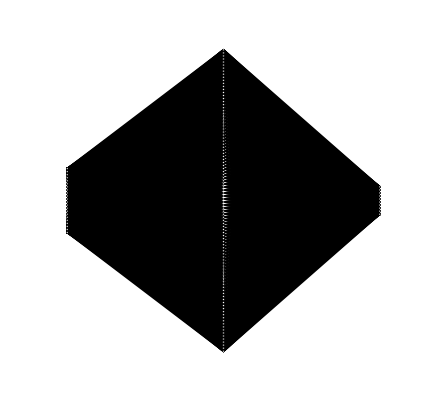

Confusion Matrix:

[[  63    2    0    3    0    2    2    0    3    0]
 [   2  262    0    0    0    0    0    5    7    0]
 [   0    1 1742    2    0    1    0    0    1    0]
 [   0    0    1  537    0    4    1    0    1    4]
 [   2    3    0    1   14    0    1   12    0    4]
 [   0    0    0    1    0  225    6    0    0   10]
 [   0    0    0   18    1   10   23    1    0    0]
 [   0    9    0    3    0    2    1  307    1    0]
 [   1   11   21    1    0    0    0   25   97    0]
 [   0    0    0    7    0    1    0    2    1  129]]


Species Accuracy Precision Recall F1-score 0 99.53% 92.65% 84.00% 88.11% 1 98.89% 90.97% 94.93% 92.91% 2 99.25% 98.75% 99.71% 99.23% 3 98.69% 93.72% 97.99% 95.81% 4 99.33% 93.33% 37.84% 53.85% 5 98.97% 91.84% 92.98% 92.40% 6 98.86% 67.65% 43.40% 52.87% 7 98.30% 87.22% 95.05% 90.96% 8 97.97% 87.39% 62.18% 72.66% 9 99.19% 87.76% 92.14% 89.90% Average 98.90% 89.13% 80.02% 82.87%

Iteration 21

Hidden Layers Training Fraction Number of Steps [100] 80% 1500

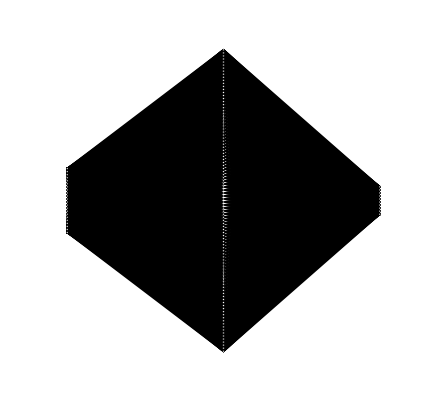

Confusion Matrix:

[[ 18   0   0   0   0   0   0   0   1   0]
 [  1  96   0   0   0   0   0   2  10   0]
 [  0   0 707   1   0   0   0   0   0   0]
 [  0   0   1 204   0   1   0   0   0   4]
 [  0   1   0   1  10   0   0   0   1   0]
 [  0   0   0   2   0  97   2   0   0   2]
 [  0   0   0   3   1   1  12   0   0   0]
 [  0   8   0   2   0   0   1 128   0   0]
 [  0   5   4   0   0   0   0   7  52   0]
 [  0   0   0   1   0   1   0   0   3  48]]


Species Accuracy Precision Recall F1-score 0 99.86% 94.74% 94.74% 94.74% 1 98.12% 87.27% 88.07% 87.67% 2 99.58% 99.30% 99.86% 99.58% 3 98.89% 95.33% 97.14% 96.23% 4 99.72% 90.91% 76.92% 83.33% 5 99.37% 97.00% 94.17% 95.57% 6 99.44% 80.00% 70.59% 75.00% 7 98.61% 93.43% 92.09% 92.75% 8 97.85% 77.61% 76.47% 77.04% 9 99.24% 88.89% 90.57% 89.72% Average 99.07% 90.45% 88.06% 89.16%

Iteration 22

Hidden Layers Training Fraction Number of Steps [100] 50% 1500

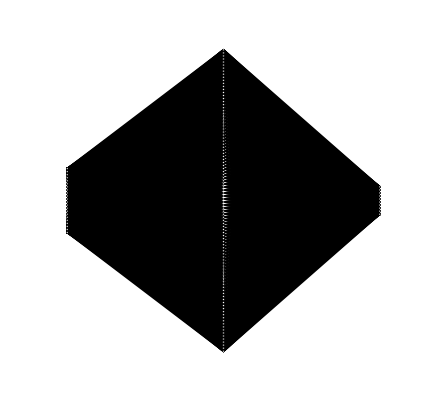

Confusion Matrix:

[[  72    0    0    0    0    1    3    1    1    0]
 [   1  260    0    0    0    0    0    3   10    0]
 [   1    0 1745    0    0    1    0    0    3    0]
 [   1    0    1  524    0    1    1    0    1    5]
 [   2    1    0    0   26    1    0    2    0    2]
 [   0    0    0    1    0  249    7    1    0    1]
 [   0    1    0    7    1    8   32    0    0    0]
 [   0   11    0    1    0    0    3  314    2    0]
 [   0    9   16    2    0    0    0   13  113    0]
 [   0    0    0    3    0    4    0    3    2  123]]


Species Accuracy Precision Recall F1-score 0 99.69% 93.51% 92.31% 92.90% 1 99.00% 92.20% 94.89% 93.53% 2 99.39% 99.04% 99.71% 99.37% 3 99.33% 97.40% 98.13% 97.76% 4 99.75% 96.30% 76.47% 85.25% 5 99.28% 93.96% 96.14% 95.04% 6 99.14% 69.57% 65.31% 67.37% 7 98.89% 93.18% 94.86% 94.01% 8 98.36% 85.61% 73.86% 79.30% 9 99.44% 93.89% 91.11% 92.48% Average 99.23% 91.46% 88.28% 89.70%

Iteration 23

Hidden Layers Training Fraction Number of Steps [100] 80% 2000

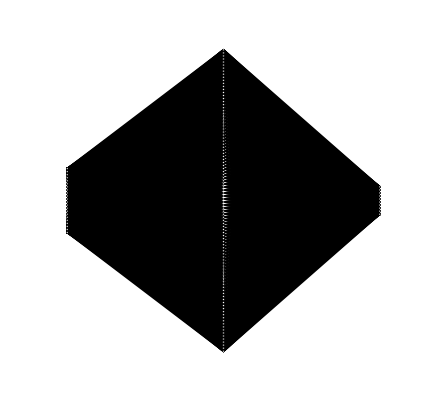

Confusion Matrix:

[[ 22   0   0   0   0   0   1   1   0   0]
 [  0  93   0   0   0   0   0   2   4   0]
 [  0   0 730   0   0   0   0   0   0   0]
 [  1   0   0 208   0   2   2   0   1   3]
 [  0   1   0   0  10   0   0   2   0   2]
 [  0   0   0   1   0  93   2   0   0   0]
 [  0   0   0   1   0   2  13   0   0   0]
 [  0   6   0   1   0   1   1 120   1   0]
 [  0   2   8   0   0   0   0   7  39   0]
 [  0   0   0   1   0   1   0   2   3  49]]


Species Accuracy Precision Recall F1-score 0 99.79% 95.65% 91.67% 93.62% 1 98.96% 91.18% 93.94% 92.54% 2 99.44% 98.92% 100.00% 99.46% 3 99.10% 98.11% 95.85% 96.97% 4 99.65% 100.00% 66.67% 80.00% 5 99.37% 93.94% 96.88% 95.38% 6 99.37% 68.42% 81.25% 74.29% 7 98.33% 89.55% 92.31% 90.91% 8 98.19% 81.25% 69.64% 75.00% 9 99.17% 90.74% 87.50% 89.09% Average 99.14% 90.78% 87.57% 88.72%

Iteration 24

Hidden Layers Training Fraction Number of Steps [100] 50% 2000

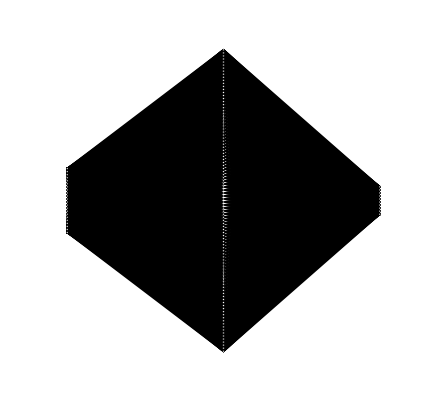

Confusion Matrix:

[[  58    0    0    1    2    0    3    1    2    0]
 [   3  252    0    0    0    0    0    6    8    0]
 [   1    0 1732    0    2    0    1    0    2    0]
 [   1    0    1  556    0    1    1    0    2    7]
 [   0    1    0    0   22    1    0    1    0    3]
 [   0    0    0    3    0  230    5    1    0    5]
 [   0    0    0    6    1   14   38    0    0    0]
 [   0   13    0    5    0    0    2  301    2    0]
 [   1   15   19    5    0    0    0   28  105    0]
 [   0    0    0    2    1    1    0    3    2  118]]


Species Accuracy Precision Recall F1-score 0 99.58% 90.62% 86.57% 88.55% 1 98.72% 89.68% 93.68% 91.64% 2 99.28% 98.86% 99.65% 99.26% 3 99.03% 96.19% 97.72% 96.95% 4 99.67% 78.57% 78.57% 78.57% 5 99.14% 93.12% 94.26% 93.69% 6 99.08% 76.00% 64.41% 69.72% 7 98.28% 88.27% 93.19% 90.66% 8 97.61% 85.37% 60.69% 70.95% 9 99.33% 88.72% 92.91% 90.77% Average 98.97% 88.54% 86.17% 87.07%

Iteration 25

Hidden Layers Training Fraction Number of Steps [10, 10] 80% 100

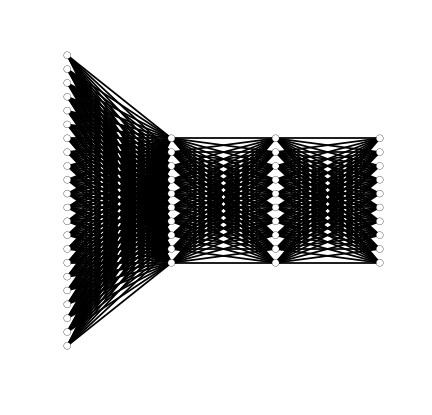

Confusion Matrix:

[[  0   0  17  17   0   0   0   0   0   0]
 [  0   0   0 108   0   0   0   0   0   0]
 [  0   0 672   0   0   0   0   0   0   0]
 [  0   0   6 237   0   0   0   0   0   0]
 [  0   0   0  19   0   0   0   1   0   0]
 [  0   0   0  91   0   0   0   1   0   0]
 [  0   0   0  25   0   0   0   1   0   0]
 [  0   0   0 110   0   0   0  22   0   0]
 [  0   0  26  30   0   0   0   2   0   0]
 [  0   0   2  52   0   0   0   0   0   0]]


Species Accuracy Precision Recall F1-score 0 97.64% nan% 0.00% nan% 1 92.49% nan% 0.00% nan% 2 96.46% 92.95% 100.00% 96.34% 3 68.17% 34.40% 97.53% 50.86% 4 98.61% nan% 0.00% nan% 5 93.61% nan% 0.00% nan% 6 98.19% nan% 0.00% nan% 7 92.01% 81.48% 16.67% 27.67% 8 95.97% nan% 0.00% nan% 9 96.25% nan% 0.00% nan% Average 92.94% 69.61% 21.42% 58.29%

Iteration 26

Hidden Layers Training Fraction Number of Steps [10, 10] 50% 100

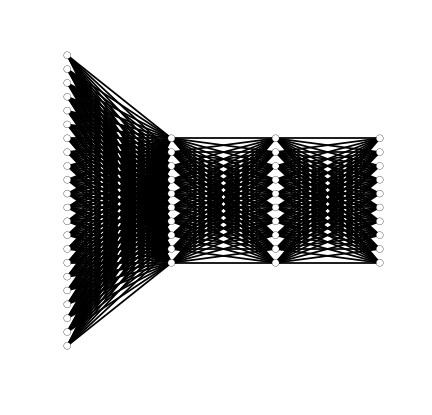

Confusion Matrix:

[[   0    0   51   27    0    0    0    0    0    0]
 [   0    0    0  268    0    0    0    7    0    0]
 [   0    0 1719    6    0    0    0    0    0    0]
 [   0    0   28  535    0    0    0    0    0    0]
 [   0    0    0   31    0    0    0    1    0    0]
 [   0    0    2  244    0    0    0    3    0    0]
 [   0    0    0   52    0    0    0    1    0    0]
 [   0    0    0  225    0    0    0  114    0    0]
 [   0    0   73   46    0    0    0   38    0    0]
 [   0    0    6  120    0    0    0    0    0    0]]


Species Accuracy Precision Recall F1-score 0 97.83% nan% 0.00% nan% 1 92.35% nan% 0.00% nan% 2 95.39% 91.48% 99.65% 95.39% 3 70.89% 34.43% 95.03% 50.54% 4 99.11% nan% 0.00% nan% 5 93.08% nan% 0.00% nan% 6 98.53% nan% 0.00% nan% 7 92.35% 69.51% 33.63% 45.33% 8 95.64% nan% 0.00% nan% 9 96.50% nan% 0.00% nan% Average 93.17% 65.14% 22.83% 63.76%

Iteration 27

Hidden Layers Training Fraction Number of Steps [10, 10] 80% 200

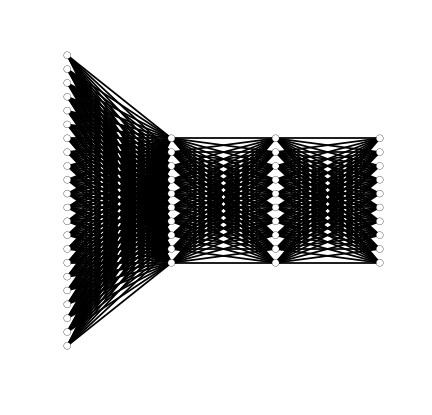

Confusion Matrix:

[[  0   0   5  26   0   0   0   2   0   0]
 [  0   0   0  63   0   0   0  46   0   0]
 [  0   0 675   3   0   0   0   0   0   0]
 [  0   0   2 221   0   0   0   1   0   0]
 [  0   0   0  14   0   0   0   1   0   0]
 [  0   0   0  72   0   0   0  27   0   0]
 [  0   0   0   8   0   0   0  12   0   0]
 [  0   0   0  18   0   0   0 121   0   0]
 [  0   0  15  28   0   0   0  20   0   0]
 [  0   0   0  49   0   0   0  10   0   0]]


Species Accuracy Precision Recall F1-score 0 97.71% nan% 0.00% nan% 1 92.43% nan% 0.00% nan% 2 98.26% 96.84% 99.56% 98.18% 3 80.26% 44.02% 98.66% 60.88% 4 98.96% nan% 0.00% nan% 5 93.12% nan% 0.00% nan% 6 98.61% nan% 0.00% nan% 7 90.48% 50.42% 87.05% 63.85% 8 95.62% nan% 0.00% nan% 9 95.90% nan% 0.00% nan% Average 94.13% 63.76% 28.53% 74.31%

Iteration 28

Hidden Layers Training Fraction Number of Steps [10, 10] 50% 200

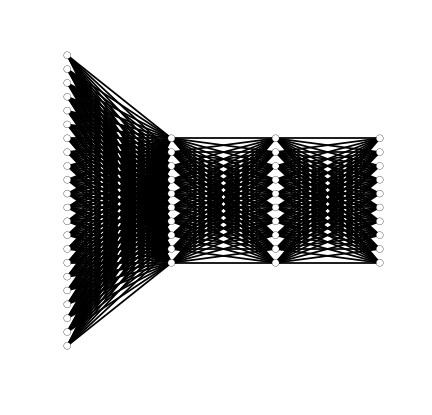

Confusion Matrix:

[[   0    0   28   38    0    0    0    1    0    0]
 [   0    0    0  104    0    0    0  171    0    0]
 [   0    0 1741    5    0    0    0    0    0    0]
 [   0    0   17  525    0    0    0    1    0    0]
 [   0    0    0   34    0    0    0    3    0    0]
 [   0    0    0  236    0    0    0    4    0    0]
 [   0    0    0   61    0    0    0    2    0    0]
 [   0    0    0   20    0    0    0  308    0    0]
 [   0    0   52   45    0    0    0   59    0    0]
 [   0    0    2  131    0    0    0    9    0    0]]


Species Accuracy Precision Recall F1-score 0 98.14% nan% 0.00% nan% 1 92.35% nan% 0.00% nan% 2 97.11% 94.62% 99.71% 97.10% 3 80.76% 43.79% 96.69% 60.28% 4 98.97% nan% 0.00% nan% 5 93.33% nan% 0.00% nan% 6 98.25% nan% 0.00% nan% 7 92.49% 55.20% 93.90% 69.53% 8 95.66% nan% 0.00% nan% 9 96.05% nan% 0.00% nan% Average 94.31% 64.53% 29.03% 75.63%

Iteration 29

Hidden Layers Training Fraction Number of Steps [10, 10] 80% 500

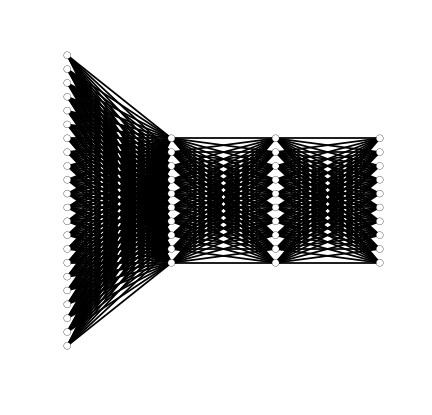

Confusion Matrix:

[[  0   1   4  24   0   1   0   1   0   0]
 [  0  26   0  25   0   0   0  51   0   0]
 [  0   0 697   1   0   1   0   0   0   0]
 [  0   0   2 229   0   1   0   3   0   0]
 [  0   0   0   2   0   0   0   9   0   0]
 [  0   0   0   5   0  92   0   5   0   0]
 [  0   0   0   2   0   7   0  13   0   0]
 [  0   0   0   1   0   0   0 112   0   0]
 [  0   2   8  33   0   0   0  16   0   0]
 [  0   0   0  62   0   0   0   3   0   0]]


Species Accuracy Precision Recall F1-score 0 97.85% nan% 0.00% nan% 1 94.51% 89.66% 25.49% 39.69% 2 98.89% 98.03% 99.71% 98.87% 3 88.81% 59.64% 97.45% 73.99% 4 99.24% nan% 0.00% nan% 5 98.61% 90.20% 90.20% 90.20% 6 98.47% nan% 0.00% nan% 7 92.91% 52.58% 99.12% 68.71% 8 95.90% nan% 0.00% nan% 9 95.48% nan% 0.00% nan% Average 96.07% 78.02% 41.20% 74.29%

Iteration 30

Hidden Layers Training Fraction Number of Steps [10, 10] 50% 500

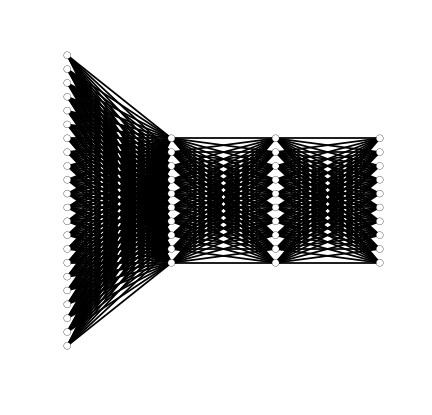

Confusion Matrix:

[[   0    0   20   62    0    0    0    5    0    0]
 [   0    0    0   79    0    0    0  181    0    0]
 [   0    0 1704    2    0    0    0    0    0    0]
 [   0    0   20  530    0    0    0    0    0    0]
 [   0    0    0   32    0    0    0    5    0    0]
 [   0    0    0   82    0  151    0    9    0    0]
 [   0    0    0   39    0    5    0   17    0    0]
 [   0    0    0   10    0    0    0  337    0    0]
 [   0    0   37   72    0    0    0   55    0    0]
 [   0    0    1  127    0    0    0   15    0    0]]


Species Accuracy Precision Recall F1-score 0 97.58% nan% 0.00% nan% 1 92.77% nan% 0.00% nan% 2 97.78% 95.62% 99.88% 97.71% 3 85.40% 51.21% 96.36% 66.88% 4 98.97% nan% 0.00% nan% 5 97.33% 96.79% 62.40% 75.88% 6 98.30% nan% 0.00% nan% 7 91.74% 54.01% 97.12% 69.41% 8 95.44% nan% 0.00% nan% 9 96.02% nan% 0.00% nan% Average 95.13% 74.41% 35.58% 77.47%

Iteration 31

Hidden Layers Training Fraction Number of Steps [10, 10] 80% 1000

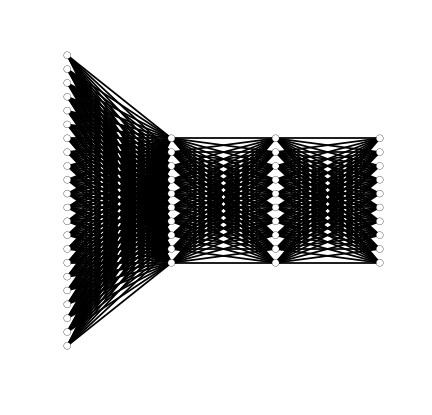

Confusion Matrix:

[[  0   0   5  16   0   8   0   7   0   0]
 [  0   2   0   6   0   0   0 100   0   0]
 [  0   0 691   0   0   0   0   0   0   0]
 [  0   0   3 234   0   2   0   1   0   0]
 [  0  10   0   0   0   1   0   2   0   0]
 [  0   0   0   2   0  87   0   4   0   0]
 [  0   8   0   9   0   7   0   2   0   0]
 [  0   1   0   1   0   2   0 130   0   0]
 [  0   0  14  16   0   0   0  18   0   0]
 [  0   0   0  39   0   0   0  11   0   0]]


Species Accuracy Precision Recall F1-score 0 97.50% nan% 0.00% nan% 1 91.31% 9.52% 1.85% 3.10% 2 98.47% 96.91% 100.00% 98.43% 3 93.40% 72.45% 97.50% 83.13% 4 99.10% nan% 0.00% nan% 5 98.19% 81.31% 93.55% 87.00% 6 98.19% nan% 0.00% nan% 7 89.65% 47.27% 97.01% 63.57% 8 96.66% nan% 0.00% nan% 9 96.53% nan% 0.00% nan% Average 95.90% 61.49% 38.99% 67.05%

Iteration 32

Hidden Layers Training Fraction Number of Steps [10, 10] 50% 1000

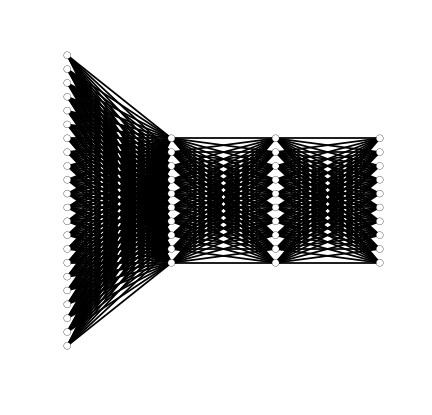

Confusion Matrix:

[[   0    3   15   47    0    9    0    3    0    0]
 [   0   52    0   19    0    0    0  209    0    0]
 [   0    0 1735    2    0    2    0    0    0    0]
 [   0    1    8  542    0    7    0    0    0    0]
 [   0   12    0    1    0    2    0   18    0    0]
 [   0    0    1    5    0  248    0    4    0    0]
 [   0    7    0   23    0   16    0   10    0    0]
 [   0    1    0    1    0    3    0  309    0    0]
 [   0    3   23   78    0    0    0   50    0    0]
 [   0    4    2  109    0    5    0    8    0    0]]


Species Accuracy Precision Recall F1-score 0 97.86% nan% 0.00% nan% 1 92.80% 62.65% 18.57% 28.65% 2 98.53% 97.25% 99.77% 98.50% 3 91.63% 65.54% 97.13% 78.27% 4 99.08% nan% 0.00% nan% 5 98.50% 84.93% 96.12% 90.18% 6 98.44% nan% 0.00% nan% 7 91.47% 50.57% 98.41% 66.81% 8 95.72% nan% 0.00% nan% 9 96.44% nan% 0.00% nan% Average 96.05% 72.19% 41.00% 72.48%

Iteration 33

Hidden Layers Training Fraction Number of Steps [10, 10] 80% 1500

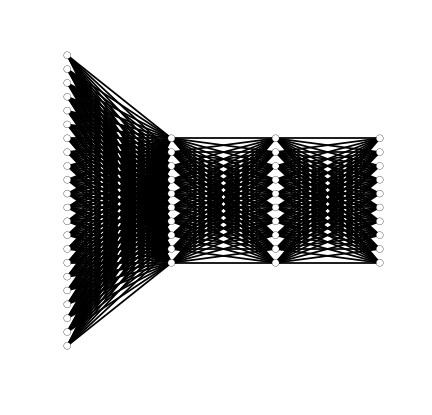

Confusion Matrix:

[[  0   1   4   6   0   7   0   0   1   0]
 [  0  63   0   3   0   0   0  39   1   0]
 [  0   0 713   1   0   2   0   0   0   0]
 [  0   0   0 216   0   2   0   0   0   0]
 [  0  13   0   1   0   3   0   1   0   0]
 [  0   1   0   0   0  90   0   3   0   0]
 [  0   9   0  12   0   5   0   1   0   0]
 [  0   2   0   0   0   2   0 133   0   0]
 [  0   7   5  24   0   0   0   9   6   0]
 [  0   3   0  50   0   0   0   0   0   0]]


Species Accuracy Precision Recall F1-score 0 98.68% nan% 0.00% nan% 1 94.51% 63.64% 59.43% 61.46% 2 99.17% 98.75% 99.58% 99.17% 3 93.12% 69.01% 99.08% 81.36% 4 98.75% nan% 0.00% nan% 5 98.26% 81.08% 95.74% 87.80% 6 98.12% nan% 0.00% nan% 7 96.04% 71.51% 97.08% 82.35% 8 96.73% 75.00% 11.76% 20.34% 9 96.32% nan% 0.00% nan% Average 96.97% 76.50% 46.27% 72.08%

Iteration 34

Hidden Layers Training Fraction Number of Steps [10, 10] 50% 1500

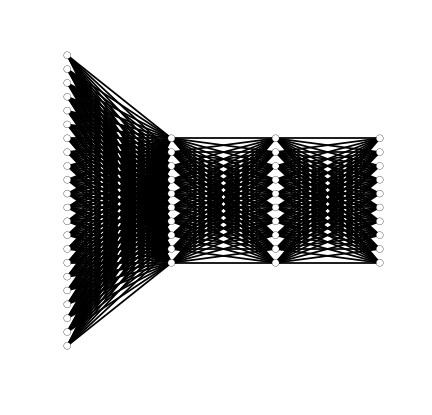

Confusion Matrix:

[[   0    4   16   37    0    1    0    2   13    0]
 [   0  241    0    3    0    0    0    5    2    0]
 [   0    0 1761    5    0    1    0    0    0    0]
 [   0    0    4  532    0   28    0    0    0    0]
 [   0    4    0   12    0    1    0   16    0    0]
 [   0    0    0   12    0  202    0    2    0    0]
 [   0    0    0   14    0   26    0    4    0    0]
 [   0   21    0    0    0    8    0  319    0    0]
 [   0   36   24    1    0    0    0   23   75    0]
 [   0    0    2   96    0   39    0    4    1    0]]


Species Accuracy Precision Recall F1-score 0 97.97% nan% 0.00% nan% 1 97.91% 78.76% 96.02% 86.54% 2 98.55% 97.45% 99.66% 98.55% 3 94.11% 74.72% 94.33% 83.39% 4 99.08% nan% 0.00% nan% 5 96.72% 66.01% 93.52% 77.39% 6 98.78% nan% 0.00% nan% 7 97.64% 85.07% 91.67% 88.24% 8 97.22% 82.42% 47.17% 60.00% 9 96.05% nan% 0.00% nan% Average 97.40% 80.74% 52.24% 82.35%

Iteration 35

Hidden Layers Training Fraction Number of Steps [10, 10] 80% 2000

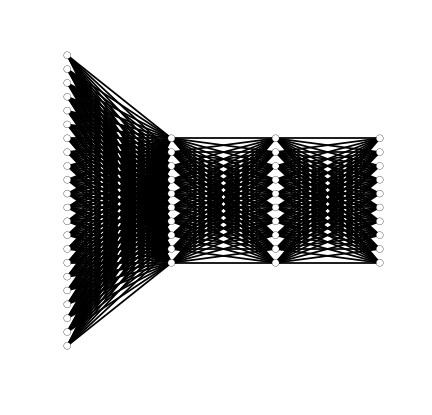

Confusion Matrix:

[[  0   1   4  22   0   0   0   0   4   1]
 [  0 105   0   1   0   0   0   5   0   0]
 [  0   0 678   2   0   0   0   0   1   0]
 [  0   0   3 208   0  14   0   0   0   3]
 [  0   9   0   1   0   0   0   1   0   0]
 [  0   0   0   5   0  95   0   0   0   1]
 [  0   0   0   2   0   4   0   3   0  11]
 [  0   5   0   0   0   0   0 139   0   0]
 [  0  17   8   2   0   0   0   8  23   0]
 [  0   0   0  17   0   0   0   1   1  34]]


Species Accuracy Precision Recall F1-score 0 97.78% nan% 0.00% nan% 1 97.36% 76.64% 94.59% 84.68% 2 98.75% 97.84% 99.56% 98.69% 3 95.00% 80.00% 91.23% 85.25% 4 99.24% nan% 0.00% nan% 5 98.33% 84.07% 94.06% 88.79% 6 98.61% nan% 0.00% nan% 7 98.40% 88.54% 96.53% 92.36% 8 97.15% 79.31% 39.66% 52.87% 9 97.57% 68.00% 64.15% 66.02% Average 97.82% 82.06% 57.98% 81.24%

Iteration 36

Hidden Layers Training Fraction Number of Steps [10, 10] 50% 2000

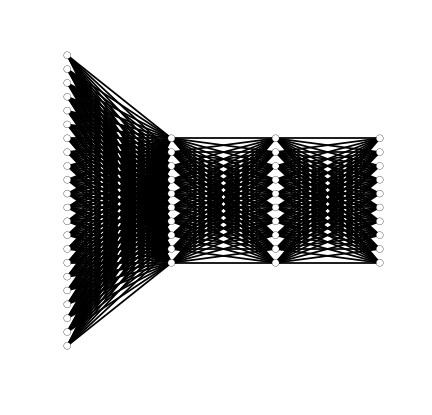

Confusion Matrix:

[[  16    7    8    7    0   19    0    2    5    0]
 [   0  255    0    1    0    1    0    6    2    0]
 [   0    2 1720    1    0    3    0    0    0    0]
 [   0    0    2  562    0    1    0    1    0    1]
 [   0   26    0    0    0    4    0    3    0    0]
 [   0    0    0    7    0  233    0   11    0    3]
 [   0    2    0    7    0   11    0   16    0   14]
 [   0   10    0    2    0    1    0  321    0    2]
 [   0   34   33    2    0    4    0   29   58    0]
 [   0    1    0   50    0    0    0    4    7   80]]


Species Accuracy Precision Recall F1-score 0 98.67% 100.00% 25.00% 40.00% 1 97.44% 75.67% 96.23% 84.72% 2 98.64% 97.56% 99.65% 98.60% 3 97.72% 87.95% 99.12% 93.20% 4 99.08% nan% 0.00% nan% 5 98.19% 84.12% 91.73% 87.76% 6 98.61% nan% 0.00% nan% 7 97.58% 81.68% 95.54% 88.07% 8 96.78% 80.56% 36.25% 50.00% 9 97.72% 80.00% 56.34% 66.12% Average 98.04% 85.94% 59.99% 76.06%

Iteration 37

Hidden Layers Training Fraction Number of Steps [100, 100] 80% 100

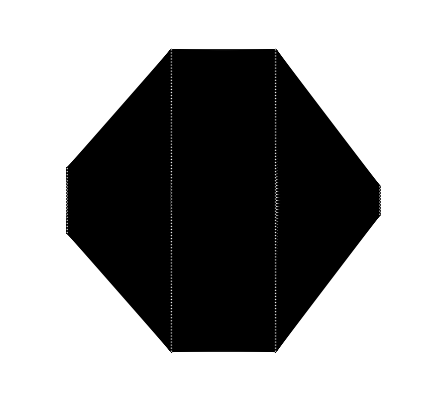

Confusion Matrix:

[[  0   1   1  24   0   0   0   1   0   0]
 [  0  46   0  11   0   0   0  47   0   0]
 [  0   0 693   2   0   0   0   0   0   0]
 [  0   0   4 224   0   2   0   0   0   0]
 [  0   0   0   6   0   1   0   1   0   0]
 [  0   0   0  25   0  68   0   6   0   0]
 [  0   0   0  11   0   2   0   2   0   0]
 [  0   7   0   2   0   0   0 126   0   0]
 [  0   7  25  22   0   0   0  20   0   0]
 [  0   0   0  47   0   0   0   5   0   0]]


Species Accuracy Precision Recall F1-score 0 98.12% nan% 0.00% nan% 1 94.93% 75.41% 44.23% 55.76% 2 97.78% 95.85% 99.71% 97.74% 3 89.16% 59.89% 97.39% 74.17% 4 99.44% nan% 0.00% nan% 5 97.50% 93.15% 68.69% 79.07% 6 98.96% nan% 0.00% nan% 7 93.68% 60.58% 93.33% 73.47% 8 94.86% nan% 0.00% nan% 9 96.39% nan% 0.00% nan% Average 96.08% 76.98% 40.34% 76.04%

Iteration 38

Hidden Layers Training Fraction Number of Steps [100, 100] 50% 100

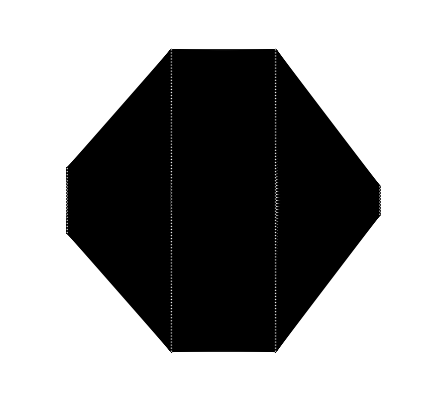

Confusion Matrix:

[[   0    0   14   49    0    1    0    1    0    0]
 [   0  106    0   48    0    0    0  124    0    0]
 [   0    0 1734    4    0    1    0    0    0    0]
 [   0    0   14  523    0   13    0    2    0    0]
 [   0    0    0   26    0    1    0    4    0    0]
 [   0    0    0   36    0  193    0   10    0    0]
 [   0    0    0   34    0   14    0   14    0    0]
 [   0    3    0   13    0    0    0  327    0    0]
 [   0    7   52   47    0    0    0   51    1    0]
 [   0    1    2  116    0    0    0   11    0    0]]


Species Accuracy Precision Recall F1-score 0 98.19% nan% 0.00% nan% 1 94.91% 90.60% 38.13% 53.67% 2 97.58% 95.48% 99.71% 97.55% 3 88.82% 58.37% 94.75% 72.24% 4 99.14% nan% 0.00% nan% 5 97.89% 86.55% 80.75% 83.55% 6 98.28% nan% 0.00% nan% 7 93.52% 60.11% 95.34% 73.73% 8 95.64% 100.00% 0.63% 1.26% 9 96.39% nan% 0.00% nan% Average 96.04% 81.85% 40.93% 63.67%

Iteration 39

Hidden Layers Training Fraction Number of Steps [100, 100] 80% 200

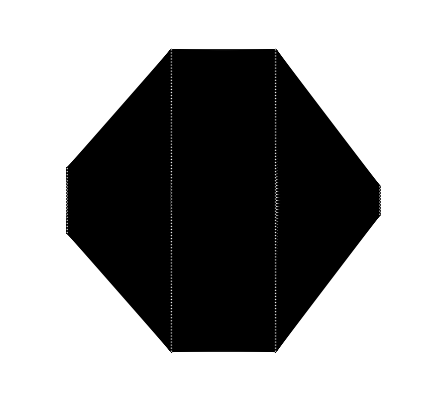

Confusion Matrix:

[[  0   5   2  30   0   1   0   1   1   0]
 [  0  71   0   0   0   0   0  43   0   0]
 [  0   0 677   1   0   1   0   0   1   0]
 [  0   0   2 213   0   3   0   0   0   0]
 [  0   2   0   6   0   1   0   7   0   0]
 [  0   0   0   7   0  68   0   4   0   0]
 [  0   0   0   5   0   8   1  10   0   0]
 [  0  11   0   0   0   2   0 127   0   0]
 [  0  19  13   3   0   0   0   7  21   0]
 [  0   2   0  51   0   3   0   3   2   4]]


Species Accuracy Precision Recall F1-score 0 97.22% nan% 0.00% nan% 1 94.30% 64.55% 62.28% 63.39% 2 98.61% 97.55% 99.56% 98.54% 3 92.49% 67.41% 97.71% 79.78% 4 98.89% nan% 0.00% nan% 5 97.92% 78.16% 86.08% 81.93% 6 98.40% 100.00% 4.17% 8.00% 7 93.88% 62.87% 90.71% 74.27% 8 96.80% 84.00% 33.33% 47.73% 9 95.76% 100.00% 6.15% 11.59% Average 96.43% 81.82% 48.00% 58.15%

Iteration 40

Hidden Layers Training Fraction Number of Steps [100, 100] 50% 200

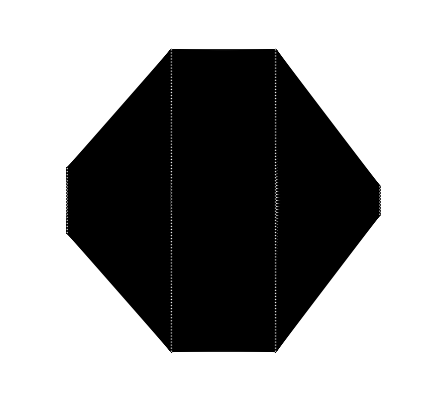

Confusion Matrix:

[[   0    5    4   41    0    0    0    1   10    0]
 [   0  217    0    2    0    0    0   44    7    0]
 [   0    1 1740    2    0    1    0    0    2    0]
 [   0    0    4  508    0   18    0    1    1    0]
 [   0   19    0   12    0    0    0    4    0    0]
 [   0    0    0   12    0  222    0    8    0    1]
 [   0    0    0   29    0   22    0   11    0    4]
 [   0   47    0    0    0    3    0  296    0    0]
 [   0   38   20    5    0    0    0   18   64    0]
 [   0    1    1  132    0    4    0    7    4    4]]


Species Accuracy Precision Recall F1-score 0 98.30% nan% 0.00% nan% 1 95.44% 66.16% 80.37% 72.58% 2 99.03% 98.36% 99.66% 99.00% 3 92.80% 68.37% 95.49% 79.69% 4 99.03% nan% 0.00% nan% 5 98.08% 82.22% 91.36% 86.55% 6 98.17% nan% 0.00% nan% 7 96.00% 75.90% 85.55% 80.43% 8 97.08% 72.73% 44.14% 54.94% 9 95.72% 44.44% 2.61% 4.94% Average 96.96% 72.60% 49.92% 68.30%

Iteration 41

Hidden Layers Training Fraction Number of Steps [100, 100] 80% 500

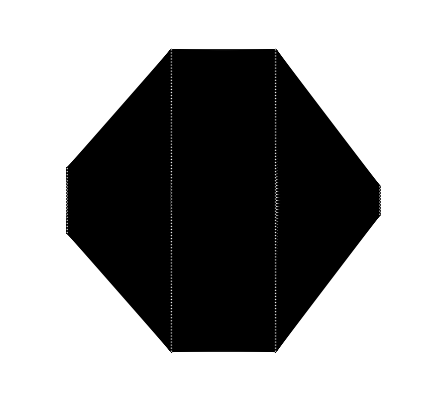

Confusion Matrix:

[[ 18   4   1   1   1   4   2   0   0   0]
 [  0 114   0   0   0   0   0   2   0   0]
 [  0   0 650   0   0   0   0   0   1   0]
 [  0   0   1 223   0   4   0   0   0   4]
 [  0   3   0   0   5   1   2   0   0   1]
 [  0   0   0   0   0  86   4   0   0   0]
 [  0   0   0   1   0   5  14   1   0   1]
 [  0   7   0   0   0   1   1 141   0   0]
 [  0  11  12   0   0   0   0  13  37   0]
 [  0   0   0   9   0   2   1   2   1  47]]


Species Accuracy Precision Recall F1-score 0 99.10% 100.00% 58.06% 73.47% 1 98.12% 82.01% 98.28% 89.41% 2 98.96% 97.89% 99.85% 98.86% 3 98.61% 95.30% 96.12% 95.71% 4 99.44% 83.33% 41.67% 55.56% 5 98.54% 83.50% 95.56% 89.12% 6 98.75% 58.33% 63.64% 60.87% 7 98.12% 88.68% 94.00% 91.26% 8 97.36% 94.87% 50.68% 66.07% 9 98.54% 88.68% 75.81% 81.74% Average 98.55% 87.26% 77.37% 80.21%

Iteration 42

Hidden Layers Training Fraction Number of Steps [100, 100] 50% 500

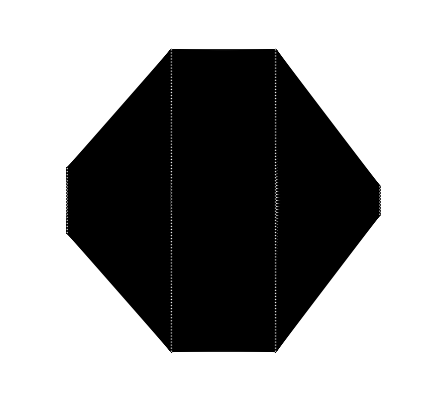

Confusion Matrix:

[[  50    2    2   12    1    1    3    1    9    0]
 [   0  264    0    1    0    0    0    5    1    0]
 [   1    1 1723    2    0    0    0    0    2    0]
 [   0    0    2  506    0    2    4    0    1   10]
 [   0    3    0    2    0    0    1   20    0    1]
 [   0    0    0    5    0  244   11    4    0    2]
 [   1    0    0    1    0    6   38    2    0    1]
 [   0    9    0    0    0    1    3  342    1    0]
 [   4   21   19    1    0    0    0   25  100    0]
 [   0    0    0    6    0    0    4    3    2  108]]


Species Accuracy Precision Recall F1-score 0 98.97% 89.29% 61.73% 72.99% 1 98.80% 88.00% 97.42% 92.47% 2 99.19% 98.68% 99.65% 99.17% 3 98.64% 94.40% 96.38% 95.38% 4 99.22% 0.00% 0.00% nan% 5 99.11% 96.06% 91.73% 93.85% 6 98.97% 59.38% 77.55% 67.26% 7 97.94% 85.07% 96.07% 90.24% 8 97.61% 86.21% 58.82% 69.93% 9 99.19% 88.52% 87.80% 88.16% Average 98.77% 78.56% 76.72% 85.49%

Iteration 43

Hidden Layers Training Fraction Number of Steps [100, 100] 80% 1000

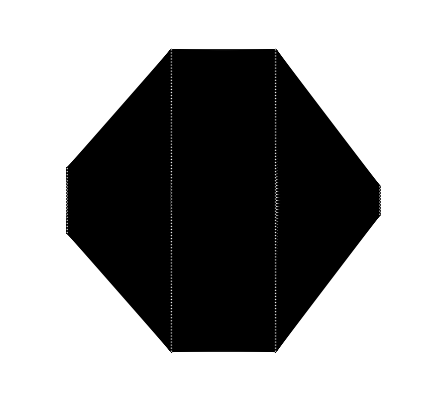

Confusion Matrix:

[[ 15   0   0   0   1   2   1   1   0   0]
 [  1 111   0   0   1   0   0   3   1   0]
 [  0   0 685   0   1   0   0   0   1   0]
 [  0   0   1 210   0   0   0   0   0   2]
 [  0   0   0   0   6   2   0   0   0   0]
 [  0   0   0   0   0 102   4   2   0   1]
 [  0   0   0   2   0   6  18   0   0   0]
 [  0   4   0   0   0   3   1 125   1   0]
 [  1   7   9   0   0   0   0  14  40   0]
 [  0   0   0   2   0   0   0   2   0  50]]


Species Accuracy Precision Recall F1-score 0 99.51% 88.24% 75.00% 81.08% 1 98.82% 90.98% 94.87% 92.89% 2 99.17% 98.56% 99.71% 99.13% 3 99.51% 98.13% 98.59% 98.36% 4 99.65% 66.67% 75.00% 70.59% 5 98.61% 88.70% 93.58% 91.07% 6 99.03% 75.00% 69.23% 72.00% 7 97.85% 85.03% 93.28% 88.97% 8 97.64% 93.02% 56.34% 70.18% 9 99.51% 94.34% 92.59% 93.46% Average 98.93% 87.87% 84.82% 85.77%

Iteration 44

Hidden Layers Training Fraction Number of Steps [100, 100] 50% 1000

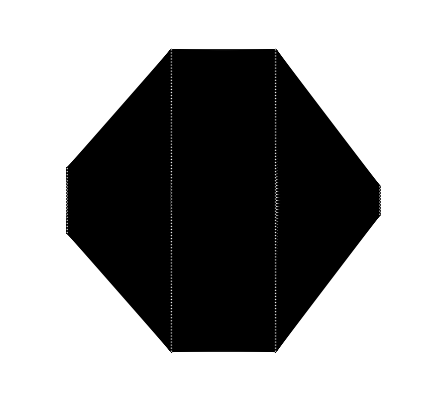

Confusion Matrix:

[[  54    6    3    2    2    5    1    1    9    0]
 [   0  255    0    0    2    0    0    1    1    0]
 [   3    0 1719    2    0    0    0    0    4    0]
 [   0    0    2  562    0    1    0    0    0    5]
 [   1    0    0    0   28    0    0    0    0    1]
 [   0    0    0    2    0  233    5    2    0    3]
 [   3    0    0    8    0   15   30    0    0    0]
 [   0    8    0    1    1    3    1  313    3    0]
 [   4   14   19    0    0    0    0   26   96    0]
 [   0    0    0    6    0    2    0    2    4  123]]


Species Accuracy Precision Recall F1-score 0 98.89% 83.08% 65.06% 72.97% 1 99.11% 90.11% 98.46% 94.10% 2 99.08% 98.62% 99.48% 99.05% 3 99.19% 96.40% 98.60% 97.48% 4 99.81% 84.85% 93.33% 88.89% 5 98.94% 89.96% 95.10% 92.46% 6 99.08% 81.08% 53.57% 64.52% 7 98.64% 90.72% 94.85% 92.74% 8 97.66% 82.05% 60.38% 69.57% 9 99.36% 93.18% 89.78% 91.45% Average 98.98% 89.01% 84.86% 86.32%

Iteration 45

Hidden Layers Training Fraction Number of Steps [100, 100] 80% 1500

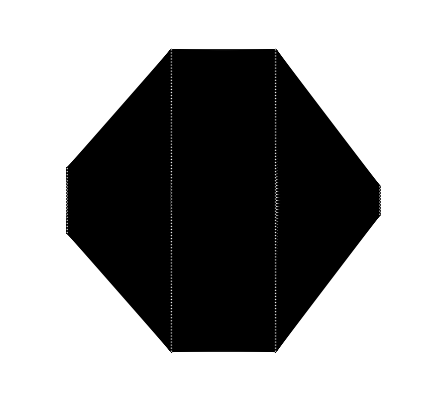

Confusion Matrix:

[[ 23   0   0   0   0   1   0   0   1   0]
 [  0  99   0   0   0   0   0   3   3   0]
 [  0   0 716   2   1   0   0   0   1   0]
 [  0   0   1 212   0   1   1   0   1   2]
 [  1   1   0   0   9   2   0   0   0   2]
 [  0   0   0   1   0  84   2   0   0   0]
 [  0   0   0   3   0   3  21   0   0   0]
 [  0   1   0   1   0   0   1 123   6   0]
 [  0   1   4   0   0   0   0   7  46   0]
 [  0   0   0   5   0   0   1   1   0  45]]


Species Accuracy Precision Recall F1-score 0 99.79% 95.83% 92.00% 93.88% 1 99.37% 97.06% 94.29% 95.65% 2 99.37% 99.31% 99.44% 99.38% 3 98.75% 94.64% 97.25% 95.93% 4 99.51% 90.00% 60.00% 72.00% 5 99.31% 92.31% 96.55% 94.38% 6 99.24% 80.77% 77.78% 79.25% 7 98.61% 91.79% 93.18% 92.48% 8 98.33% 79.31% 79.31% 79.31% 9 99.24% 91.84% 86.54% 89.11% Average 99.15% 91.29% 87.63% 89.14%

Iteration 46

Hidden Layers Training Fraction Number of Steps [100, 100] 50% 1500

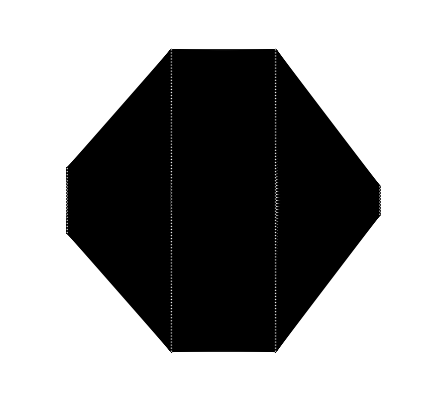

Confusion Matrix:

[[  66    0    0    0    2    1    0    1    0    0]
 [   0  255    0    0    2    0    0    2    1    0]
 [   0    0 1773    1    0    0    1    0    7    0]
 [   1    0    1  544    0    0    3    0    1    4]
 [   2    1    0    0   21    0    0    1    0    5]
 [   1    0    0    0    0  207    9    2    0    0]
 [   1    0    0    2    1   10   41    0    0    1]
 [   0   13    0    0    0    0    3  298    1    0]
 [   6   15   13    0    0    0    0   24  108    0]
 [   0    0    1    5    0    1    2    1    3  132]]


Species Accuracy Precision Recall F1-score 0 99.58% 85.71% 94.29% 89.80% 1 99.05% 89.79% 98.08% 93.75% 2 99.33% 99.16% 99.49% 99.33% 3 99.50% 98.55% 98.19% 98.37% 4 99.61% 80.77% 70.00% 75.00% 5 99.33% 94.52% 94.52% 94.52% 6 99.08% 69.49% 73.21% 71.30% 7 98.67% 90.58% 94.60% 92.55% 8 98.03% 89.26% 65.06% 75.26% 9 99.36% 92.96% 91.03% 91.99% Average 99.15% 89.08% 87.85% 88.19%

Iteration 47

Hidden Layers Training Fraction Number of Steps [100, 100] 80% 2000

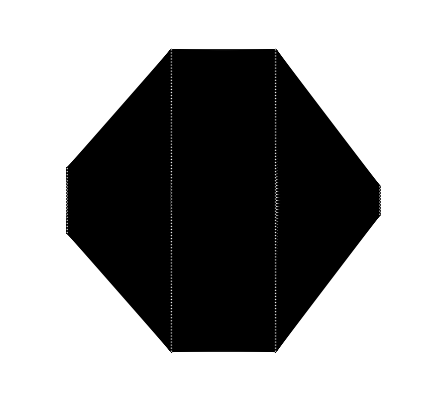

Confusion Matrix:

[[ 22   0   0   0   1   0   1   0   0   0]
 [  0  99   0   0   1   0   0   1   3   0]
 [  0   1 684   1   0   0   0   0   2   0]
 [  0   0   1 235   0   0   0   0   0   2]
 [  1   1   0   0   9   0   0   0   0   0]
 [  0   0   0   1   0  94   1   0   0   0]
 [  0   0   0   3   1   3  13   0   0   0]
 [  0   3   0   1   0   0   0 144   2   0]
 [  1   5   7   1   0   0   0   7  42   0]
 [  0   0   0   0   0   1   0   0   1  43]]


Species Accuracy Precision Recall F1-score 0 99.72% 91.67% 91.67% 91.67% 1 98.96% 90.83% 95.19% 92.96% 2 99.17% 98.84% 99.42% 99.13% 3 99.31% 97.11% 98.74% 97.92% 4 99.65% 75.00% 81.82% 78.26% 5 99.58% 95.92% 97.92% 96.91% 6 99.37% 86.67% 65.00% 74.29% 7 99.03% 94.74% 96.00% 95.36% 8 97.98% 84.00% 66.67% 74.34% 9 99.72% 95.56% 95.56% 95.56% Average 99.25% 91.03% 88.80% 89.64%

Iteration 48

Hidden Layers Training Fraction Number of Steps [100, 100] 50% 2000

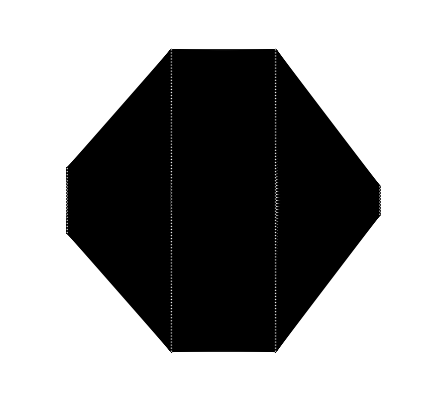

Confusion Matrix:

[[  65    0    1    1    2    0    0    1    2    0]
 [   1  247    0    0    3    0    0    5    4    0]
 [   0    1 1746    2    0    0    2    0    1    0]
 [   0    0    1  558    0    0    1    0    1    4]
 [   2    1    0    0   31    0    1    0    0    3]
 [   0    0    0    1    0  218    4    1    0    0]
 [   0    0    0    7    0   13   39    1    0    1]
 [   0   11    0    1    0    1    3  307    8    0]
 [   1    6   16    0    0    0    0   24  112    0]
 [   0    0    0    3    0    2    3    1    4  122]]


Species Accuracy Precision Recall F1-score 0 99.69% 94.20% 90.28% 92.20% 1 99.11% 92.86% 95.00% 93.92% 2 99.33% 98.98% 99.66% 99.32% 3 99.39% 97.38% 98.76% 98.07% 4 99.67% 86.11% 81.58% 83.78% 5 99.39% 93.16% 97.32% 95.20% 6 99.00% 73.58% 63.93% 68.42% 7 98.42% 90.29% 92.75% 91.51% 8 98.14% 84.85% 70.44% 76.98% 9 99.42% 93.85% 90.37% 92.08% Average 99.15% 90.53% 88.01% 89.15%

Iteration 49

Hidden Layers Training Fraction Number of Steps [10, 10, 10] 80% 100

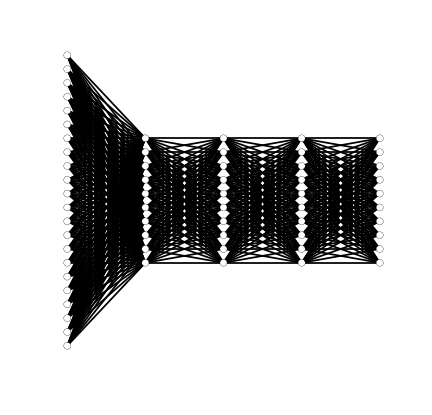

Confusion Matrix:

[[  0   0  30   2   0   0   0   0   0   0]
 [  0   0  47  50   0   0   0   0   0   0]
 [  0   0 719   0   0   0   0   0   0   0]
 [  0   0 208  12   0   0   0   0   0   0]
 [  0   0   7   5   0   0   0   0   0   0]
 [  0   0  58  29   0   0   0   1   0   0]
 [  0   0   2  18   0   0   0   0   0   0]
 [  0   0   4 120   0   0   0  10   0   0]
 [  0   0  40  16   0   0   0   0   0   0]
 [  0   0  22  39   0   0   0   0   0   0]]


Species Accuracy Precision Recall F1-score 0 97.78% nan% 0.00% nan% 1 93.26% nan% 0.00% nan% 2 70.95% 63.24% 100.00% 77.48% 3 66.16% 4.12% 5.45% 4.70% 4 99.17% nan% 0.00% nan% 5 93.88% nan% 0.00% nan% 6 98.61% nan% 0.00% nan% 7 91.31% 90.91% 7.46% 13.79% 8 96.11% nan% 0.00% nan% 9 95.76% nan% 0.00% nan% Average 90.30% 52.76% 11.29% 31.99%

Iteration 50

Hidden Layers Training Fraction Number of Steps [10, 10, 10] 50% 100

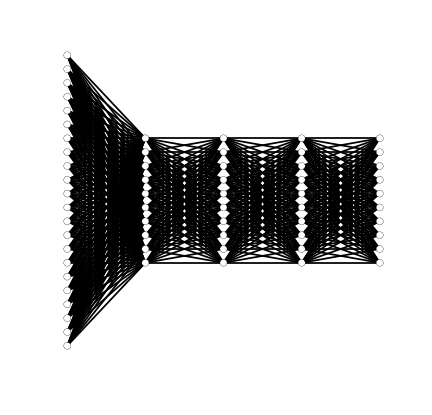

Confusion Matrix:

[[   0    0   78   10    0    0    0    0    0    0]
 [   0    0   41  236    0    0    0    0    0    0]
 [   0    0 1721    2    0    0    0    0    0    0]
 [   0    0  372  203    0    0    0    0    0    0]
 [   0    0    1   32    0    0    0    0    0    0]
 [   0    0   14  225    0    0    0    0    0    0]
 [   0    0    0   57    0    0    0    0    0    0]
 [   0    0    0  334    0    0    0    0    0    0]
 [   0    0   84   57    0    0    0    0    0    0]
 [   0    0   23  107    0    0    0    0    0    0]]


Species Accuracy Precision Recall F1-score 0 97.55% nan% 0.00% nan% 1 92.30% nan% 0.00% nan% 2 82.90% 73.74% 99.88% 84.84% 3 60.19% 16.07% 35.30% 22.09% 4 99.08% nan% 0.00% nan% 5 93.36% nan% 0.00% nan% 6 98.42% nan% 0.00% nan% 7 90.71% nan% 0.00% nan% 8 96.08% nan% 0.00% nan% 9 96.39% nan% 0.00% nan% Average 90.70% 44.90% 13.52% 53.47%

Iteration 51

Hidden Layers Training Fraction Number of Steps [10, 10, 10] 80% 200

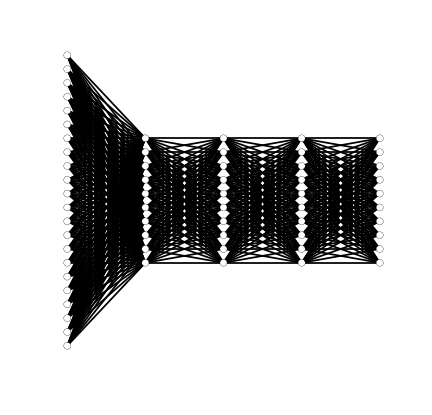

Confusion Matrix:

[[  0   0   1  34   0   0   0   0   0   0]
 [  0   0   0 119   0   0   0   0   0   0]
 [  0   0 687   1   0   0   0   0   0   0]
 [  0   0   2 205   0   0   0   0   0   0]
 [  0   0   0  10   0   0   0   0   0   0]
 [  0   0   0  84   0   0   0   0   0   0]
 [  0   0   0  26   0   0   0   0   0   0]
 [  0   0   0 142   0   0   0   0   0   0]
 [  0   0  27  42   0   0   0   0   0   0]
 [  0   0   1  58   0   0   0   0   0   0]]


Species Accuracy Precision Recall F1-score 0 97.57% nan% 0.00% nan% 1 91.73% nan% 0.00% nan% 2 97.78% 95.68% 99.85% 97.72% 3 64.00% 28.43% 99.03% 44.18% 4 99.31% nan% 0.00% nan% 5 94.16% nan% 0.00% nan% 6 98.19% nan% 0.00% nan% 7 90.13% nan% 0.00% nan% 8 95.21% nan% 0.00% nan% 9 95.90% nan% 0.00% nan% Average 92.40% 62.06% 19.89% 70.95%

Iteration 52

Hidden Layers Training Fraction Number of Steps [10, 10, 10] 50% 200

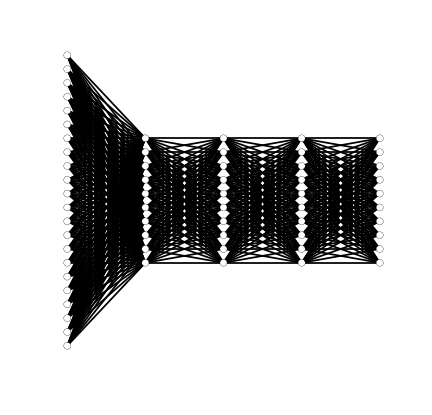

Confusion Matrix:

[[   0    0    5   76    0    0    0    0    0    0]
 [   0    0    0  276    0    0    0    0    0    0]
 [   0    0 1742    2    0    0    0    0    0    0]
 [   0    0    6  543    0    0    0    0    0    0]
 [   0    0    0   35    0    0    0    0    0    0]
 [   0    0    0  241    0    0    0    0    0    0]
 [   0    0    0   50    0    0    0    0    0    0]
 [   0    0    0  329    0    0    0    0    0    0]
 [   0    0   37  118    0    0    0    0    0    0]
 [   0    0    2  135    0    0    0    0    0    0]]


Species Accuracy Precision Recall F1-score 0 97.75% nan% 0.00% nan% 1 92.33% nan% 0.00% nan% 2 98.55% 97.21% 99.89% 98.53% 3 64.75% 30.08% 98.91% 46.13% 4 99.03% nan% 0.00% nan% 5 93.30% nan% 0.00% nan% 6 98.61% nan% 0.00% nan% 7 90.85% nan% 0.00% nan% 8 95.69% nan% 0.00% nan% 9 96.19% nan% 0.00% nan% Average 92.71% 63.65% 19.88% 72.33%

Iteration 53

Hidden Layers Training Fraction Number of Steps [10, 10, 10] 80% 500

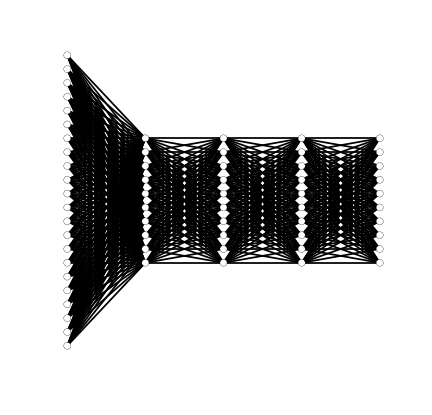

Confusion Matrix:

[[  0   0   1  22   0   0   0   0   0   0]
 [  0   0   0 109   0   0   0   0   0   0]
 [  0   0 706   2   0   0   0   0   0   0]
 [  0   0   3 218   0   0   0   0   0   0]
 [  0   0   0  12   0   0   0   0   0   0]
 [  0   0   0  96   0   0   0   0   0   0]
 [  0   0   0  26   0   0   0   0   0   0]
 [  0   0   0 142   0   0   0   0   0   0]
 [  0   0  20  41   0   0   0   0   0   0]
 [  0   0   0  41   0   0   0   0   0   0]]


Species Accuracy Precision Recall F1-score 0 98.40% nan% 0.00% nan% 1 92.43% nan% 0.00% nan% 2 98.19% 96.71% 99.72% 98.19% 3 65.67% 30.75% 98.64% 46.88% 4 99.17% nan% 0.00% nan% 5 93.33% nan% 0.00% nan% 6 98.19% nan% 0.00% nan% 7 90.13% nan% 0.00% nan% 8 95.76% nan% 0.00% nan% 9 97.15% nan% 0.00% nan% Average 92.84% 63.73% 19.84% 72.54%

Iteration 54

Hidden Layers Training Fraction Number of Steps [10, 10, 10] 50% 500

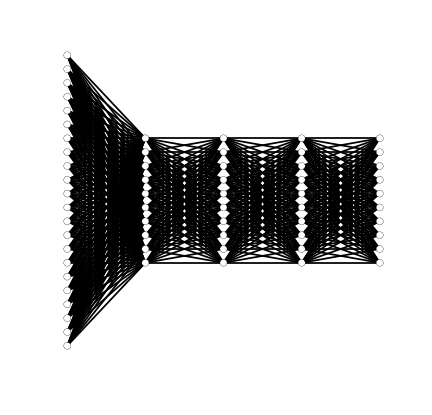

Confusion Matrix:

[[   0    0   15   51    0    0    0    0    0    0]
 [   0    0    0   66    0    0    0  183    0    0]
 [   0    0 1733    5    0    0    0    0    0    0]
 [   0    0    7  564    0    0    0    5    0    0]
 [   0    0    0   33    0    0    0    3    0    0]
 [   0    0    0  236    0    0    0    8    0    0]
 [   0    0    1   35    0    0    0   16    0    0]
 [   0    0    0   11    0    0    0  329    0    0]
 [   0    0   27   71    0    0    0   50    0    0]
 [   0    0    0  110    0    0    0   38    0    0]]


Species Accuracy Precision Recall F1-score 0 98.17% nan% 0.00% nan% 1 93.08% nan% 0.00% nan% 2 98.47% 97.20% 99.71% 98.44% 3 82.49% 47.72% 97.92% 64.16% 4 99.00% nan% 0.00% nan% 5 93.22% nan% 0.00% nan% 6 98.55% nan% 0.00% nan% 7 91.27% 52.06% 96.76% 67.70% 8 95.89% nan% 0.00% nan% 9 95.89% nan% 0.00% nan% Average 94.60% 65.66% 29.44% 76.77%

Iteration 55

Hidden Layers Training Fraction Number of Steps [10, 10, 10] 80% 1000

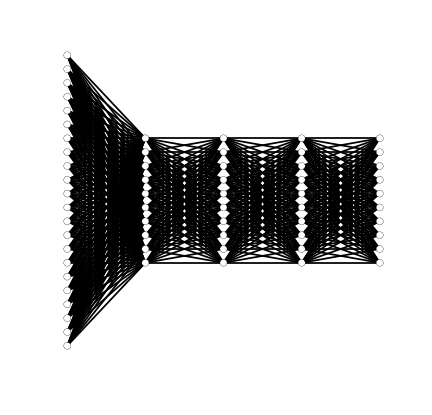

Confusion Matrix:

[[  0   0   0  21   0   2   0   2   0   0]
 [  0   9   0   3   0  10   0  75   0   0]
 [  0   0 701   1   0   1   0   1   0   0]
 [  0   0   3 212   0   1   0   0   0   0]
 [  0   8   0   2   0   6   0   1   0   0]
 [  0  20   0  17   0  42   0  22   0   0]
 [  0   9   0   5   0   9   0   3   0   0]
 [  0   0   0   1   0   1   0 120   0   0]
 [  0   1   7  26   0   1   0  29   0   0]
 [  0   1   0  64   0   2   0   0   0   0]]


Species Accuracy Precision Recall F1-score 0 98.26% nan% 0.00% nan% 1 91.17% 18.75% 9.28% 12.41% 2 99.10% 98.59% 99.57% 99.08% 3 89.99% 60.23% 98.15% 74.65% 4 98.82% nan% 0.00% nan% 5 93.61% 56.00% 41.58% 47.73% 6 98.19% nan% 0.00% nan% 7 90.62% 47.43% 98.36% 64.00% 8 95.55% nan% 0.00% nan% 9 95.34% nan% 0.00% nan% Average 95.07% 56.20% 34.69% 59.57%

Iteration 56

Hidden Layers Training Fraction Number of Steps [10, 10, 10] 50% 1000

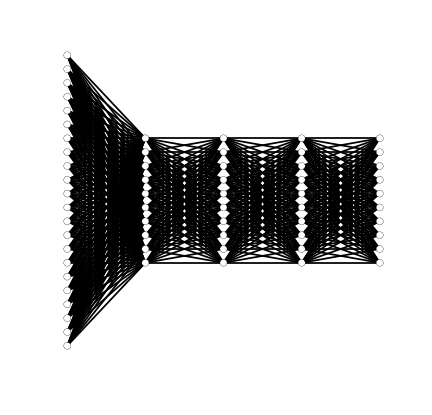

Confusion Matrix:

[[   0    1    1   60    0    0    0    3    0    0]
 [   0   32    0   29    0    4    0  206    0    0]
 [   0    1 1735    2    0    0    0    2    0    0]
 [   0    3    6  550    0    0    0    3    0    0]
 [   0   19    0    4    0    4    0    4    0    0]
 [   0   60    0  113    0   10    0   54    0    0]
 [   0   31    0   14    0    1    0   18    0    0]
 [   0    0    0    3    0    0    0  336    0    0]
 [   0    0   33   64    0    0    0   62    0    0]
 [   0    9    0  113    0    0    0    7    0    0]]


Species Accuracy Precision Recall F1-score 0 98.19% nan% 0.00% nan% 1 89.91% 20.51% 11.81% 14.99% 2 98.75% 97.75% 99.71% 98.72% 3 88.49% 57.77% 97.86% 72.66% 4 99.14% nan% 0.00% nan% 5 93.44% 52.63% 4.22% 7.81% 6 98.22% nan% 0.00% nan% 7 89.94% 48.35% 99.12% 64.99% 8 95.58% nan% 0.00% nan% 9 96.41% nan% 0.00% nan% Average 94.81% 55.40% 31.27% 51.83%

Iteration 57

Hidden Layers Training Fraction Number of Steps [10, 10, 10] 80% 1500

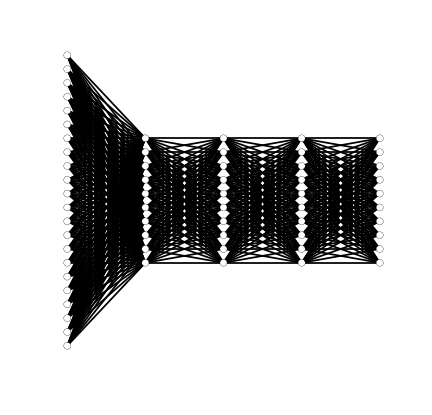

Confusion Matrix:

[[  0   0   0  22   0   8   0   2   0   0]
 [  0   3   0   1   0  21   0  94   0   0]
 [  0   0 696   3   0   0   0   0   0   0]
 [  0   0   2 227   0   0   0   0   0   0]
 [  0   0   0   1   0   9   0   0   0   0]
 [  0   3   0  18   0  61   0  10   0   0]
 [  0   1   0   4   0  19   0   1   0   0]
 [  0   0   0   1   0   1   0 123   0   0]
 [  0   0   9  25   0   3   0  18   0   0]
 [  0   0   0  44   0   9   0   0   0   0]]


Species Accuracy Precision Recall F1-score 0 97.78% nan% 0.00% nan% 1 91.66% 42.86% 2.52% 4.76% 2 99.03% 98.44% 99.57% 99.00% 3 91.59% 65.61% 99.13% 78.96% 4 99.31% nan% 0.00% nan% 5 92.98% 46.56% 66.30% 54.71% 6 98.26% nan% 0.00% nan% 7 91.17% 49.60% 98.40% 65.95% 8 96.18% nan% 0.00% nan% 9 96.32% nan% 0.00% nan% Average 95.43% 60.61% 36.59% 60.68%

Iteration 58

Hidden Layers Training Fraction Number of Steps [10, 10, 10] 50% 1500

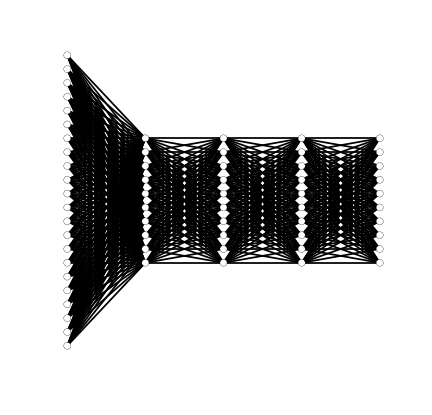

Confusion Matrix:

[[   0    0    2   63    0   11    0    1    0    0]
 [   0    8    0    3    0   39    0  227    0    0]
 [   0    0 1728    3    0    1    0    2    0    0]
 [   0    1    2  545    0    3    0    0    0    0]
 [   0    0    0    2    0   26    0    3    0    0]
 [   0   18    0   55    0  136    0   26    0    0]
 [   0    5    0    8    0   37    0    6    0    0]
 [   0    3    0    3    0    1    0  332    0    0]
 [   0    0   24   69    0    8    0   54    0    0]
 [   0    0    0  123    0   15    0    4    0    0]]


Species Accuracy Precision Recall F1-score 0 97.86% nan% 0.00% nan% 1 91.77% 22.86% 2.89% 5.13% 2 99.05% 98.41% 99.65% 99.03% 3 90.69% 62.36% 98.91% 76.49% 4 99.14% nan% 0.00% nan% 5 93.33% 49.10% 57.87% 53.12% 6 98.44% nan% 0.00% nan% 7 90.83% 50.69% 97.94% 66.80% 8 95.69% nan% 0.00% nan% 9 96.05% nan% 0.00% nan% Average 95.28% 56.68% 35.73% 60.11%

Iteration 59

Hidden Layers Training Fraction Number of Steps [10, 10, 10] 80% 2000

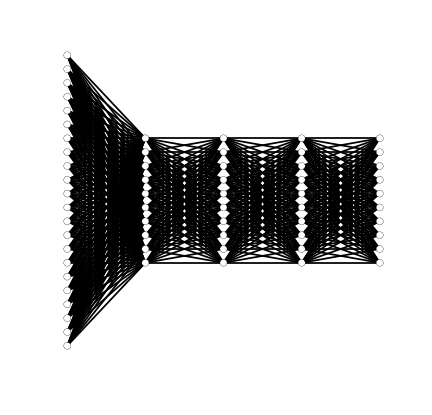

Confusion Matrix:

[[  0   0   2  20   0   4   0   0   0   0]
 [  0   6   0   1   0  12   0  90   0   0]
 [  0   0 701   1   0   0   0   0   0   0]
 [  0   0   1 227   0   3   0   0   0   0]
 [  0   1   0   2   0  11   0   0   0   0]
 [  0  11   0   8   0  68   0   4   0   0]
 [  0   2   0   6   0  20   0   1   0   0]
 [  0   1   0   0   0   0   0 128   0   0]
 [  0   0  12  30   0   1   0  20   0   0]
 [  0   1   0  31   0  11   0   2   0   0]]


Species Accuracy Precision Recall F1-score 0 98.19% nan% 0.00% nan% 1 91.73% 27.27% 5.50% 9.16% 2 98.89% 97.91% 99.86% 98.87% 3 92.84% 69.63% 98.27% 81.51% 4 99.03% nan% 0.00% nan% 5 94.09% 52.31% 74.73% 61.54% 6 97.98% nan% 0.00% nan% 7 91.80% 52.24% 99.22% 68.45% 8 95.62% nan% 0.00% nan% 9 96.87% nan% 0.00% nan% Average 95.71% 59.87% 37.76% 63.91%

Iteration 60

Hidden Layers Training Fraction Number of Steps [10, 10, 10] 50% 2000

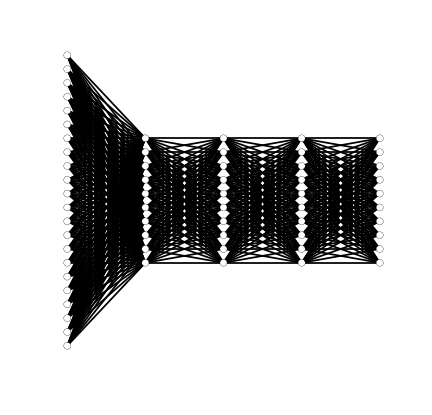

Confusion Matrix:

[[   0    1    0   19    0   44    0    6    0    5]
 [   0    2    0    2    0    0    0  273    1    1]
 [   0    1 1716    1    0    0    0    0    0    1]
 [   0    0    3  556    0    6    0    2    0    1]
 [   0    0    0    5    0    2    0    3    0   31]
 [   0    0    0    9    0  209    0    5    0    4]
 [   0    0    0   37    0   10    0    2    0   13]
 [   0    0    0    3    0    2    0  334    0    0]
 [   0   14   28   34    0    5    0   62   17    1]
 [   0    0    0   81    0    1    0   21    0   23]]


Species Accuracy Precision Recall F1-score 0 97.91% nan% 0.00% nan% 1 91.85% 11.11% 0.72% 1.35% 2 99.05% 98.23% 99.83% 99.02% 3 94.36% 74.43% 97.89% 84.56% 4 98.86% nan% 0.00% nan% 5 97.55% 74.91% 92.07% 82.61% 6 98.28% nan% 0.00% nan% 7 89.46% 47.18% 98.53% 63.80% 8 95.97% 94.44% 10.56% 18.99% 9 95.55% 28.75% 18.25% 22.33% Average 95.89% 61.29% 41.78% 53.24%

Iteration 61

Hidden Layers Training Fraction Number of Steps [100, 100, 100] 80% 100

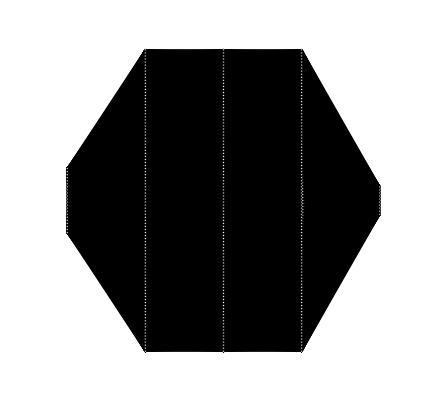

Confusion Matrix:

[[  0   0   1  32   0   0   0   2   0   0]
 [  0   0   0  74   0   0   0  29   0   0]
 [  0   0 680   0   0   0   0   0   0   0]
 [  0   0   2 233   0   0   0   1   0   0]
 [  0   0   0  10   0   0   0   0   0   0]
 [  0   0   0  94   0   0   0  13   0   0]
 [  0   0   0  16   0   0   0   7   0   0]
 [  0   0   0  18   0   0   0 114   0   0]
 [  0   0  16  24   0   0   0  20   0   0]
 [  0   0   0  52   0   0   0   1   0   0]]


Species Accuracy Precision Recall F1-score 0 97.57% nan% 0.00% nan% 1 92.84% nan% 0.00% nan% 2 98.68% 97.28% 100.00% 98.62% 3 77.55% 42.13% 98.73% 59.06% 4 99.31% nan% 0.00% nan% 5 92.56% nan% 0.00% nan% 6 98.40% nan% 0.00% nan% 7 93.68% 60.96% 86.36% 71.47% 8 95.83% nan% 0.00% nan% 9 96.32% nan% 0.00% nan% Average 94.27% 66.79% 28.51% 76.39%

Iteration 62

Hidden Layers Training Fraction Number of Steps [100, 100, 100] 50% 100

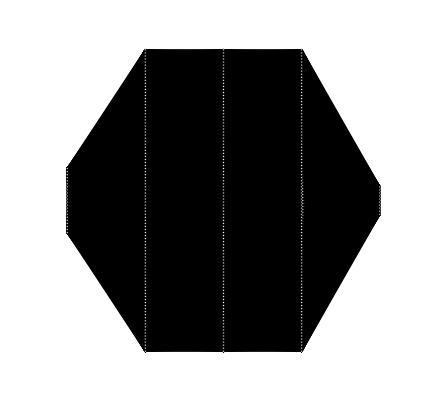

Confusion Matrix:

[[   0    0    1   79    0    0    0    4    0    0]
 [   0    0    0  163    0    0    0  114    0    0]
 [   0    0 1732    3    0    0    0    0    0    0]
 [   0    0    6  537    0    0    0   13    0    0]
 [   0    0    0   31    0    0    0    5    0    0]
 [   0    0    0  126    0    0    0   98    0    0]
 [   0    0    0    7    0    0    0   43    0    0]
 [   0    0    0   23    0    0    0  327    0    0]
 [   0    0   30   73    0    0    0   49    0    0]
 [   0    0    2  106    0    0    0   25    0    0]]


Species Accuracy Precision Recall F1-score 0 97.66% nan% 0.00% nan% 1 92.30% nan% 0.00% nan% 2 98.83% 97.80% 99.83% 98.80% 3 82.49% 46.78% 96.58% 63.03% 4 99.00% nan% 0.00% nan% 5 93.77% nan% 0.00% nan% 6 98.61% nan% 0.00% nan% 7 89.60% 48.23% 93.43% 63.62% 8 95.77% nan% 0.00% nan% 9 96.30% nan% 0.00% nan% Average 94.43% 64.27% 28.98% 75.15%

Iteration 63

Hidden Layers Training Fraction Number of Steps [100, 100, 100] 80% 200

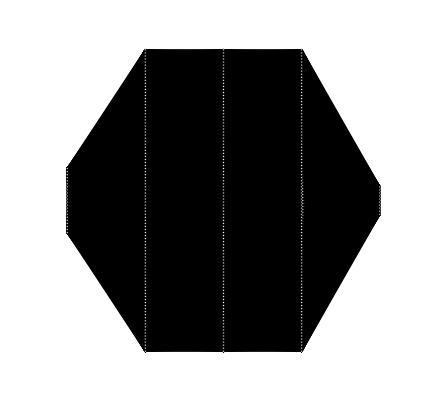

Confusion Matrix:

[[  0   3   1  17   0   3   0   1   0   0]
 [  0  64   0   2   0   7   0  33   0   0]
 [  0   3 698   0   0   0   0   0   0   0]
 [  0   2   5 225   0   3   0   0   0   0]
 [  0   6   0   0   0   2   0   0   0   0]
 [  0  10   0  28   0  52   0   6   0   0]
 [  0  14   0   2   0   7   0   1   0   0]
 [  0  14   0   0   0   0   0 113   0   0]
 [  0   2  10  28   0   0   0  23   0   0]
 [  0   7   1  34   0  12   0   0   0   0]]


Species Accuracy Precision Recall F1-score 0 98.26% nan% 0.00% nan% 1 92.84% 51.20% 60.38% 55.41% 2 98.61% 97.62% 99.57% 98.59% 3 91.59% 66.96% 95.74% 78.81% 4 99.44% nan% 0.00% nan% 5 94.58% 60.47% 54.17% 57.14% 6 98.33% nan% 0.00% nan% 7 94.58% 63.84% 88.98% 74.34% 8 95.62% nan% 0.00% nan% 9 96.25% nan% 0.00% nan% Average 96.01% 68.02% 39.88% 72.86%

Iteration 64

Hidden Layers Training Fraction Number of Steps [100, 100, 100] 50% 200

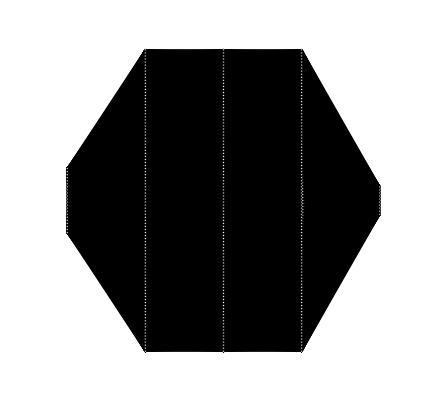

Confusion Matrix:

[[   0    6    0   59    0   11    0    0    0    0]
 [   0   41    0    1    0   22    0  214    0    0]
 [   0    1 1749    2    0    1    0    1    0    0]
 [   0    2   11  526    0    5    0    0    0    0]
 [   0   25    0    3    0    4    0    4    0    0]
 [   0   14    0   75    0  120    0   17    0    0]
 [   0   32    0    1    0   22    0   10    0    0]
 [   0    2    0    1    0    2    0  338    0    0]
 [   0    1   26   65    0    7    0   48    0    0]
 [   0    7    1   95    0   21    0    4    0    0]]


Species Accuracy Precision Recall F1-score 0 97.89% nan% 0.00% nan% 1 90.91% 31.30% 14.75% 20.05% 2 98.80% 97.87% 99.71% 98.79% 3 91.10% 63.53% 96.69% 76.68% 4 99.00% nan% 0.00% nan% 5 94.41% 55.81% 53.10% 54.42% 6 98.19% nan% 0.00% nan% 7 91.58% 53.14% 98.54% 69.05% 8 95.91% nan% 0.00% nan% 9 96.44% nan% 0.00% nan% Average 95.42% 60.33% 36.28% 63.80%

Iteration 65

Hidden Layers Training Fraction Number of Steps [100, 100, 100] 80% 500

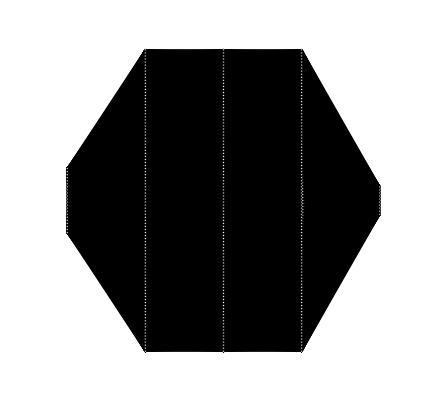

Confusion Matrix:

[[  0   3   1  18   0   1   0   0   0   3]
 [  0  91   0   0   0   0   0  13   1   0]
 [  0   0 659   0   0   1   0   0   0   0]
 [  0   0   6 213   0   2   1   0   0   2]
 [  0   0   0   1  10   1   0   0   0   0]
 [  0   0   0   5   0  89   0   1   0   3]
 [  0   0   0   0   0  12   2   1   0   4]
 [  0   9   0   1   0   3   0 134   0   0]
 [  0  18  11   4   0   0   0  12  39   0]
 [  0   1   1  44   0   7   2   1   1   7]]


Species Accuracy Precision Recall F1-score 0 98.19% nan% 0.00% nan% 1 96.87% 74.59% 86.67% 80.18% 2 98.61% 97.20% 99.85% 98.51% 3 94.16% 74.48% 95.09% 83.53% 4 99.86% 100.00% 83.33% 90.91% 5 97.50% 76.72% 90.82% 83.18% 6 98.61% 40.00% 10.53% 16.67% 7 97.15% 82.72% 91.16% 86.73% 8 96.73% 95.12% 46.43% 62.40% 9 95.21% 36.84% 10.94% 16.87% Average 97.29% 75.30% 61.48% 68.77%

Iteration 66

Hidden Layers Training Fraction Number of Steps [100, 100, 100] 50% 500

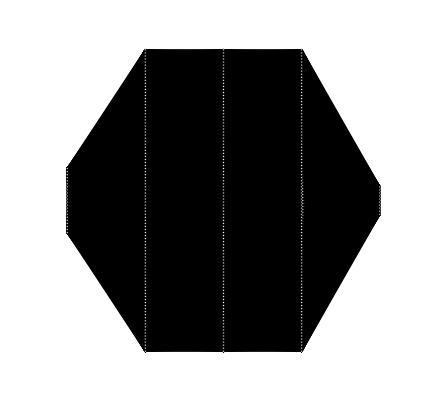

Confusion Matrix:

[[   0    2    0   61    0    8    0    2    3    0]
 [   0  166    0    3    0    1    0   97    0    0]
 [   0    1 1721    4    0    3    0    0    0    0]
 [   0    2    7  549    0   11    0    0    0    0]
 [   0   27    0    3    0    2    0    3    0    0]
 [   0    1    0   23    0  217    0    7    0    0]
 [   0    0    0    1    0   54    0    0    0    0]
 [   0   26    0    0    0    3    0  302    0    0]
 [   0   22   21   19    0    0    0   44   45    0]
 [   0    4    3  116    0    7    0    1    5    0]]


Species Accuracy Precision Recall F1-score 0 97.89% nan% 0.00% nan% 1 94.83% 66.14% 62.17% 64.09% 2 98.92% 98.23% 99.54% 98.88% 3 93.05% 70.47% 96.49% 81.45% 4 99.03% nan% 0.00% nan% 5 96.66% 70.92% 87.50% 78.34% 6 98.47% nan% 0.00% nan% 7 94.91% 66.23% 91.24% 76.75% 8 96.83% 84.91% 29.80% 44.12% 9 96.22% nan% 0.00% nan% Average 96.68% 76.15% 46.67% 73.94%

Iteration 67

Hidden Layers Training Fraction Number of Steps [100, 100, 100] 80% 1000

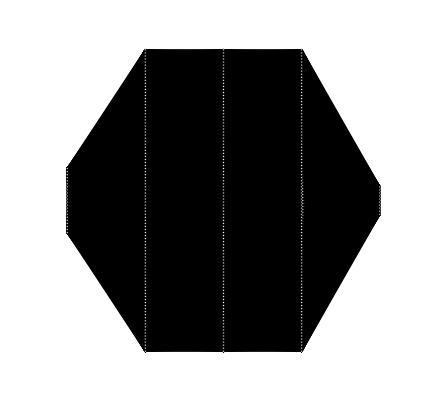

Confusion Matrix:

[[ 20   0   1   1   1   1   0   0   0   0]
 [  1 115   0   0   0   0   0   2   3   0]
 [  0   1 719   0   0   1   0   0   0   0]
 [  0   0   4 190   0   1   1   0   1  15]
 [  3   0   0   0  11   0   0   0   0   2]
 [  0   0   0   0   0  86   5   2   0   0]
 [  0   0   0   0   0   2   8   1   0   7]
 [  0   9   0   0   0   2   3 101   0   0]
 [  1  14  10   2   0   0   0   6  28   0]
 [  0   0   0   1   0   0   3   0   1  53]]


Species Accuracy Precision Recall F1-score 0 99.37% 80.00% 83.33% 81.63% 1 97.92% 82.73% 95.04% 88.46% 2 98.82% 97.96% 99.72% 98.83% 3 98.19% 97.94% 89.62% 93.60% 4 99.58% 91.67% 68.75% 78.57% 5 99.03% 92.47% 92.47% 92.47% 6 98.47% 40.00% 44.44% 42.11% 7 98.26% 90.18% 87.83% 88.99% 8 97.36% 84.85% 45.90% 59.57% 9 97.98% 68.83% 91.38% 78.52% Average 98.50% 82.66% 79.85% 80.28%

Iteration 68

Hidden Layers Training Fraction Number of Steps [100, 100, 100] 50% 1000

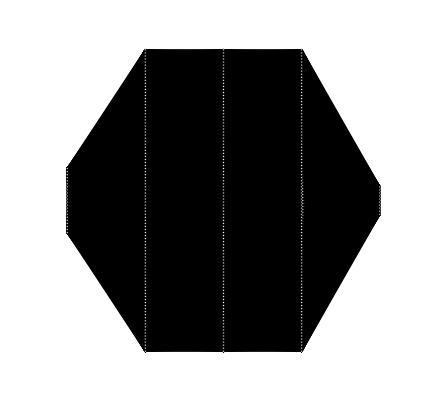

Confusion Matrix:

[[  13    1    0   45   13    0    0    0    7    1]
 [   0  266    0    2    1    0    0    6    3    0]
 [   0    0 1728    0    1    1    0    0    1    0]
 [   1    0    2  509    0    2    0    0    0   39]
 [   0    1    0    3   26    4    1    0    0    2]
 [   0    0    0    5    0  222    4    1    0    4]
 [   0    0    0   10    3   19   21    1    0    6]
 [   0   18    0    0    0    6    1  319    0    0]
 [   2   33   17    2    0    0    0   25   64    0]
 [   0    0    0   26    0    6    2    0    1  100]]


Species Accuracy Precision Recall F1-score 0 98.05% 81.25% 16.25% 27.08% 1 98.19% 83.39% 95.68% 89.11% 2 99.39% 98.91% 99.83% 99.37% 3 96.19% 84.55% 92.04% 88.14% 4 99.19% 59.09% 70.27% 64.20% 5 98.55% 85.38% 94.07% 89.52% 6 98.69% 72.41% 35.00% 47.19% 7 98.39% 90.62% 92.73% 91.67% 8 97.47% 84.21% 44.76% 58.45% 9 97.58% 65.79% 74.07% 69.69% Average 98.17% 80.56% 71.47% 72.44%

Iteration 69

Hidden Layers Training Fraction Number of Steps [100, 100, 100] 80% 1500

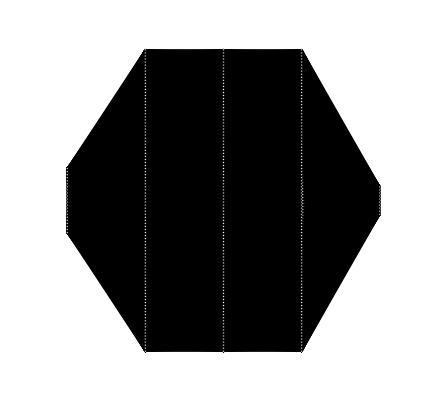

Confusion Matrix:

[[ 19   1   2   0   0   0   0   0   1   0]
 [  1 116   0   0   1   0   1   1   0   0]
 [  0   0 678   1   1   0   0   0   0   0]
 [  0   0   1 204   0   1   0   0   0  16]
 [  1   0   0   0   7   2   0   0   0   0]
 [  0   0   0   1   0  93   1   0   0   0]
 [  0   0   0   1   0   8  11   1   0   0]
 [  0   7   0   0   0   3   0 124   3   0]
 [  1   9   9   0   0   0   0  10  38   0]
 [  0   0   1   5   0   2   2   0   0  54]]


Species Accuracy Precision Recall F1-score 0 99.51% 86.36% 82.61% 84.44% 1 98.54% 87.22% 96.67% 91.70% 2 98.96% 98.12% 99.71% 98.91% 3 98.19% 96.23% 91.89% 94.01% 4 99.65% 77.78% 70.00% 73.68% 5 98.75% 85.32% 97.89% 91.18% 6 99.03% 73.33% 52.38% 61.11% 7 98.26% 91.18% 90.51% 90.84% 8 97.71% 90.48% 56.72% 69.72% 9 98.19% 77.14% 84.38% 80.60% Average 98.68% 86.32% 82.28% 83.62%

Iteration 70

Hidden Layers Training Fraction Number of Steps [100, 100, 100] 50% 1500

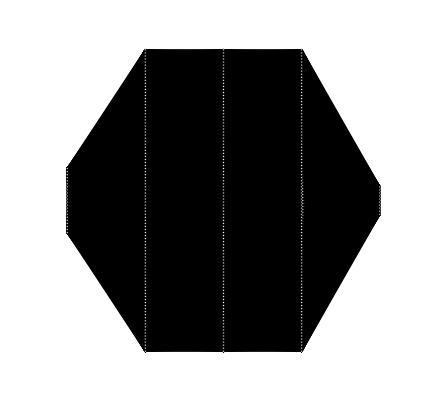

Confusion Matrix:

[[  49    6    5    4    2    0    1    1    8    0]
 [   1  258    0    1    2    0    2    0    7    0]
 [   2    0 1707    2    0    1    0    0    3    0]
 [   2    0    5  525    0    8    1    0    1   14]
 [   4    5    0    0   28    0    2    1    0    1]
 [   0    0    0    2    0  231    9    3    0    2]
 [   1    1    0    3    0   11   28    1    0    4]
 [   0   14    0    0    0    2    2  313    6    0]
 [   7   11   20    0    0    0    0   21   94    0]
 [   0    0    0   18    0    3    4    0    3  124]]


Species Accuracy Precision Recall F1-score 0 98.78% 74.24% 64.47% 69.01% 1 98.61% 87.46% 95.20% 91.17% 2 98.94% 98.27% 99.53% 98.90% 3 98.30% 94.59% 94.42% 94.51% 4 99.53% 87.50% 68.29% 76.71% 5 98.86% 90.23% 93.52% 91.85% 6 98.83% 57.14% 57.14% 57.14% 7 98.58% 92.06% 92.88% 92.47% 8 97.58% 77.05% 61.44% 68.36% 9 98.64% 85.52% 81.58% 83.50% Average 98.67% 84.41% 80.85% 82.36%

Iteration 71

Hidden Layers Training Fraction Number of Steps [100, 100, 100] 80% 2000

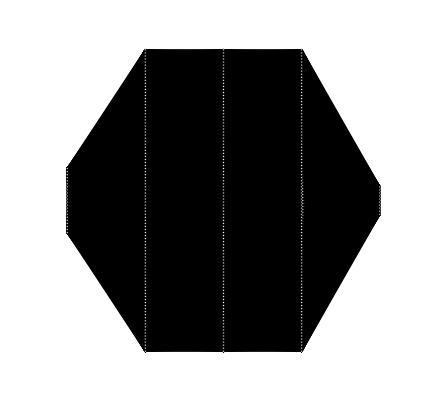

Confusion Matrix:

[[ 20   0   0   1   5   1   0   0   1   0]
 [  0 105   0   0   0   0   0   1   1   0]
 [  0   0 668   0   1   0   1   0   3   0]
 [  0   0   0 201   0   2   2   0   0   4]
 [  0   1   0   0   9   0   0   0   0   0]
 [  0   0   0   0   0 112   4   2   0   0]
 [  1   0   0   0   0   9  16   1   0   1]
 [  0   6   0   0   0   0   0 122   5   0]
 [  3   6   5   2   0   0   0   7  49   0]
 [  0   0   0   6   0   0   2   0   0  53]]


Species Accuracy Precision Recall F1-score 0 99.17% 83.33% 71.43% 76.92% 1 98.96% 88.98% 98.13% 93.33% 2 99.31% 99.26% 99.26% 99.26% 3 98.82% 95.71% 96.17% 95.94% 4 99.51% 60.00% 90.00% 72.00% 5 98.75% 90.32% 94.92% 92.56% 6 98.54% 64.00% 57.14% 60.38% 7 98.47% 91.73% 91.73% 91.73% 8 97.71% 83.05% 68.06% 74.81% 9 99.10% 91.38% 86.89% 89.08% Average 98.83% 84.78% 85.37% 84.60%

Iteration 72

Hidden Layers Training Fraction Number of Steps [100, 100, 100] 50% 2000

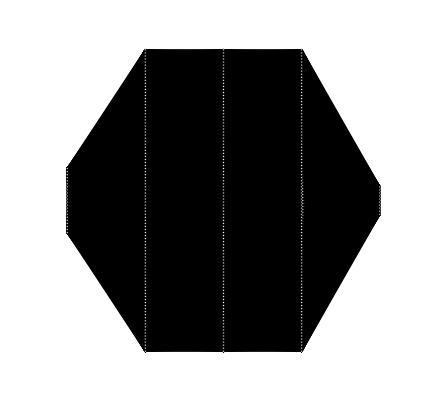

Confusion Matrix:

[[  59    1    1    2    2    0    0    0    2    0]
 [   0  259    0    0    1    0    0    7    1    0]
 [   1    0 1700    1    1    0    0    0    4    0]
 [   1    0    5  567    0    5    3    0    1   12]
 [   2    1    0    2   27    0    1    0    0    2]
 [   0    0    0    3    0  224   12    1    0    1]
 [   1    0    0    0    1    5   44    1    0    2]
 [   0   12    0    0    2    1    6  294    1    0]
 [   9   20   13    1    0    0    0   24   97    0]
 [   0    0    0   18    0    0    3    0    2  128]]


Species Accuracy Precision Recall F1-score 0 99.39% 80.82% 88.06% 84.29% 1 98.80% 88.40% 96.64% 92.34% 2 99.28% 98.89% 99.59% 99.24% 3 98.50% 95.45% 95.45% 95.45% 4 99.58% 79.41% 77.14% 78.26% 5 99.22% 95.32% 92.95% 94.12% 6 99.03% 63.77% 81.48% 71.54% 7 98.47% 89.91% 93.04% 91.45% 8 97.83% 89.81% 59.15% 71.32% 9 98.89% 88.28% 84.77% 86.49% Average 98.90% 87.01% 86.83% 86.45%

Iteration 73

Hidden Layers Training Fraction Number of Steps [100, 50, 25] 80% 100

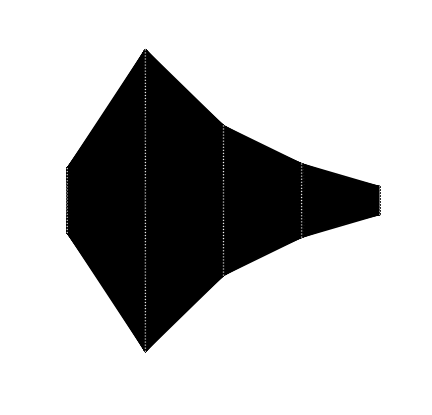

Confusion Matrix:

[[  0   0   0  28   0   0   0   3   0   0]
 [  0   0   0  69   0   0   0  40   0   0]
 [  0   0 678   1   0   0   0   0   0   0]
 [  0   0   4 246   0   0   0   3   0   0]
 [  0   0   0  12   0   0   0   1   0   0]
 [  0   0   0  71   0   0   0  16   0   0]
 [  0   0   0  10   0   0   0  14   0   0]
 [  0   0   0  14   0   0   0 129   0   0]
 [  0   0   9  26   0   0   0  15   0   0]
 [  0   0   1  39   0   0   0  10   0   0]]


Species Accuracy Precision Recall F1-score 0 97.85% nan% 0.00% nan% 1 92.43% nan% 0.00% nan% 2 98.96% 97.98% 99.85% 98.91% 3 80.75% 47.67% 97.23% 63.98% 4 99.10% nan% 0.00% nan% 5 93.95% nan% 0.00% nan% 6 98.33% nan% 0.00% nan% 7 91.94% 55.84% 90.21% 68.98% 8 96.53% nan% 0.00% nan% 9 96.53% nan% 0.00% nan% Average 94.64% 67.17% 28.73% 77.29%

Iteration 74

Hidden Layers Training Fraction Number of Steps [100, 50, 25] 50% 100

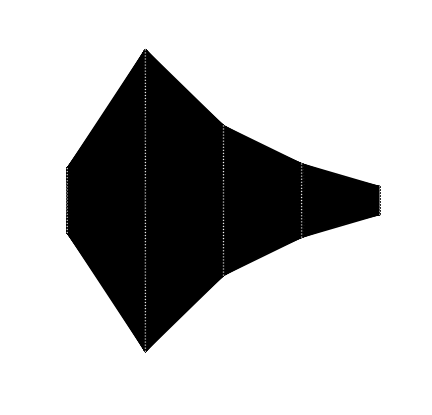

Confusion Matrix:

[[   0    0   23   42    0    0    0    8    0    0]
 [   0    0    0   48    0    0    0  214    0    0]
 [   0    0 1731    4    0    0    0    1    0    0]
 [   0    0   19  530    0    0    0   10    0    0]
 [   0    0    0   25    0    0    0   13    0    0]
 [   0    0    0  192    0    0    0   38    0    0]
 [   0    0    0   22    0    0    0   40    0    0]
 [   0    0    0    6    0    0    0  325    0    0]
 [   0    0   40   64    0    0    0   71    0    0]
 [   0    0    2   89    0    0    0   40    0    0]]


Species Accuracy Precision Recall F1-score 0 97.97% nan% 0.00% nan% 1 92.72% nan% 0.00% nan% 2 97.53% 95.37% 99.71% 97.49% 3 85.52% 51.86% 94.81% 67.05% 4 98.94% nan% 0.00% nan% 5 93.61% nan% 0.00% nan% 6 98.28% nan% 0.00% nan% 7 87.74% 42.76% 98.19% 59.58% 8 95.13% nan% 0.00% nan% 9 96.36% nan% 0.00% nan% Average 94.38% 63.33% 29.27% 74.71%

Iteration 75

Hidden Layers Training Fraction Number of Steps [100, 50, 25] 80% 200

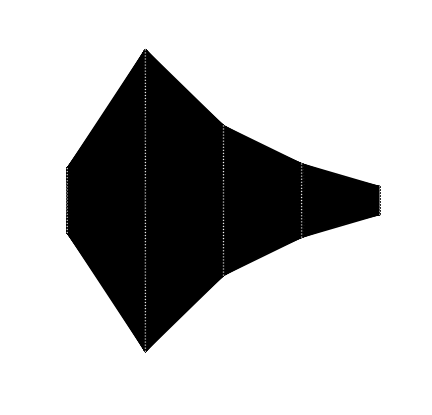

Confusion Matrix:

[[  0   3   1  34   0   0   0   1   0   0]
 [  0  45   0  20   0   0   0  47   0   0]
 [  0   0 685   1   0   0   0   0   0   0]
 [  0   1   4 224   0   0   0   0   0   0]
 [  0   9   0   1   0   0   0   1   0   0]
 [  0  26   0  35   0  33   0   7   0   0]
 [  0  19   0   4   0   1   0   1   0   0]
 [  0   2   0   1   0   0   0 113   0   0]
 [  0   3  14  29   0   0   0  21   0   0]
 [  0   6   0  47   0   0   0   0   0   0]]


Species Accuracy Precision Recall F1-score 0 97.29% nan% 0.00% nan% 1 90.55% 39.47% 40.18% 39.82% 2 98.61% 97.30% 99.85% 98.56% 3 87.70% 56.57% 97.82% 71.68% 4 99.24% nan% 0.00% nan% 5 95.21% 97.06% 32.67% 48.89% 6 98.26% nan% 0.00% nan% 7 94.37% 59.16% 97.41% 73.62% 8 95.34% nan% 0.00% nan% 9 96.32% nan% 0.00% nan% Average 95.29% 69.91% 36.79% 66.51%

Iteration 76

Hidden Layers Training Fraction Number of Steps [100, 50, 25] 50% 200

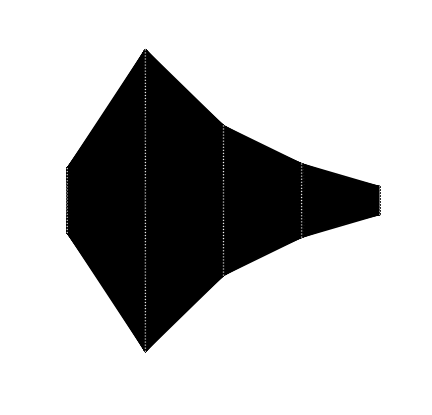

Confusion Matrix:

[[   0    5    2   72    0    0    0    1    0    0]
 [   0   27    0   19    0    0    0  228    0    0]
 [   0    0 1766    4    0    0    0    1    0    0]
 [   0    2   12  508    0    0    0    1    0    0]
 [   0   24    0    2    0    0    0    5    0    0]
 [   0    9    0  203    0    2    0   26    0    0]
 [   0   28    0   22    0    0    0   13    0    0]
 [   0    0    0    4    0    0    0  332    0    0]
 [   0    3   24   73    0    0    0   52    0    0]
 [   0    5    1  115    0    0    0    6    0    0]]


Species Accuracy Precision Recall F1-score 0 97.78% nan% 0.00% nan% 1 91.02% 26.21% 9.85% 14.32% 2 98.78% 97.84% 99.72% 98.77% 3 85.29% 49.71% 97.13% 65.76% 4 99.14% nan% 0.00% nan% 5 93.38% 100.00% 0.83% 1.65% 6 98.25% nan% 0.00% nan% 7 90.63% 49.92% 98.81% 66.33% 8 95.77% nan% 0.00% nan% 9 96.47% nan% 0.00% nan% Average 94.65% 64.74% 30.63% 49.37%

Iteration 77

Hidden Layers Training Fraction Number of Steps [100, 50, 25] 80% 500

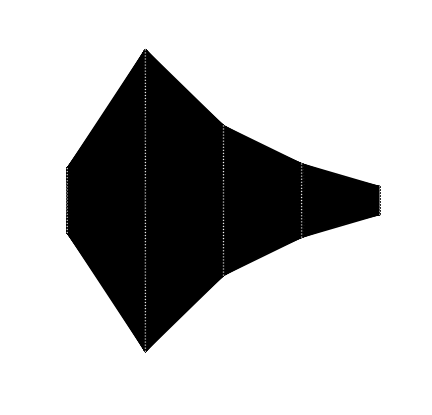

Confusion Matrix:

[[  0   5   1  22   0   1   0   1   0   0]
 [  0  63   0   0   0   0   0  46   0   0]
 [  0   0 669   0   0   2   0   0   0   0]
 [  0   0   0 227   0   3   0   0   1   0]
 [  0  12   0   3   0   0   0   1   0   0]
 [  0   0   0   7   0  91   0   1   0   0]
 [  0   0   0   2   0  16   0   0   0   0]
 [  0   6   0   0   0   2   0 131   0   0]
 [  0   5  11  19   0   0   0  20  11   0]
 [  0   2   1  51   0   2   0   3   1   0]]


Species Accuracy Precision Recall F1-score 0 97.92% nan% 0.00% nan% 1 94.72% 67.74% 57.80% 62.38% 2 98.96% 98.09% 99.70% 98.89% 3 92.49% 68.58% 98.27% 80.78% 4 98.89% nan% 0.00% nan% 5 97.64% 77.78% 91.92% 84.26% 6 98.75% nan% 0.00% nan% 7 94.44% 64.53% 94.24% 76.61% 8 96.04% 84.62% 16.67% 27.85% 9 95.83% nan% 0.00% nan% Average 96.57% 76.89% 45.86% 71.79%

Iteration 78

Hidden Layers Training Fraction Number of Steps [100, 50, 25] 50% 500

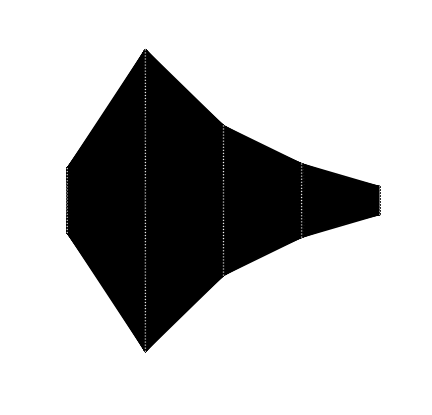

Confusion Matrix:

[[   0   11    2   56    0    5    0    1    5    0]
 [   0  176    0    2    0    0    0  107    1    0]
 [   0    1 1706    2    0    1    0    0    1    0]
 [   0    0    7  558    0   12    0    0    0    0]
 [   0    1    0   12    0    4    0   20    0    0]
 [   0    0    0    3    0  234    0    1    0    0]
 [   0    0    0    1    0   52    0    1    0    0]
 [   0   10    0    0    0    5    0  304    0    0]
 [   0   30   22   10    0    0    0   26   64    0]
 [   0    1    1  131    0    8    0    1    1    0]]


Species Accuracy Precision Recall F1-score 0 97.78% nan% 0.00% nan% 1 95.44% 76.52% 61.54% 68.22% 2 98.97% 98.16% 99.71% 98.93% 3 93.44% 72.00% 96.71% 82.54% 4 98.97% nan% 0.00% nan% 5 97.47% 72.90% 98.32% 83.72% 6 98.50% nan% 0.00% nan% 7 95.22% 65.94% 95.30% 77.95% 8 97.33% 88.89% 42.11% 57.14% 9 96.02% nan% 0.00% nan% Average 96.91% 79.07% 49.37% 78.08%

Iteration 79

Hidden Layers Training Fraction Number of Steps [100, 50, 25] 80% 1000

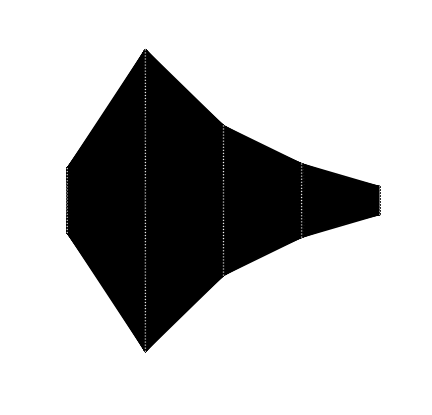

Confusion Matrix:

[[  0   5   0  16   0   0   0   0  14   1]
 [  0 103   0   0   0   1   0   2   2   0]
 [  0   1 684   1   0   0   0   0   0   0]
 [  0   0   3 214   0   0   0   0   0   3]
 [  0  13   0   1   0   1   0   0   0   0]
 [  0   0   0   1   0 104   0   0   0   2]
 [  0   1   0   1   0  13   0   0   0   3]
 [  0   6   0   0   0   0   0 107   0   0]
 [  0  12   7   2   0   0   0  15  37   0]
 [  0   1   0  38   0   4   0   0   0  20]]


Species Accuracy Precision Recall F1-score 0 97.50% nan% 0.00% nan% 1 96.94% 72.54% 95.37% 82.40% 2 99.17% 98.56% 99.71% 99.13% 3 95.41% 78.10% 97.27% 86.64% 4 98.96% nan% 0.00% nan% 5 98.47% 84.55% 97.20% 90.43% 6 98.75% nan% 0.00% nan% 7 98.40% 86.29% 94.69% 90.30% 8 96.39% 69.81% 50.68% 58.73% 9 96.39% 68.97% 31.75% 43.48% Average 97.64% 79.83% 56.67% 78.73%

Iteration 80

Hidden Layers Training Fraction Number of Steps [100, 50, 25] 50% 1000

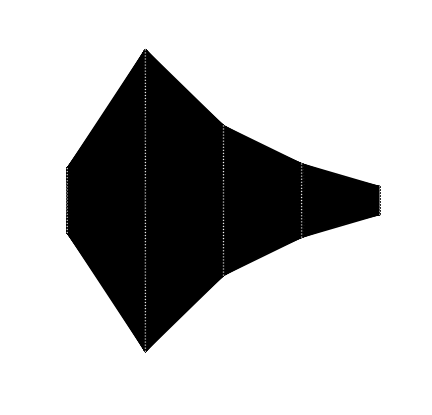

Confusion Matrix:

[[   9    3    1   26    0    1    0    1   22    1]
 [   0  265    0    1    0    0    0    8    7    0]
 [   0    2 1736    4    0    1    0    2    6    0]
 [   0    0    4  525    0    2    0    0    1   14]
 [   0   28    0    1    3    1    0    5    0    0]
 [   0    0    0    2    0  225    0    5    0    1]
 [   0    1    0    3    1   30    0    1    0   21]
 [   0   16    0    1    0    3    0  315    0    0]
 [   0   39   19    1    0    0    0   23   79    0]
 [   1    2    0   15    0    3    0    9    0  101]]


Species Accuracy Precision Recall F1-score 0 98.44% 90.00% 14.06% 24.32% 1 97.03% 74.44% 94.31% 83.20% 2 98.92% 98.64% 99.14% 98.89% 3 97.91% 90.67% 96.15% 93.33% 4 99.00% 75.00% 7.89% 14.29% 5 98.64% 84.59% 96.57% 90.18% 6 98.42% nan% 0.00% nan% 7 97.94% 85.37% 94.03% 89.49% 8 96.72% 68.70% 49.07% 57.25% 9 98.14% 73.19% 77.10% 75.09% Average 98.12% 82.29% 62.83% 69.56%

Iteration 81

Hidden Layers Training Fraction Number of Steps [100, 50, 25] 80% 1500

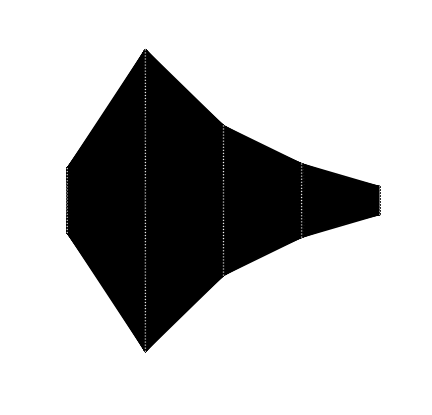

Confusion Matrix:

[[ 10   1   1   7   1   0   0   0   5   0]
 [  0 109   0   0   0   0   0   2   1   0]
 [  0   0 692   1   0   2   0   0   5   0]
 [  1   0   0 239   0   0   0   0   1   8]
 [  0   2   0   0   7   3   0   0   0   0]
 [  0   0   0   0   0  76   1   0   0   4]
 [  0   0   0   2   0   6   4   0   0  10]
 [  0   3   0   0   0   3   0 125   0   0]
 [  2   7   6   1   0   0   0  10  30   0]
 [  0   0   0   8   0   2   2   0   0  39]]


Species Accuracy Precision Recall F1-score 0 98.75% 76.92% 40.00% 52.63% 1 98.89% 89.34% 97.32% 93.16% 2 98.96% 99.00% 98.86% 98.93% 3 97.98% 92.64% 95.98% 94.28% 4 99.58% 87.50% 58.33% 70.00% 5 98.54% 82.61% 93.83% 87.86% 6 98.54% 57.14% 18.18% 27.59% 7 98.75% 91.24% 95.42% 93.28% 8 97.36% 71.43% 53.57% 61.22% 9 97.64% 63.93% 76.47% 69.64% Average 98.50% 81.18% 72.80% 74.86%

Iteration 82

Hidden Layers Training Fraction Number of Steps [100, 50, 25] 50% 1500

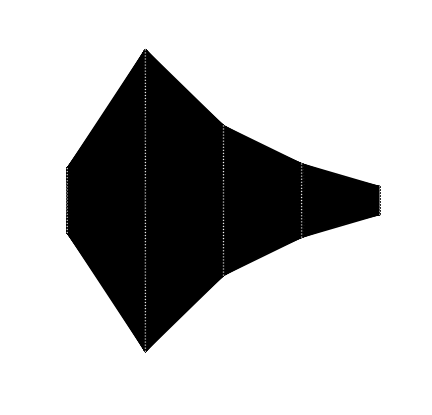

Confusion Matrix:

[[  19    0   23   27    0    2    2    1   16    1]
 [   0  253    0    0    0    0    2    8    1    0]
 [   0    0 1717    2    0    0    0    0    3    0]
 [   0    0    2  530    0    6    0    0    2   49]
 [   0    3    0    3   27    1    1    0    2    3]
 [   0    0    0    0    0  217    2    1    0    1]
 [   0    0    0    5    1   14   21    4    0    0]
 [   0   16    0    1    0    6    0  310    0    0]
 [   0   30   23    3    0    0    0   19   80    0]
 [   0    0    1   24    0    3    5    0    0  104]]


Species Accuracy Precision Recall F1-score 0 98.00% 100.00% 20.88% 34.55% 1 98.33% 83.77% 95.83% 89.40% 2 98.50% 97.23% 99.71% 98.45% 3 96.55% 89.08% 89.98% 89.53% 4 99.61% 96.43% 67.50% 79.41% 5 99.00% 87.15% 98.19% 92.34% 6 99.00% 63.64% 46.67% 53.85% 7 98.44% 90.38% 93.09% 91.72% 8 97.25% 76.92% 51.61% 61.78% 9 97.58% 65.82% 75.91% 70.51% Average 98.23% 85.04% 73.94% 76.15%

Iteration 83

Hidden Layers Training Fraction Number of Steps [100, 50, 25] 80% 2000

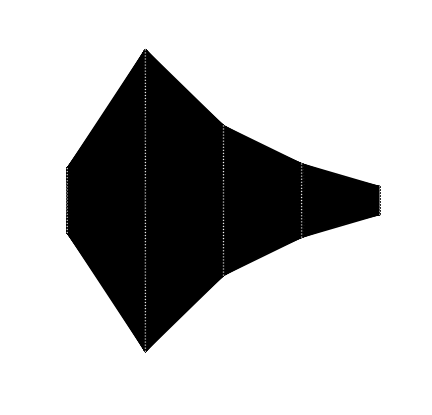

Confusion Matrix:

[[ 28   0   0   2   0   1   0   0   1   0]
 [  3  89   0   0   0   0   0   2   3   0]
 [  1   0 702   0   0   0   0   0   0   0]
 [  0   0   3 226   0   0   0   0   0   3]
 [  1   1   0   0   7   1   0   0   0   3]
 [  0   0   0   0   0  92   4   0   0   4]
 [  1   0   0   1   0   8  15   0   0   1]
 [  0   5   0   0   0   2   1 118   1   0]
 [  4   2   4   0   0   0   0   8  37   0]
 [  0   0   0   1   0   0   0   0   2  51]]


Species Accuracy Precision Recall F1-score 0 99.03% 73.68% 87.50% 80.00% 1 98.89% 91.75% 91.75% 91.75% 2 99.44% 99.01% 99.86% 99.43% 3 99.31% 98.26% 97.41% 97.84% 4 99.58% 100.00% 53.85% 70.00% 5 98.61% 88.46% 92.00% 90.20% 6 98.89% 75.00% 57.69% 65.22% 7 98.68% 92.19% 92.91% 92.55% 8 98.26% 84.09% 67.27% 74.75% 9 99.03% 82.26% 94.44% 87.93% Average 98.97% 88.47% 83.47% 84.97%

Iteration 84

Hidden Layers Training Fraction Number of Steps [100, 50, 25] 50% 2000

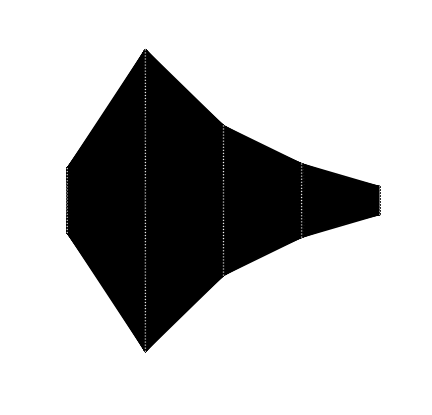

Confusion Matrix:

[[  54    0    2    6    1    0    1    0    9    0]
 [   2  251    0    0    3    0    0    0    6    0]
 [   2    0 1721    7    0    1    0    0    7    0]
 [   0    0    2  533    0   12    1    0    2   22]
 [   1    0    0    2   20    0    0    2    0    1]
 [   0    0    0   10    0  227    2    2    0    0]
 [   0    0    0    5    1   24   21    0    0    0]
 [   0   21    0    2    0    7    0  318    0    0]
 [   0   39   21    0    0    0    0   13   85    0]
 [   0    0    0   10    0    2    2    1    2  111]]


Species Accuracy Precision Recall F1-score 0 99.33% 91.53% 73.97% 81.82% 1 98.03% 80.71% 95.80% 87.61% 2 98.83% 98.57% 99.02% 98.79% 3 97.75% 92.70% 93.18% 92.94% 4 99.69% 80.00% 76.92% 78.43% 5 98.33% 83.15% 94.19% 88.33% 6 99.00% 77.78% 41.18% 53.85% 7 98.67% 94.64% 91.38% 92.98% 8 97.25% 76.58% 53.80% 63.20% 9 98.89% 82.84% 86.72% 84.73% Average 98.58% 85.85% 80.62% 82.27%

Iteration 85

Hidden Layers Training Fraction Number of Steps [25, 50, 100] 80% 100

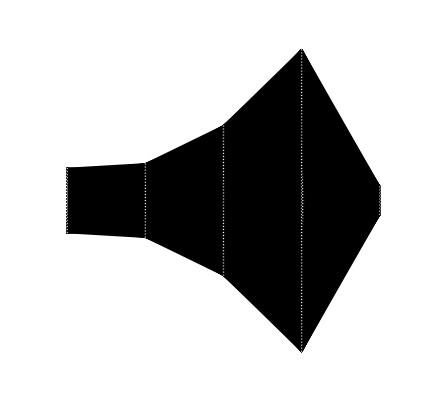

Confusion Matrix:

[[  0   7   0  22   0   0   0   0   0   0]
 [  0  80   0  15   0   0   0   9   0   0]
 [  0   1 694   0   0   0   0   0   0   0]
 [  0   9   1 206   0   0   0   0   0   0]
 [  0   8   0   1   0   0   0   1   0   0]
 [  0  40   0  45   0   0   0   7   0   0]
 [  0  23   0   2   0   0   0   0   0   0]
 [  0  60   0   2   0   0   0  76   0   0]
 [  0  10  15  30   0   0   0  14   0   0]
 [  0  34   0  27   0   0   0   0   0   0]]


Species Accuracy Precision Recall F1-score 0 97.98% nan% 0.00% nan% 1 84.99% 29.41% 76.92% 42.55% 2 98.82% 97.75% 99.86% 98.79% 3 89.30% 58.86% 95.37% 72.79% 4 99.31% nan% 0.00% nan% 5 93.61% nan% 0.00% nan% 6 98.26% nan% 0.00% nan% 7 93.54% 71.03% 55.07% 62.04% 8 95.21% nan% 0.00% nan% 9 95.76% nan% 0.00% nan% Average 94.68% 64.26% 32.72% 69.04%

Iteration 86

Hidden Layers Training Fraction Number of Steps [25, 50, 100] 50% 100

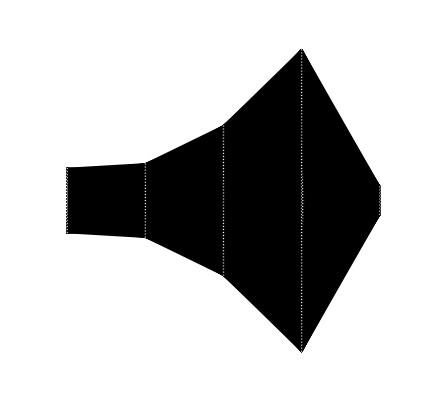

Confusion Matrix:

[[   0    0   23   47    0    0    0    3    0    0]
 [   0    0    0  149    0    0    0  132    0    0]
 [   0    0 1761    4    0    0    0    1    0    0]
 [   0    0   15  504    0    0    0    9    0    0]
 [   0    0    0   37    0    0    0    2    0    0]
 [   0    0    0  198    0    0    0   51    0    0]
 [   0    0    0   14    0    0    0   44    0    0]
 [   0    0    0   13    0    0    0  319    0    0]
 [   0    0   47   45    0    0    0   50    0    0]
 [   0    0    2   94    0    0    0   33    0    0]]


Species Accuracy Precision Recall F1-score 0 97.97% nan% 0.00% nan% 1 92.19% nan% 0.00% nan% 2 97.44% 95.29% 99.72% 97.45% 3 82.62% 45.61% 95.45% 61.73% 4 98.92% nan% 0.00% nan% 5 93.08% nan% 0.00% nan% 6 98.39% nan% 0.00% nan% 7 90.60% 49.53% 96.08% 65.37% 8 96.05% nan% 0.00% nan% 9 96.41% nan% 0.00% nan% Average 94.37% 63.48% 29.13% 74.85%

Iteration 87

Hidden Layers Training Fraction Number of Steps [25, 50, 100] 80% 200

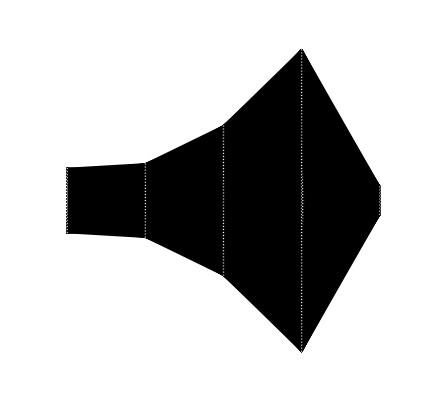

Confusion Matrix:

[[  0   2   0  29   0   2   0   0   0   0]
 [  0  13   0   9   0  23   0  73   0   0]
 [  0   1 689   1   0   0   0   0   0   0]
 [  0   0   5 206   0   4   0   0   0   0]
 [  0   0   0   0   0  13   0   0   0   0]
 [  0   1   0  47   0  31   0   5   0   0]
 [  0   7   0   3   0  23   0   1   0   0]
 [  0   0   0   0   0   0   0 132   0   0]
 [  0   0  14  28   0   0   0  23   0   0]
 [  0   2   0  44   0   6   0   2   0   0]]


Species Accuracy Precision Recall F1-score 0 97.71% nan% 0.00% nan% 1 91.80% 50.00% 11.02% 18.06% 2 98.54% 97.32% 99.71% 98.50% 3 88.19% 56.13% 95.81% 70.79% 4 99.10% nan% 0.00% nan% 5 91.38% 30.39% 36.90% 33.33% 6 97.64% nan% 0.00% nan% 7 92.77% 55.93% 100.00% 71.74% 8 95.48% nan% 0.00% nan% 9 96.25% nan% 0.00% nan% Average 94.89% 57.95% 34.34% 58.48%

Iteration 88

Hidden Layers Training Fraction Number of Steps [25, 50, 100] 50% 200

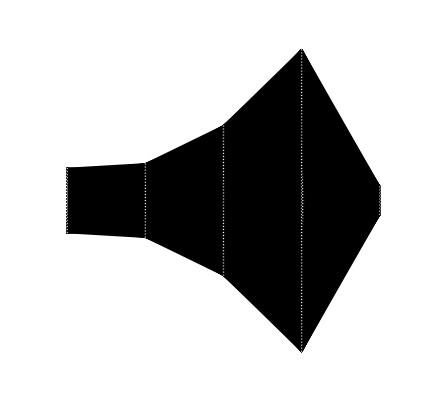

Confusion Matrix:

[[   0    4    0   73    0    3    0    4    0    0]
 [   0   88    0   16    0   14    0  159    0    0]
 [   0    2 1744    1    0    1    0    2    0    0]
 [   0    4   17  529    0    1    0    1    0    0]
 [   0   22    0    5    0    1    0    2    0    0]
 [   0   48    0  118    0   48    0   19    0    0]
 [   0   45    0    4    0    6    0    3    0    0]
 [   0    8    0    0    0    0    0  329    0    0]
 [   0    2   27   56    0    1    0   49    0    0]
 [   0   12    3  117    0    5    0    4    0    0]]


Species Accuracy Precision Recall F1-score 0 97.66% nan% 0.00% nan% 1 90.66% 37.45% 31.77% 34.38% 2 98.53% 97.38% 99.66% 98.50% 3 88.52% 57.56% 95.83% 71.92% 4 99.17% nan% 0.00% nan% 5 93.97% 60.00% 20.60% 30.67% 6 98.39% nan% 0.00% nan% 7 93.02% 57.52% 97.63% 72.39% 8 96.25% nan% 0.00% nan% 9 96.08% nan% 0.00% nan% Average 95.22% 61.98% 34.55% 61.57%

Iteration 89

Hidden Layers Training Fraction Number of Steps [25, 50, 100] 80% 500

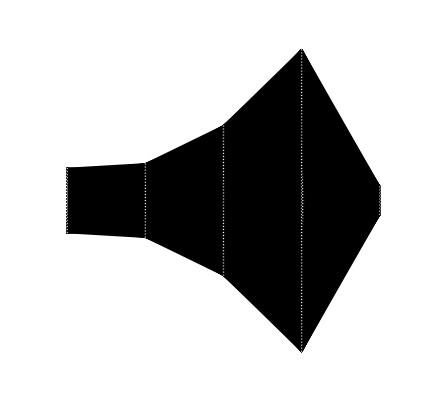

Confusion Matrix:

[[  0   6   2  22   0   5   0   0   0   2]
 [  0  66   0   0   0   0   0  35   1   0]
 [  0   0 721   1   0   2   0   0   1   0]
 [  0   0   2 176   0  10   0   1   0   1]
 [  0   0   0   1   0   1   0   2   0  16]
 [  0   0   0   0   0  90   0   2   0   1]
 [  0   0   0   0   0   7   0   1   0  11]
 [  0   1   0   0   0   1   0 135   0   0]
 [  0  10  10   3   0   0   0  14  19   0]
 [  0   3   0  14   0  13   0   4   0  26]]


Species Accuracy Precision Recall F1-score 0 97.43% nan% 0.00% nan% 1 96.11% 76.74% 64.71% 70.21% 2 98.75% 98.10% 99.45% 98.77% 3 96.18% 81.11% 92.63% 86.49% 4 98.61% nan% 0.00% nan% 5 97.08% 69.77% 96.77% 81.08% 6 98.68% nan% 0.00% nan% 7 95.76% 69.59% 98.54% 81.57% 8 97.29% 90.48% 33.93% 49.35% 9 95.48% 45.61% 43.33% 44.44% Average 97.14% 75.91% 52.94% 73.13%

Iteration 90

Hidden Layers Training Fraction Number of Steps [25, 50, 100] 50% 500

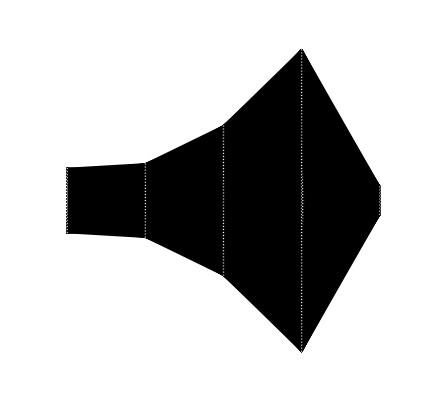

Confusion Matrix:

[[   0    4    0   58    0    2    5    0    2    0]
 [   0  182    0    2    0    0    0  104    6    0]
 [   0    0 1690    4    0    2    0    0    2    0]
 [   0    1    7  554    0   15    0    0    1    0]
 [   0   31    0    4    0    0    2    1    0    0]
 [   0    0    0    4    0  230    2    3    0    0]
 [   0    0    0    0    0   29   25    1    0    0]
 [   0    9    0    0    0    5    0  318    0    0]
 [   0   26   29    7    0    0    0   23   62    0]
 [   0    4    2  123    0   11    2    1    2    0]]


Species Accuracy Precision Recall F1-score 0 98.03% nan% 0.00% nan% 1 94.80% 70.82% 61.90% 66.06% 2 98.72% 97.80% 99.53% 98.66% 3 93.72% 73.28% 95.85% 83.06% 4 98.94% nan% 0.00% nan% 5 97.97% 78.23% 96.23% 86.30% 6 98.86% 69.44% 45.45% 54.95% 7 95.91% 70.51% 95.78% 81.23% 8 97.28% 82.67% 42.18% 55.86% 9 95.97% nan% 0.00% nan% Average 97.02% 77.54% 53.69% 75.16%

Iteration 91

Hidden Layers Training Fraction Number of Steps [25, 50, 100] 80% 1000

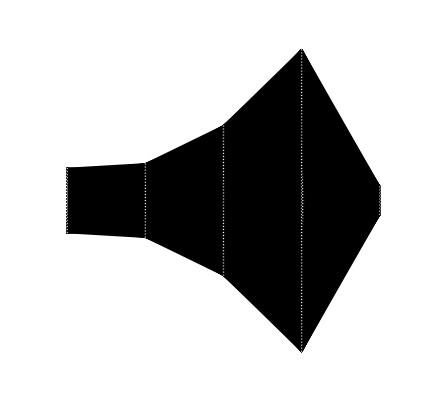

Confusion Matrix:

[[  7   6   4   9   0   0   1   0   0   0]
 [  0 111   0   1   0   0   0   4   0   2]
 [  0   0 684   1   0   0   0   0   0   0]
 [  1   0   3 205   0   2   1   0   0   6]
 [  0   1   0   2   7   0   1   0   0   1]
 [  0   0   0   0   0  86   2   3   0   0]
 [  1   0   0   2   0   4   9   0   0   9]
 [  0   5   0   0   0   1   1 138   0   0]
 [  0  15   6   1   1   0   0  11  24   0]
 [  0   2   0   5   0   1   0   1   0  51]]


Species Accuracy Precision Recall F1-score 0 98.47% 77.78% 25.93% 38.89% 1 97.50% 79.29% 94.07% 86.05% 2 99.03% 98.13% 99.85% 98.99% 3 97.64% 90.71% 94.04% 92.34% 4 99.58% 87.50% 58.33% 70.00% 5 99.10% 91.49% 94.51% 92.97% 6 98.47% 60.00% 36.00% 45.00% 7 98.19% 87.90% 95.17% 91.39% 8 97.64% 100.00% 41.38% 58.54% 9 98.12% 73.91% 85.00% 79.07% Average 98.37% 84.67% 72.43% 75.32%

Iteration 92

Hidden Layers Training Fraction Number of Steps [25, 50, 100] 50% 1000

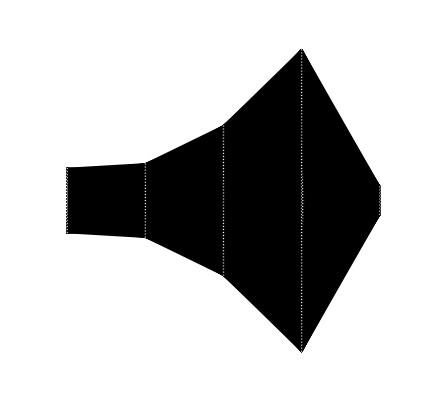

Confusion Matrix:

[[   5    7    9   37    0    2    0    0    9    2]
 [   0  240    0    0    0    0    0   12    0    2]
 [   0    0 1712    3    1    3    0    1    3    0]
 [   0    0    5  549    0    9    0    0    0   13]
 [   0    4    0    4   25    0    0    0    0    4]
 [   0    0    0   11    0  216    3    1    0    0]
 [   0    0    0    1    0   14   13    0    0   22]
 [   0   21    0    0    0    4    1  329    0    1]
 [   0   45   25    6    0    0    0   25   62    0]
 [   0    3    0   20    0    1    0    0    0  112]]


Species Accuracy Precision Recall F1-score 0 98.17% 100.00% 7.04% 13.16% 1 97.39% 75.00% 94.49% 83.62% 2 98.61% 97.77% 99.36% 98.56% 3 96.97% 87.00% 95.31% 90.97% 4 99.64% 96.15% 67.57% 79.37% 5 98.67% 86.75% 93.51% 90.00% 6 98.86% 76.47% 26.00% 38.81% 7 98.17% 89.40% 92.42% 90.88% 8 96.86% 83.78% 38.04% 52.32% 9 98.11% 71.79% 82.35% 76.71% Average 98.14% 86.41% 69.61% 71.44%

Iteration 93

Hidden Layers Training Fraction Number of Steps [25, 50, 100] 80% 1500

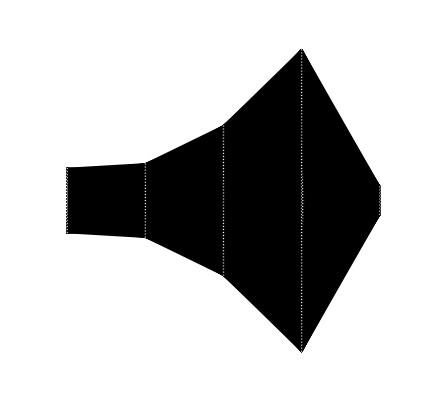

Confusion Matrix:

[[ 17   1   0   7   2   0   2   1   3   0]
 [  0  80   0   0   0   0   0   5   3   0]
 [  0   0 682   1   2   1   0   1   3   0]
 [  1   0   2 228   0   2   0   0   1   7]
 [  0   0   0   0   8   2   0   0   0   0]
 [  0   0   0   0   0  94   1   0   0   2]
 [  0   0   0   0   0  15   6   1   0   3]
 [  0   3   0   0   0   3   0 128   0   0]
 [  0  18   5   0   0   0   0   9  26   0]
 [  0   0   0  16   0   7   1   0   1  38]]


Species Accuracy Precision Recall F1-score 0 98.82% 94.44% 51.52% 66.67% 1 97.92% 78.43% 90.91% 84.21% 2 98.96% 98.98% 98.84% 98.91% 3 97.43% 90.48% 94.61% 92.49% 4 99.58% 66.67% 80.00% 72.73% 5 97.71% 75.81% 96.91% 85.07% 6 98.40% 60.00% 24.00% 34.29% 7 98.40% 88.28% 95.52% 91.76% 8 97.01% 70.27% 44.83% 54.74% 9 97.43% 76.00% 60.32% 67.26% Average 98.17% 79.94% 73.74% 74.81%

Iteration 94

Hidden Layers Training Fraction Number of Steps [25, 50, 100] 50% 1500

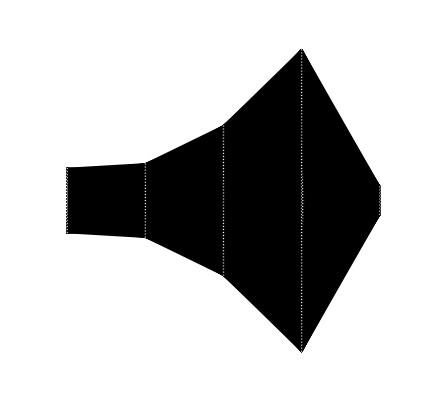

Confusion Matrix:

[[  40    5    0   15    5    2    0    2    7    1]
 [   2  257    0    0    2    0    1    7    1    1]
 [   1    0 1743    2    1    1    0    0    7    0]
 [   0    0    2  514    0    1    1    0    2   25]
 [   1    0    0    0   23    2    1    0    0    1]
 [   0    0    0    2    0  228    0    0    0    4]
 [   0    0    0    0    1   30    4    3    0   25]
 [   0   13    0    0    0    5    0  305    0    0]
 [   9   39   16    0    0    0    0   33   72    0]
 [   0    1    0   25    0    8    0    0    0   98]]


Species Accuracy Precision Recall F1-score 0 98.61% 75.47% 51.95% 61.54% 1 98.00% 81.59% 94.83% 87.71% 2 99.17% 98.98% 99.32% 99.15% 3 97.91% 92.11% 94.31% 93.20% 4 99.61% 71.88% 82.14% 76.67% 5 98.47% 82.31% 97.44% 89.24% 6 98.28% 57.14% 6.35% 11.43% 7 98.25% 87.14% 94.43% 90.64% 8 96.83% 80.90% 42.60% 55.81% 9 97.47% 63.23% 74.24% 68.29% Average 98.26% 79.07% 73.76% 73.37%

Iteration 95

Hidden Layers Training Fraction Number of Steps [25, 50, 100] 80% 2000

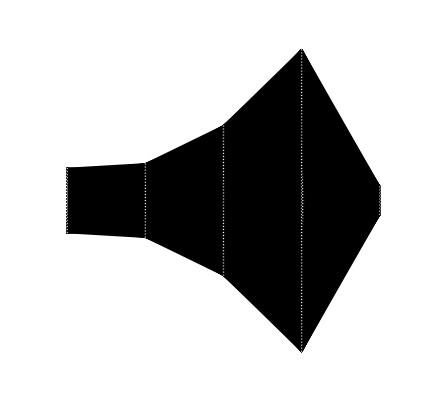

Confusion Matrix:

[[ 15   1   1   6   2   0   0   1   3   0]
 [  1  98   0   0   0   0   0   3   2   0]
 [  0   0 700   4   1   1   0   0   1   0]
 [  0   0   0 222   0   1   1   0   0  16]
 [  0   0   0   0   8   1   2   0   0   1]
 [  0   0   0   0   0  80   3   0   0   1]
 [  0   0   0   0   1   2  16   2   0   3]
 [  0   4   0   0   0   2   1 115   0   0]
 [  1  15   5   1   0   0   0   8  27   0]
 [  0   1   0   3   1   1   2   0   0  52]]


Species Accuracy Precision Recall F1-score 0 98.89% 88.24% 51.72% 65.22% 1 98.12% 82.35% 94.23% 87.89% 2 99.10% 99.15% 99.01% 99.08% 3 97.78% 94.07% 92.50% 93.28% 4 99.37% 61.54% 66.67% 64.00% 5 99.17% 90.91% 95.24% 93.02% 6 98.82% 64.00% 66.67% 65.31% 7 98.54% 89.15% 94.26% 91.63% 8 97.50% 81.82% 47.37% 60.00% 9 97.98% 71.23% 86.67% 78.20% Average 98.53% 82.25% 79.43% 79.76%

Iteration 96

Hidden Layers Training Fraction Number of Steps [25, 50, 100] 50% 2000

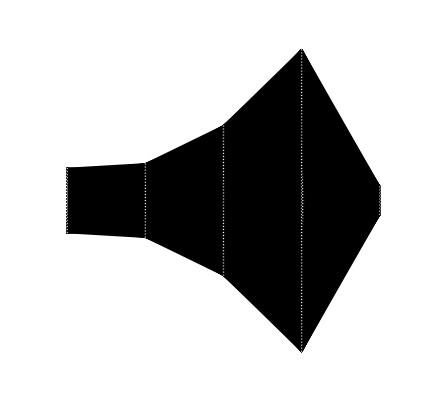

Confusion Matrix:

[[  38    0    0   17    6    1    3    0    4    0]
 [   1  244    0    0    0    0    1    8    1    0]
 [   0    0 1765    6    2    0    0    0    3    0]
 [   2    0    4  519    0    5    1    0    0   22]
 [   0    1    0    4   24    3    1    0    0    1]
 [   0    0    0    7    0  236    2    1    0    0]
 [   0    0    0    2    1   14   31    1    0    2]
 [   0   12    0    0    0    7    0  315    0    0]
 [   5   27   17    1    0    0    0   34   65    0]
 [   1    0    1    7    0    1    5    0    1  114]]


Species Accuracy Precision Recall F1-score 0 98.89% 80.85% 55.07% 65.52% 1 98.58% 85.92% 95.69% 90.54% 2 99.08% 98.77% 99.38% 99.07% 3 97.83% 92.18% 93.85% 93.01% 4 99.47% 72.73% 70.59% 71.64% 5 98.86% 88.39% 95.93% 92.01% 6 99.08% 70.45% 60.78% 65.26% 7 98.25% 87.74% 94.31% 90.91% 8 97.41% 87.84% 43.62% 58.30% 9 98.86% 82.01% 87.69% 84.76% Average 98.63% 84.69% 79.69% 81.10%

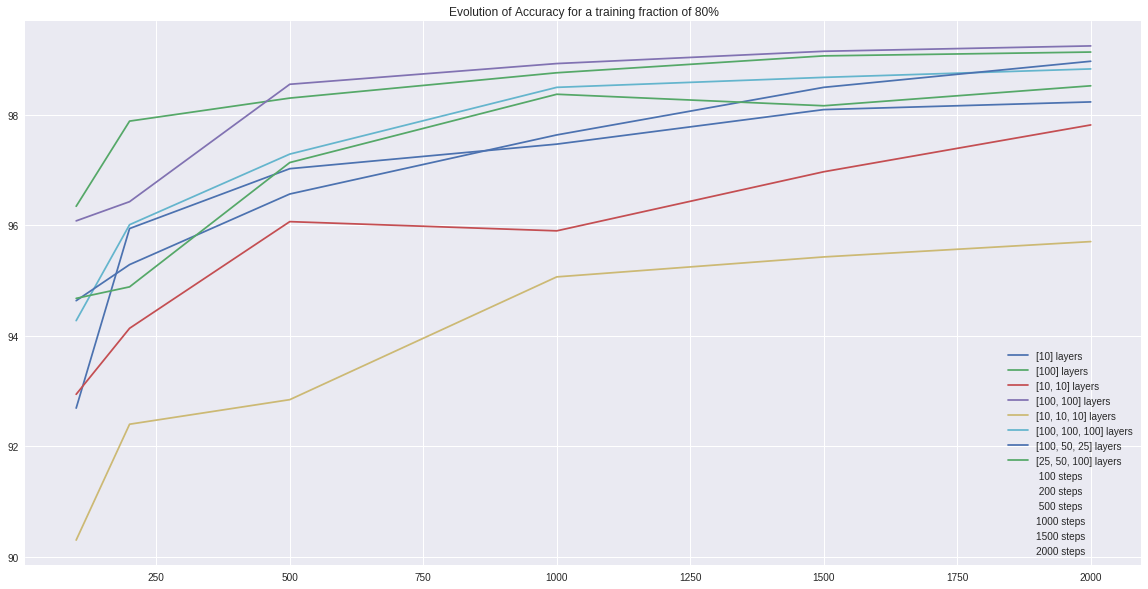

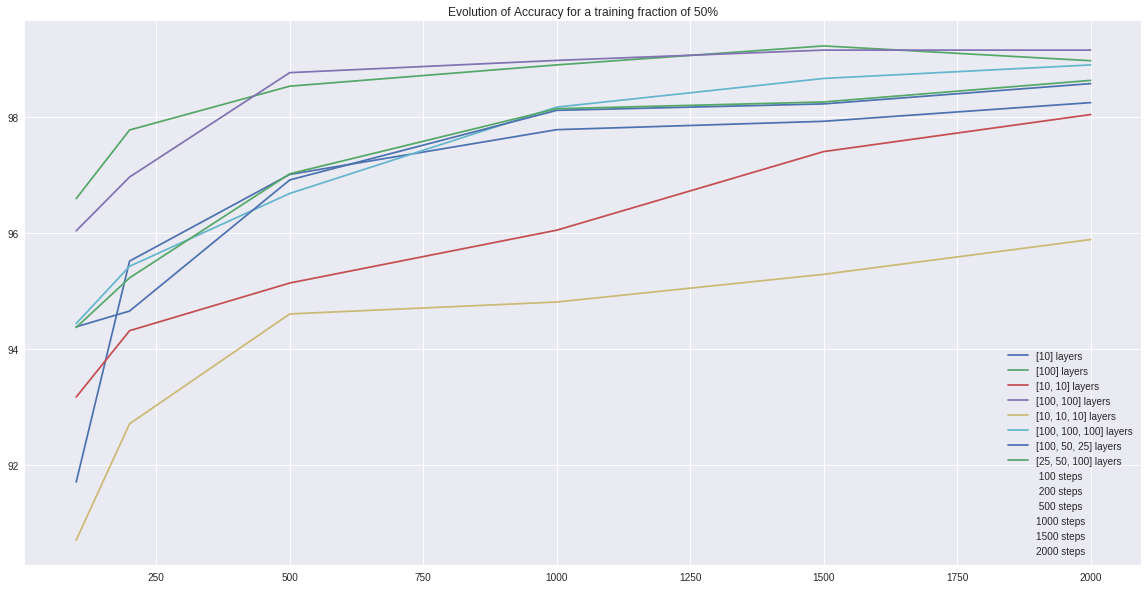

In [32]:
# simple data splitting results
display_model_results(evaluations)

### Cross-Validation approach to dataset splitting
In **k-fold** cross-validation, the original sample is randomly partitioned into k equal size subsamples.

In **stratified k-fold** cross-validation, the folds are selected so that the mean response value is approximately equal in all the folds.

To use one or the other, update the global setting `CROSS_VALIDATION_FUNCTION` in the [Initialize constants](#Initialize-constants) section

**Warning:** Depending on the complexity of the architecture and the number of steps in the training, this operation may take some time

In [36]:
# k-fold cross validation
# this may take a while

# adjustment for k-fold: num_total_model_steps = num_steps * num_folds
kfcv_evaluations = run_model_iterations(df, labels, kFoldCV_tf_data_generator)    


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpfrd8qw_a', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f48ac806d68>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpfrd8qw_a/model.ckpt.
INFO:tensorflow:loss = 280.60938, step = 0
INFO:tensorf

INFO:tensorflow:Loss for final step: 49.17637.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-17-23:34:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6uinp4zf/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-17-23:34:52
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.87456685, average_loss = 0.4774856, global_step = 1000, loss = 45.934116
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6uinp4zf/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpr3lnh8rs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_

INFO:tensorflow:loss = 44.190445, step = 1300 (0.550 sec)
INFO:tensorflow:global_step/sec: 185.313
INFO:tensorflow:loss = 33.60945, step = 1400 (0.539 sec)
INFO:tensorflow:global_step/sec: 170.42
INFO:tensorflow:loss = 38.57124, step = 1500 (0.587 sec)
INFO:tensorflow:global_step/sec: 184.038
INFO:tensorflow:loss = 38.105774, step = 1600 (0.546 sec)
INFO:tensorflow:global_step/sec: 173.41
INFO:tensorflow:loss = 33.80394, step = 1700 (0.574 sec)
INFO:tensorflow:global_step/sec: 170.448
INFO:tensorflow:loss = 36.376286, step = 1800 (0.590 sec)
INFO:tensorflow:global_step/sec: 183.204
INFO:tensorflow:loss = 37.46893, step = 1900 (0.542 sec)
INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp8_6zik3g/model.ckpt.
INFO:tensorflow:Loss for final step: 37.544228.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-17-23:35:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8_6zik3g/

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpktgt5yc4/model.ckpt.
INFO:tensorflow:loss = 267.88416, step = 0
INFO:tensorflow:global_step/sec: 157.008
INFO:tensorflow:loss = 67.53023, step = 100 (0.640 sec)
INFO:tensorflow:global_step/sec: 180.73
INFO:tensorflow:loss = 34.462757, step = 200 (0.556 sec)
INFO:tensorflow:global_step/sec: 183.793
INFO:tensorflow:loss = 41.919506, step = 300 (0.543 sec)
INFO:tensorflow:global_step/sec: 192.553
INFO:tensorflow:loss = 39.5614, step = 400 (0.520 sec)
INFO:tensorflow:global_step/sec: 175.09
INFO:tensorflow:loss = 25.937485, step = 500 (0.573 sec)
INFO:tensorflow:global_step/sec: 172.795
INFO:tensorflow:loss = 29.496923, step = 600 (0.580 sec)
INFO:tensorflow:global_step/sec: 174.021
INFO:tensorflow:loss = 26.246096, step = 700 (0.573 sec

INFO:tensorflow:global_step/sec: 176.7
INFO:tensorflow:loss = 12.142789, step = 600 (0.566 sec)
INFO:tensorflow:global_step/sec: 179.258
INFO:tensorflow:loss = 16.276636, step = 700 (0.558 sec)
INFO:tensorflow:global_step/sec: 185.096
INFO:tensorflow:loss = 23.191128, step = 800 (0.546 sec)
INFO:tensorflow:global_step/sec: 179.003
INFO:tensorflow:loss = 9.614097, step = 900 (0.555 sec)
INFO:tensorflow:global_step/sec: 187.618
INFO:tensorflow:loss = 27.977076, step = 1000 (0.534 sec)
INFO:tensorflow:global_step/sec: 182.528
INFO:tensorflow:loss = 18.451262, step = 1100 (0.546 sec)
INFO:tensorflow:global_step/sec: 182.718
INFO:tensorflow:loss = 17.295967, step = 1200 (0.549 sec)
INFO:tensorflow:global_step/sec: 182.889
INFO:tensorflow:loss = 5.97901, step = 1300 (0.551 sec)
INFO:tensorflow:global_step/sec: 172.928
INFO:tensorflow:loss = 16.796625, step = 1400 (0.573 sec)
INFO:tensorflow:global_step/sec: 170.145
INFO:tensorflow:loss = 17.363749, step = 1500 (0.586 sec)
INFO:tensorflow:glo

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpurikvvba/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp35vbxa2s', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f46cb8fc400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:G

KeyboardInterrupt: ignored

Num Results: 18


Iteration 1

Hidden Layers Training Fraction Number of Steps [10] 80% 100

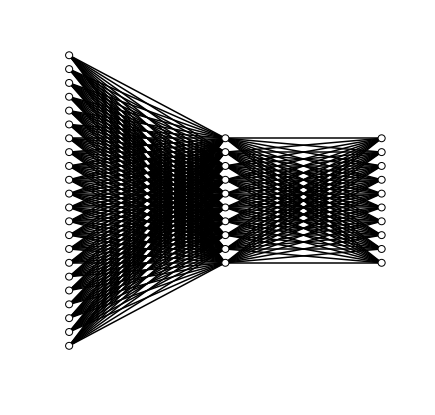

Confusion Matrix:

[[ 46   1   0   3   0   0   0   4   0   0]
 [  0  18  11  16   0   0   0   3  14   0]
 [  0   1  53  45   0   0   0  10   0   0]
 [  0   0   3 127   0   3   0   2   0   0]
 [  0   0   4   1   0   4   0   9  12   0]
 [  1   0   0   2   0  90   0   2   0   0]
 [  0   0   0   9   0   0   0   5   0   0]
 [  5   0   0   2   0   3   0 210   5   0]
 [  0   0   0   0   0   1   0   0 695   0]
 [  1   0   0  10   0   5   0   7   0   0]]


Species Accuracy Precision Recall F1-score 0 98.96% 86.79% 85.19% 85.98% 1 96.81% 90.00% 29.03% 43.90% 2 94.87% 74.65% 48.62% 58.89% 3 93.35% 59.07% 94.07% 72.57% 4 97.92% nan% 0.00% nan% 5 98.54% 84.91% 94.74% 89.55% 6 99.03% nan% 0.00% nan% 7 96.05% 83.33% 93.33% 88.05% 8 97.78% 95.73% 99.86% 97.75% 9 98.41% nan% 0.00% nan% Average 97.17% 82.07% 54.48% 76.67%

Iteration 2

Hidden Layers Training Fraction Number of Steps [10] 80% 500

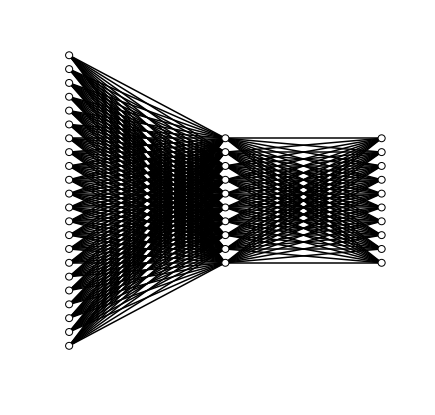

Confusion Matrix:

[[ 51   1   0   0   0   0   0   2   0   0]
 [  0  30  10  14   0   0   0   0   8   0]
 [  0   2 107   0   0   0   0   0   0   0]
 [  0   0   7 124   0   1   0   3   0   0]
 [  0   1   0   0  27   1   0   1   0   0]
 [  0   0   0   1   0  94   0   0   0   0]
 [  1   0  12   1   0   0   0   0   0   0]
 [  2   0   0   0   0   2   0 221   0   0]
 [  0   1   0   0   1   0   0   1 693   0]
 [  1   0   0   2   0   5   0   8   0   7]]


Species Accuracy Precision Recall F1-score 0 99.51% 92.73% 94.44% 93.58% 1 97.44% 85.71% 48.39% 61.86% 2 97.85% 78.68% 98.17% 87.35% 3 97.99% 87.32% 91.85% 89.53% 4 99.72% 96.43% 90.00% 93.10% 5 99.31% 91.26% 98.95% 94.95% 6 99.03% nan% 0.00% nan% 7 98.68% 93.64% 98.22% 95.88% 8 99.24% 98.86% 99.57% 99.21% 9 98.89% 100.00% 30.43% 46.67% Average 98.77% 91.63% 75.00% 84.68%

Iteration 3

Hidden Layers Training Fraction Number of Steps [10] 80% 1000

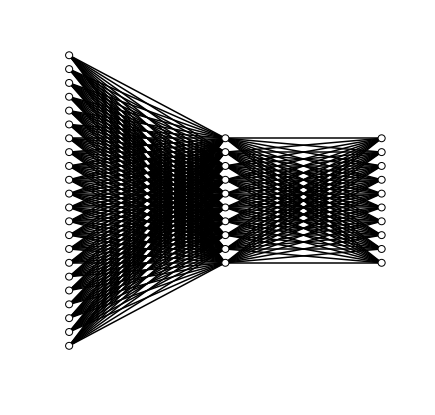

Confusion Matrix:

[[ 49   1   0   1   0   0   0   3   0   0]
 [  0  45   1  10   0   0   0   0   6   0]
 [  0   2 106   1   0   0   0   0   0   0]
 [  0   0   6 128   0   1   0   0   0   0]
 [  0   0   0   0  27   1   0   1   1   0]
 [  2   0   0   0   0  91   0   1   0   1]
 [  0   0   8   2   0   2   1   1   0   0]
 [  2   0   0   0   0   3   0 218   1   1]
 [  0   2   1   0   0   1   0   0 692   0]
 [  1   0   0   0   2   5   0   3   0  12]]


Species Accuracy Precision Recall F1-score 0 99.31% 90.74% 90.74% 90.74% 1 98.48% 90.00% 72.58% 80.36% 2 98.68% 86.89% 97.25% 91.77% 3 98.54% 90.14% 94.81% 92.42% 4 99.65% 93.10% 90.00% 91.53% 5 98.82% 87.50% 95.79% 91.46% 6 99.10% 100.00% 7.14% 13.33% 7 98.89% 96.04% 96.89% 96.46% 8 99.17% 98.86% 99.43% 99.14% 9 99.10% 85.71% 52.17% 64.86% Average 98.97% 91.90% 79.68% 81.21%

Iteration 4

Hidden Layers Training Fraction Number of Steps [100] 80% 100

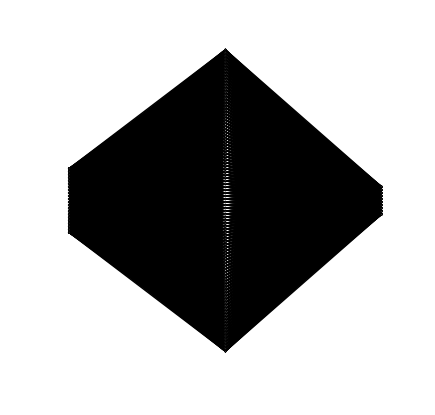

Confusion Matrix:

[[ 50   1   0   0   0   1   0   2   0   0]
 [  0  42   0   8   0   0   0   1  11   0]
 [  0   2 106   1   0   0   0   0   0   0]
 [  0   0   3 132   0   0   0   0   0   0]
 [  0   1   0   0  27   0   0   1   0   1]
 [  0   0   0   3   0  90   0   2   0   0]
 [  0   0   0   4   1   0   8   1   0   0]
 [  0   0   0   0   0   0   0 225   0   0]
 [  0   0   0   0   0   0   0   1 695   0]
 [  0   0   0   1   0   8   0   5   0   9]]


Species Accuracy Precision Recall F1-score 0 99.72% 100.00% 92.59% 96.15% 1 98.34% 91.30% 67.74% 77.78% 2 99.58% 97.25% 97.25% 97.25% 3 98.61% 88.59% 97.78% 92.96% 4 99.72% 96.43% 90.00% 93.10% 5 99.03% 90.91% 94.74% 92.78% 6 99.58% 100.00% 57.14% 72.73% 7 99.10% 94.54% 100.00% 97.19% 8 99.17% 98.44% 99.86% 99.14% 9 98.96% 90.00% 39.13% 54.55% Average 99.18% 94.75% 83.62% 87.36%

Iteration 5

Hidden Layers Training Fraction Number of Steps [100] 80% 500

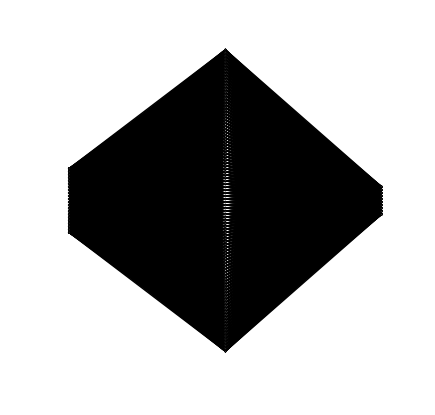

Confusion Matrix:

[[ 54   0   0   0   0   0   0   0   0   0]
 [  0  46   0   4   0   0   0   1  11   0]
 [  0   0 108   1   0   0   0   0   0   0]
 [  0   0   0 135   0   0   0   0   0   0]
 [  0   0   0   0  28   0   0   2   0   0]
 [  0   0   0   1   0  90   0   0   0   4]
 [  1   1   0   0   0   0  12   0   0   0]
 [  1   0   0   0   0   1   0 223   0   0]
 [  0   1   0   0   1   0   0   0 694   0]
 [  0   0   0   0   0   1   0   5   0  17]]


Species Accuracy Precision Recall F1-score 0 99.86% 96.43% 100.00% 98.18% 1 98.75% 95.83% 74.19% 83.64% 2 99.93% 100.00% 99.08% 99.54% 3 99.58% 95.74% 100.00% 97.83% 4 99.79% 96.55% 93.33% 94.92% 5 99.51% 97.83% 94.74% 96.26% 6 99.86% 100.00% 85.71% 92.31% 7 99.31% 96.54% 99.11% 97.81% 8 99.10% 98.44% 99.71% 99.07% 9 99.31% 80.95% 73.91% 77.27% Average 99.50% 95.83% 91.98% 93.68%

Iteration 6

Hidden Layers Training Fraction Number of Steps [100] 80% 1000

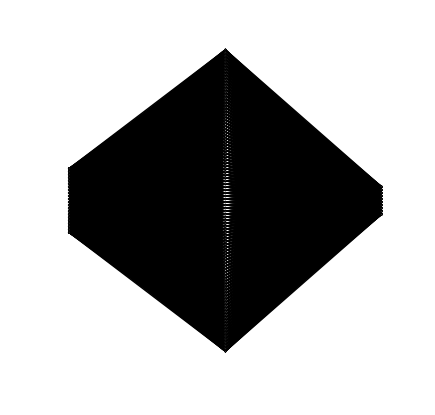

Confusion Matrix:

[[ 52   0   0   0   0   1   0   1   0   0]
 [  0  55   3   2   0   0   0   0   2   0]
 [  1   0 107   1   0   0   0   0   0   0]
 [  0   3   2 129   0   0   0   0   0   1]
 [  0   0   0   0  30   0   0   0   0   0]
 [  0   0   0   0   0  94   0   0   0   1]
 [  0   0   0   0   0   0  14   0   0   0]
 [  0   1   0   0   0   0   0 222   2   0]
 [  0   1   0   0   0   0   0   0 695   0]
 [  0   0   0   0   0   0   0   2   0  21]]


Species Accuracy Precision Recall F1-score 0 99.79% 98.11% 96.30% 97.20% 1 99.17% 91.67% 88.71% 90.16% 2 99.51% 95.54% 98.17% 96.83% 3 99.38% 97.73% 95.56% 96.63% 4 100.00% 100.00% 100.00% 100.00% 5 99.86% 98.95% 98.95% 98.95% 6 100.00% 100.00% 100.00% 100.00% 7 99.58% 98.67% 98.67% 98.67% 8 99.65% 99.43% 99.86% 99.64% 9 99.72% 91.30% 91.30% 91.30% Average 99.67% 97.14% 96.75% 96.94%

Iteration 7

Hidden Layers Training Fraction Number of Steps [10, 10] 80% 100

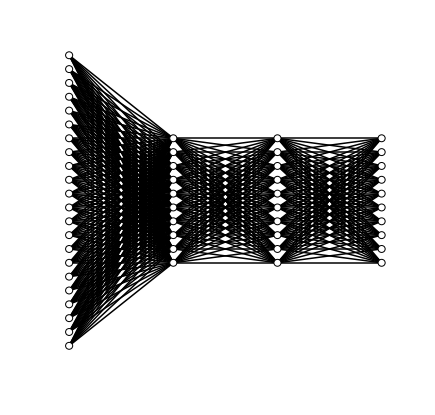

Confusion Matrix:

[[ 31   2   1   0   0   3   0  17   0   0]
 [  0  28  11  12   0   0   0   2   9   0]
 [  0   0  86  23   0   0   0   0   0   0]
 [  0   0  18 117   0   0   0   0   0   0]
 [  0   4   5   0   0   1   0   7  13   0]
 [  0   0   0   0   0  92   0   2   0   1]
 [  1   0  13   0   0   0   0   0   0   0]
 [  5   0   0   0   0   5   0 215   0   0]
 [  0   0   0   2   0   0   0   1 693   0]
 [  0   0   0   1   0   8   0  14   0   0]]


Species Accuracy Precision Recall F1-score 0 97.99% 83.78% 57.41% 68.13% 1 97.23% 82.35% 45.16% 58.33% 2 95.08% 64.18% 78.90% 70.78% 3 96.12% 75.48% 86.67% 80.69% 4 97.92% nan% 0.00% nan% 5 98.61% 84.40% 96.84% 90.20% 6 99.03% nan% 0.00% nan% 7 96.33% 83.33% 95.56% 89.03% 8 98.27% 96.92% 99.57% 98.23% 9 98.34% 0.00% 0.00% nan% Average 97.49% 71.31% 56.01% 79.34%

Iteration 8

Hidden Layers Training Fraction Number of Steps [10, 10] 80% 500

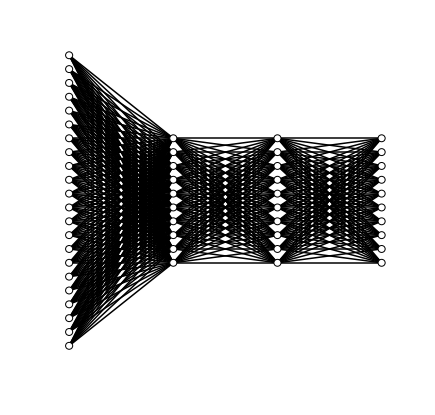

Confusion Matrix:

[[ 50   1   0   1   0   1   0   0   0   1]
 [  0  41   3   3   4   0   0   4   7   0]
 [  0   0 108   0   1   0   0   0   0   0]
 [  0   2   7 122   0   0   0   2   0   2]
 [  0   4   4   0  17   2   0   1   1   1]
 [  1   0   1   1   0  91   0   0   0   1]
 [  0   0   7   0   0   0   5   0   0   2]
 [  4   0   0   0   0   3   0 217   1   0]
 [  0   5   0   0   0   1   0   0 690   0]
 [  2   0   1   0   0   5   0   3   0  12]]


Species Accuracy Precision Recall F1-score 0 99.24% 87.72% 92.59% 90.09% 1 97.71% 77.36% 66.13% 71.30% 2 98.34% 82.44% 99.08% 90.00% 3 98.75% 96.06% 90.37% 93.13% 4 98.75% 77.27% 56.67% 65.38% 5 98.89% 88.35% 95.79% 91.92% 6 99.38% 100.00% 35.71% 52.63% 7 98.75% 95.59% 96.44% 96.02% 8 98.96% 98.71% 99.14% 98.92% 9 98.75% 63.16% 52.17% 57.14% Average 98.75% 86.67% 78.41% 80.65%

Iteration 9

Hidden Layers Training Fraction Number of Steps [10, 10] 80% 1000

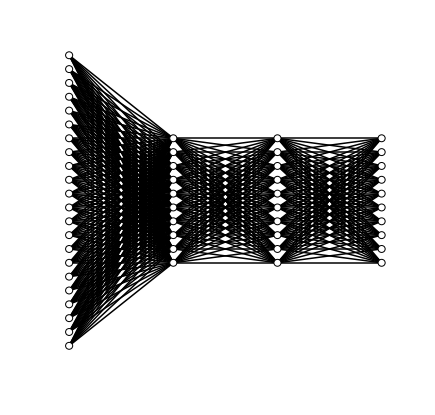

Confusion Matrix:

[[ 52   0   0   0   0   1   0   1   0   0]
 [  0  44   6   3   3   0   0   2   4   0]
 [  0   4 101   3   0   0   1   0   0   0]
 [  0   1   6 126   0   1   0   1   0   0]
 [  0   0   0   0  27   1   2   0   0   0]
 [  1   0   0   2   0  91   0   0   0   1]
 [  1   0   0   0   0   0  12   0   0   1]
 [  2   1   0   0   0   0   0 221   1   0]
 [  0   2   0   0   0   0   0   1 692   1]
 [  0   0   0   1   0   3   0   1   0  18]]


Species Accuracy Precision Recall F1-score 0 99.58% 92.86% 96.30% 94.55% 1 98.20% 84.62% 70.97% 77.19% 2 98.61% 89.38% 92.66% 90.99% 3 98.75% 93.33% 93.33% 93.33% 4 99.58% 90.00% 90.00% 90.00% 5 99.31% 93.81% 95.79% 94.79% 6 99.65% 80.00% 85.71% 82.76% 7 99.31% 97.36% 98.22% 97.79% 8 99.38% 99.28% 99.43% 99.35% 9 99.45% 85.71% 78.26% 81.82% Average 99.18% 90.64% 90.07% 90.26%

Iteration 10

Hidden Layers Training Fraction Number of Steps [100, 100] 80% 100

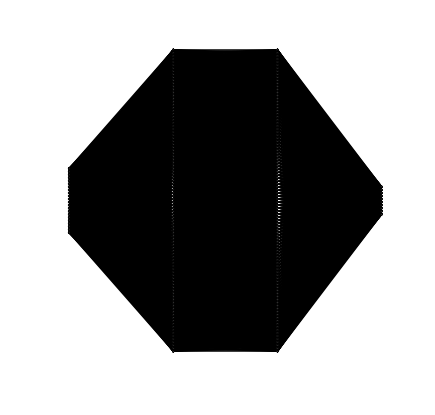

Confusion Matrix:

[[ 46   1   0   2   0   3   0   2   0   0]
 [  0  51   1   2   1   0   0   0   7   0]
 [  0   3 105   0   0   0   1   0   0   0]
 [  0   5   7 121   0   2   0   0   0   0]
 [  0   1   0   0  29   0   0   0   0   0]
 [  1   0   0   0   0  94   0   0   0   0]
 [  2   0   0   0   2   0  10   0   0   0]
 [  2   1   0   0   2   0   0 220   0   0]
 [  0   1   0   0   0   0   0   1 694   0]
 [  1   0   0   0   3   3   0   6   0  10]]


Species Accuracy Precision Recall F1-score 0 99.03% 88.46% 85.19% 86.79% 1 98.41% 80.95% 82.26% 81.60% 2 99.17% 92.92% 96.33% 94.59% 3 98.75% 96.80% 89.63% 93.08% 4 99.38% 78.38% 96.67% 86.57% 5 99.38% 92.16% 98.95% 95.43% 6 99.65% 90.91% 71.43% 80.00% 7 99.03% 96.07% 97.78% 96.92% 8 99.38% 99.00% 99.71% 99.36% 9 99.10% 100.00% 43.48% 60.61% Average 99.13% 91.56% 86.14% 87.49%

Iteration 11

Hidden Layers Training Fraction Number of Steps [100, 100] 80% 500

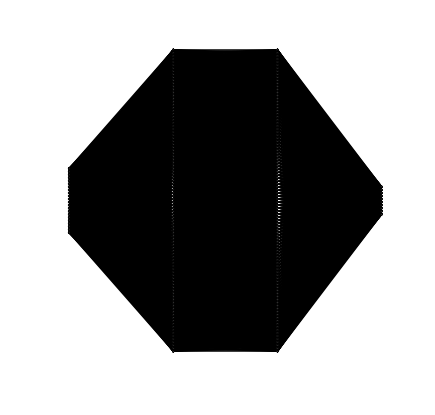

Confusion Matrix:

[[ 50   1   0   0   0   1   0   2   0   0]
 [  0  61   0   0   0   0   0   0   1   0]
 [  0   1 107   0   0   0   1   0   0   0]
 [  0   6   0 127   0   0   0   1   0   1]
 [  0   0   0   1  29   0   0   0   0   0]
 [  0   0   0   0   0  93   0   0   0   2]
 [  1   0   0   0   0   0  13   0   0   0]
 [  0   0   0   0   0   0   0 225   0   0]
 [  0   1   0   0   0   0   0   0 695   0]
 [  1   0   0   0   0   0   1   0   0  21]]


Species Accuracy Precision Recall F1-score 0 99.58% 96.15% 92.59% 94.34% 1 99.31% 87.14% 98.39% 92.42% 2 99.86% 100.00% 98.17% 99.07% 3 99.38% 99.22% 94.07% 96.58% 4 99.93% 100.00% 96.67% 98.31% 5 99.79% 98.94% 97.89% 98.41% 6 99.79% 86.67% 92.86% 89.66% 7 99.79% 98.68% 100.00% 99.34% 8 99.86% 99.86% 99.86% 99.86% 9 99.65% 87.50% 91.30% 89.36% Average 99.70% 95.42% 96.18% 95.73%

Iteration 12

Hidden Layers Training Fraction Number of Steps [100, 100] 80% 1000

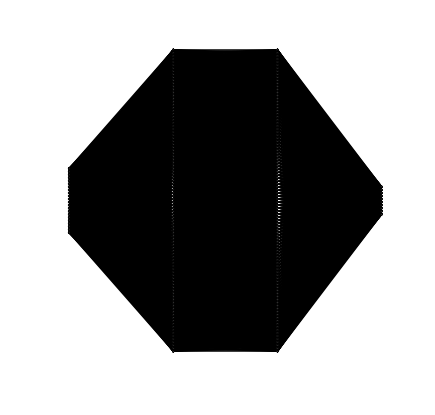

Confusion Matrix:

[[ 52   0   0   0   0   1   1   0   0   0]
 [  0  53   3   0   0   0   0   0   6   0]
 [  0   0 109   0   0   0   0   0   0   0]
 [  0   1   0 132   0   1   0   0   0   1]
 [  0   0   0   0  30   0   0   0   0   0]
 [  0   0   0   0   0  94   0   0   0   1]
 [  1   0   0   1   0   0  12   0   0   0]
 [  1   0   0   0   0   1   0 223   0   0]
 [  0   0   0   0   0   0   0   2 694   0]
 [  0   0   0   0   0   1   0   1   0  21]]


Species Accuracy Precision Recall F1-score 0 99.72% 96.30% 96.30% 96.30% 1 99.31% 98.15% 85.48% 91.38% 2 99.79% 97.32% 100.00% 98.64% 3 99.72% 99.25% 97.78% 98.51% 4 100.00% 100.00% 100.00% 100.00% 5 99.65% 95.92% 98.95% 97.41% 6 99.79% 92.31% 85.71% 88.89% 7 99.65% 98.67% 99.11% 98.89% 8 99.45% 99.14% 99.71% 99.43% 9 99.72% 91.30% 91.30% 91.30% Average 99.68% 96.84% 95.43% 96.07%

Iteration 13

Hidden Layers Training Fraction Number of Steps [10, 10, 10] 80% 100

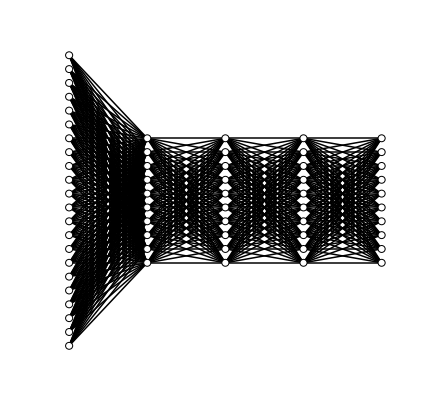

Confusion Matrix:

[[  0   0   0   1   0   0   0  50   3   0]
 [  0   2  13   9   0   0   0  19  19   0]
 [  0   0  41  61   0   0   0   7   0   0]
 [  0   0   8 126   0   1   0   0   0   0]
 [  0   0   8   0   0   2   0  19   1   0]
 [  0   0   0   0   0  61   0  34   0   0]
 [  0   0   1   3   0   6   0   4   0   0]
 [  0   0   0   0   0   1   0 219   5   0]
 [  0   0   0   1   0   0   0   0 695   0]
 [  0   0   0   0   0   7   0  16   0   0]]


Species Accuracy Precision Recall F1-score 0 96.26% nan% 0.00% nan% 1 95.84% 100.00% 3.23% 6.25% 2 93.21% 57.75% 37.61% 45.56% 3 94.18% 62.69% 93.33% 75.00% 4 97.92% nan% 0.00% nan% 5 96.47% 78.21% 64.21% 70.52% 6 99.03% nan% 0.00% nan% 7 89.26% 59.51% 97.33% 73.86% 8 97.99% 96.13% 99.86% 97.96% 9 98.41% nan% 0.00% nan% Average 95.86% 75.71% 39.56% 61.52%

Iteration 14

Hidden Layers Training Fraction Number of Steps [10, 10, 10] 80% 500

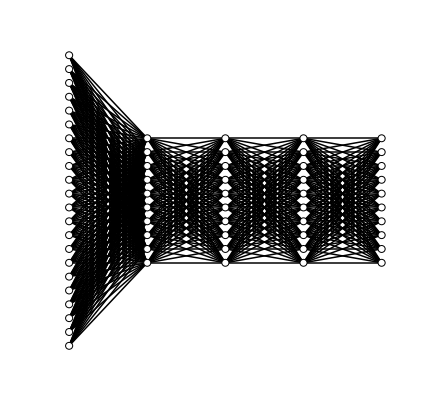

Confusion Matrix:

[[ 52   1   0   0   0   0   0   1   0   0]
 [  0  43   4   1   2   1   0   0  11   0]
 [  0   3 105   0   0   0   0   0   0   1]
 [  0   6   4 121   0   0   0   1   0   3]
 [  0   1   2   0  24   1   0   0   1   1]
 [  1   0   0   1   0  90   0   3   0   0]
 [  0   0   1   0   2   0   0   0   0  11]
 [  1   1   0   0   0   1   0 220   2   0]
 [  1   0   0   0   0   0   0   1 694   0]
 [  0   0   0   0   0   5   0   3   0  15]]


Species Accuracy Precision Recall F1-score 0 99.65% 94.55% 96.30% 95.41% 1 97.85% 78.18% 69.35% 73.50% 2 98.96% 90.52% 96.33% 93.33% 3 98.89% 98.37% 89.63% 93.80% 4 99.31% 85.71% 80.00% 82.76% 5 99.10% 91.84% 94.74% 93.26% 6 99.03% nan% 0.00% nan% 7 99.03% 96.07% 97.78% 96.92% 8 98.89% 98.02% 99.71% 98.86% 9 98.34% 48.39% 65.22% 55.56% Average 98.91% 86.85% 78.91% 87.04%

Iteration 15

Hidden Layers Training Fraction Number of Steps [10, 10, 10] 80% 1000

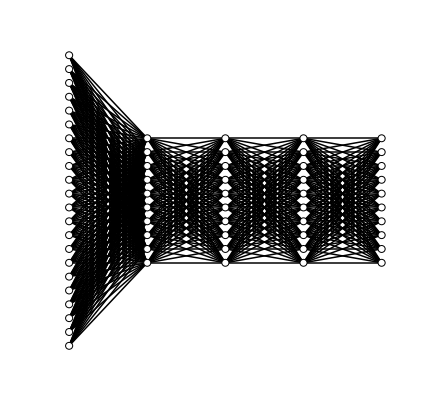

Confusion Matrix:

[[ 51   1   0   0   0   1   0   0   0   1]
 [  0  50   4   4   0   0   0   0   4   0]
 [  0   2 105   1   0   0   1   0   0   0]
 [  0   0   3 131   0   0   0   0   0   1]
 [  0   4   0   1  25   0   0   0   0   0]
 [  0   0   0   0   0  90   0   1   0   4]
 [  0   0   0   0   1   1  12   0   0   0]
 [  4   0   0   0   1   0   0 217   2   1]
 [  0   2   0   0   1   0   0   1 692   0]
 [  0   0   0   2   0   2   0   1   0  18]]


Species Accuracy Precision Recall F1-score 0 99.51% 92.73% 94.44% 93.58% 1 98.54% 84.75% 80.65% 82.64% 2 99.24% 93.75% 96.33% 95.02% 3 99.17% 94.24% 97.04% 95.62% 4 99.45% 89.29% 83.33% 86.21% 5 99.38% 95.74% 94.74% 95.24% 6 99.79% 92.31% 85.71% 88.89% 7 99.24% 98.64% 96.44% 97.53% 8 99.31% 99.14% 99.43% 99.28% 9 99.17% 72.00% 78.26% 75.00% Average 99.28% 91.26% 90.64% 90.90%

Iteration 16

Hidden Layers Training Fraction Number of Steps [100, 100, 100] 80% 100

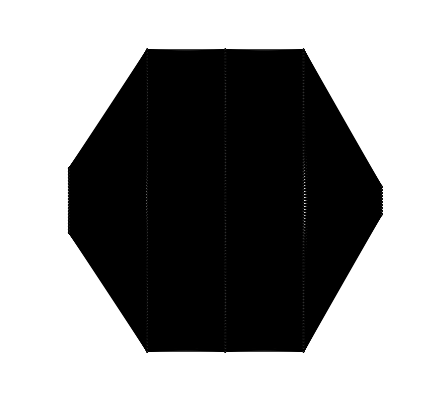

Confusion Matrix:

[[ 46   2   0   1   0   2   0   2   0   1]
 [  0  41   0  12   0   0   0   0   9   0]
 [  0   0 108   1   0   0   0   0   0   0]
 [  0   1   4 130   0   0   0   0   0   0]
 [  0   1   0   0  26   0   3   0   0   0]
 [  0   0   0   2   0  93   0   0   0   0]
 [  0   0   2   4   0   2   6   0   0   0]
 [  1   1   0   0   0   4   0 216   0   3]
 [  0   3   0   0   0   0   0   1 691   1]
 [  0   0   0   3   0   9   0   0   0  11]]


Species Accuracy Precision Recall F1-score 0 99.38% 97.87% 85.19% 91.09% 1 97.99% 83.67% 66.13% 73.87% 2 99.51% 94.74% 99.08% 96.86% 3 98.06% 84.97% 96.30% 90.28% 4 99.72% 100.00% 86.67% 92.86% 5 98.68% 84.55% 97.89% 90.73% 6 99.24% 66.67% 42.86% 52.17% 7 99.17% 98.63% 96.00% 97.30% 8 99.03% 98.71% 99.28% 99.00% 9 98.82% 68.75% 47.83% 56.41% Average 98.96% 87.86% 81.72% 84.06%

Iteration 17

Hidden Layers Training Fraction Number of Steps [100, 100, 100] 80% 500

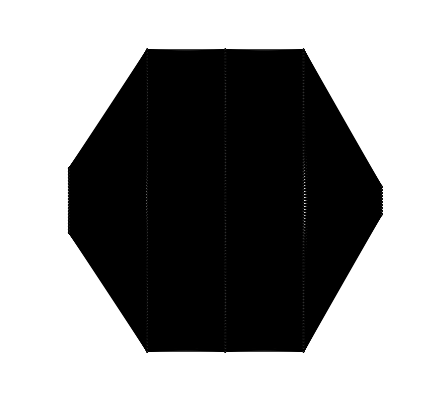

Confusion Matrix:

[[ 53   0   0   0   0   0   0   1   0   0]
 [  0  46   0   4   0   0   0   0  12   0]
 [  0   1 108   0   0   0   0   0   0   0]
 [  0   2   1 131   0   0   0   0   0   1]
 [  0   0   0   0  30   0   0   0   0   0]
 [  0   0   0   0   0  93   0   0   0   2]
 [  1   0   0   0   0   0  13   0   0   0]
 [  0   0   0   0   1   0   0 222   1   1]
 [  0   2   0   0   0   0   0   1 693   0]
 [  0   0   0   0   0   1   0   0   0  22]]


Species Accuracy Precision Recall F1-score 0 99.86% 98.15% 98.15% 98.15% 1 98.54% 90.20% 74.19% 81.42% 2 99.86% 99.08% 99.08% 99.08% 3 99.45% 97.04% 97.04% 97.04% 4 99.93% 96.77% 100.00% 98.36% 5 99.79% 98.94% 97.89% 98.41% 6 99.93% 100.00% 92.86% 96.30% 7 99.65% 99.11% 98.67% 98.89% 8 98.89% 98.16% 99.57% 98.86% 9 99.65% 84.62% 95.65% 89.80% Average 99.56% 96.21% 95.31% 95.63%

Iteration 18

Hidden Layers Training Fraction Number of Steps [100, 100, 100] 80% 1000

In [0]:
# k-fold Cross-validation data splitting results
display_model_results(kfcv_evaluations)

# Conclusion
The architectural choices of a **Neural Network** are of tremendous importance when designing such a network and its model, including the architecture, the way the data is split and fed into it, the number of times said data goes through the forward and backpropagation mechanisms. 

With our approach we have observed that, for instance, a **Neural Network** with a single layer comprised of 100 nodes, for our dataset, can better describe (without overfitting) the data then a network with two hidden layers of 10 neurons each.

## Other

### Deletes temporary files created by TensorFlow

In [0]:
# Allows deleting models save folder in windows
tf.summary.FileWriterCache.clear()

In [0]:
import tempfile
import os
from pathlib import Path
import shutil

temp_dir = Path(tempfile.gettempdir())
dir_list = [f for f in temp_dir.glob('tmp*') if f.is_dir()] 
for dir in dir_list:
    shutil.rmtree(dir, ignore_errors=True)
        